In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats


In [2]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 

    exclude: list of subject IDs that should be excluded from the final df 

    """
    
    exclude = [764036, 893334, 192813, 485648, 920545, 699567, 277612, 568975,
       949355, 651218, 297210, 284316, 407286, 156339, 174125, 302646,
       162971, 372438, 951905, 940993, 581165, 457460, 350641, 579265,
       535676, 564312, 749256, 540104, 769506, 297386, 776784, 501020,
       392648, 206615, 506907]
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [3]:
# path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

path = "/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/oct20_data"

# path = '/Users/pmahableshwarkar/Documents/Depth_Project/TAC_data'

# path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/v2_depth_duration_MTurk/data'

missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants before cleaning:  291
Number of participants with 10% or more missed trials:  1


In [311]:
# missed_trial_cleaned_data

#### Distribution of Unit Preferences

In [4]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  291


In [5]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit == "feet":
        feet_count += 1
    if unit == "meters":
        meters_count += 1
    
meters_count, feet_count

(110, 181)

In [6]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [7]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


In [8]:
# RT_cleaned_data

In [9]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [10]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [11]:
# outlier_cleaned_data

In [12]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [13]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.018214585404311 [0.7545536463510778, 12.072858341617245]
Avg Estim Cleaning: Number of Participants Removed 25


In [14]:
# avg_estim_cleaned_data

In [15]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [16]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(avg_estim_cleaned_data)

Number of participants removed: repeat responses:  70


In [17]:
# repeat_resp_cleaned_data

In [18]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [19]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  0
Number of participants left:  195


In [20]:
# find repeat sequences due to mturk glitch (so that N=192, as pre-registered) --> remove subject that was collected last 

all_subjects = cleaned_data.subjID.unique()
all_sequences = cleaned_data.sequenceName.unique()
for seq in all_sequences:
    seq_df = cleaned_data.loc[cleaned_data['sequenceName']== seq]
    seq_subjs = seq_df.subjID.unique()
    if len(seq_subjs) > 1:
        print(seq_subjs)
    

[957876 714857]
[717534 305914]
[947436 349317]


In [21]:
# remove participants
remove = [947436, 305914, 957876]
for index, row in cleaned_data.iterrows():
    if row['subjID'] in remove:
        cleaned_data.drop(index, inplace=True)

In [22]:
final_data = cleaned_data.copy(deep=True)

In [23]:
len(final_data.subjID.unique())

192

In [24]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

2.4185515586896726

#### Unit Distribution 

In [25]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

(158, 34)

Filter data by removing participants that used meters 

In [26]:
# for subj in final_subjects:
#     if subj not in feet_subjects:
#         print(subj)
#         final_data.drop(final_data.loc[final_data['subjID']==subj].index, inplace=True)

In [27]:
len(final_data.subjID.unique())

192

### Normalize Data by Participant's Avg 

In [28]:
def normalize_dfs(df):
    """
    Args:
        final data 
    Return:
        data normalized by participants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'

    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    norm_subjects = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    return normalized_df

In [29]:
normalized_data = normalize_dfs(final_data)

#### Age

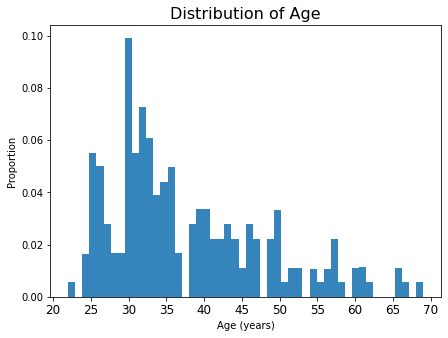

In [30]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 5) ,fontsize=12)
# plt.yticks([])
plt.xlabel('Age (years)')
plt.ylabel('Proportion')
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.9)
plt.show()


#### Distribution of Participant Average Estimates

In [31]:
all_subjIDs = final_data.subjID.unique()
avgs = []
for subj in all_subjIDs:
    subj_df = final_data.loc[final_data['subjID'] == subj]
    subj_avg = np.array(subj_df['depth_estimate']).mean()
    avgs.append(subj_avg)
    if subj_avg > 11:
        print(subj)
    
# 9-6-2021_6-48-58_485648.csv
# 9-6-2021_7-13-44_277612.csv
# 9-6-2021_7-48-11_153554.csv

153554


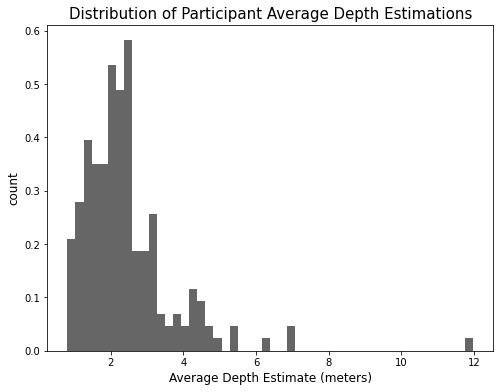

In [32]:
plt.figure(figsize = [8,6])
plt.title("Distribution of Participant Average Depth Estimations", fontsize = 15)
plt.ylabel("count", fontsize = 12)
plt.xlabel("Average Depth Estimate (meters)", fontsize = 12)
_, bins, _ = plt.hist(avgs, 50, density=1, alpha=0.6, color = 'black')
mu, sigma = scipy.stats.norm.fit(avgs)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line, color = 'orange')

plt.show()

#### Distribution of Depth Estimates

In [33]:
meters_data = final_data.loc[final_data['unitSelection'] == 'meters']
feet_data = final_data.loc[final_data['unitSelection'] == 'feet']

meters_depth_estimates = meters_data['depth_estimate']
feet_depth_estimates = feet_data['depth_estimate']

feet_estims = []
feet_counts = []
for val, cnt in feet_depth_estimates.value_counts().iteritems():
    feet_estims.append(val)
    feet_counts.append(cnt/166)
    
meters_estims = []
meters_counts = []
for val, cnt in meters_depth_estimates.value_counts().iteritems():
    meters_estims.append(val)
    meters_counts.append(cnt/25)


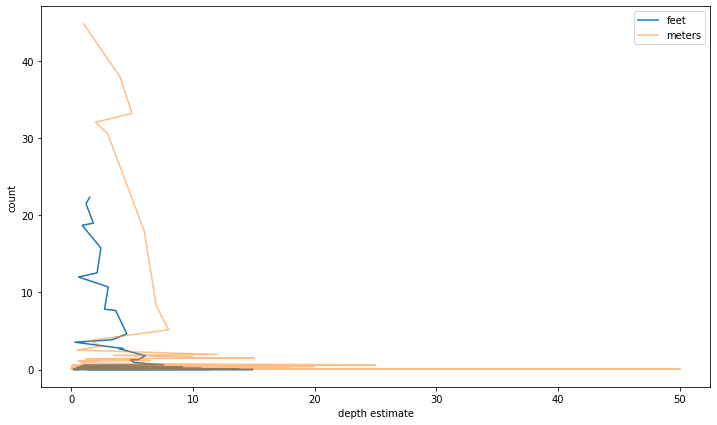

In [34]:

plt.figure(figsize = [12, 7])
# plt.xticks(np.arange(0, 40, 5))
plt.plot(feet_estims, feet_counts, label = 'feet')
plt.plot(meters_estims, meters_counts, label = 'meters', alpha = 0.5)
plt.legend()
plt.ylabel('count')
plt.xlabel('depth estimate')

plt.show()

In [35]:
# plt.title('Distribution of Depth Estimates')
# plt.xlabel('Depth Estimate')
# plt.ylabel('count')

# hist = plt.hist(depth_estimates, 200, density=1, alpha=1, color = 'teal')


### Data split by duration

In [36]:
data_250ms = final_data[final_data['duration'] == 250]
data_500ms = final_data[final_data['duration'] == 500]
data_750ms = final_data[final_data['duration'] == 750]
data_1000ms = final_data[final_data['duration'] == 1000]

duration_data = [data_250ms, data_500ms, data_750ms, data_1000ms]

n_data_250ms = normalized_data[normalized_data['duration'] == 250]
n_data_500ms = normalized_data[normalized_data['duration'] == 500]
n_data_750ms = normalized_data[normalized_data['duration'] == 750]
n_data_1000ms = normalized_data[normalized_data['duration'] == 1000]

normalized_duration_data = [n_data_250ms, n_data_500ms, n_data_750ms, n_data_1000ms]


In [37]:
dest = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_data/'
durations = ['250', '500', '750', '1000']

for i in range(len(duration_data)):  
    duration_data[i].to_csv(dest + 'raw_' + durations[i] + '_data.csv' , index=True)
    normalized_duration_data[i].to_csv(dest + 'normalized_' + durations[i] + '_data.csv' , index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_data/raw_250_data.csv'

## Results: Averaged across Targets

In [ ]:
def pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
        
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables

In [ ]:
raw_pivot = pivotTable(duration_data)
normalized_pivot = pivotTable(normalized_duration_data)

In [ ]:
def _getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 



In [ ]:
raw_final = _getxy(raw_pivot)
normalized_final = _getxy(normalized_pivot) 


In [ ]:
def _createVars(final_data):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]

In [ ]:
raw_final_vars = _createVars(raw_final)
normalized_final_vars = _createVars(normalized_final)

In [ ]:
#Calculate the T-test for the means of two PAIRED samples of scores.

#This is a two-sided test for the null hypothesis that 2 PAIRED samples have identical average (expected) values. 

def _durationStatsTests(finaldata):
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print(len(final_y_250), len(final_y_500), len(final_y_750), len(final_y_1000))
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 

print("Results")
raw_ttests = _durationStatsTests(raw_final_vars)

print('\n')
print("Normalized Results")
normalized_ttests = _durationStatsTests(normalized_final_vars)

## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 

def subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes_intercepts = {'subjID': [], 'duration': [], 'block': [], 'slope': [], 'intercept' : [], 'avg_estim': [], 'age':[], 'gender': []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        block1 = subj_df.loc[subj_df['trial'] < 49]
        temp_block2 = subj_df.loc[subj_df['trial'] <= 96]
        block2 = temp_block2.loc[temp_block2['trial'] >= 49]
        temp_block3 = subj_df.loc[subj_df['trial'] <= 144]
        block3 = temp_block3.loc[temp_block3['trial'] > 96]
        block4 = subj_df.loc[subj_df['trial'] >= 145]
        blocks = [block1, block2, block3, block4]
        
        num_block = 1
        for block in blocks:
            for duration in durations:
                block_duration_subj_df = block.loc[block["duration"]  == duration]
                block_duration_subj_pivot = subject_pivotTable(block_duration_subj_df, duration)
                block_duration_subj_data = subject_getxy(block_duration_subj_pivot)

                x = np.array(block_duration_subj_data[0])
                y = np.array(block_duration_subj_data[1])
                avg_depth_estimate = np.mean(y)
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                subj_slopes_intercepts['subjID'].append(subj)
                subj_slopes_intercepts['duration'].append(duration)
                subj_slopes_intercepts['block'].append(num_block)
                subj_slopes_intercepts['slope'].append(slope)
                subj_slopes_intercepts['intercept'].append(intercept)
                subj_slopes_intercepts['avg_estim'].append(avg_depth_estimate)
                subj_slopes_intercepts['age'].append(block_duration_subj_df.age.unique()[0])
                subj_slopes_intercepts['gender'].append(block_duration_subj_df.gender.unique()[0])
                
            num_block += 1

    block_duration_df = pd.DataFrame(data=subj_slopes_intercepts)
        
    return block_duration_df  


In [359]:
subject_duration_block_slopes_intercepts = subjectData(final_data)

normalized_subject_duration_block_slopes_intercepts = subjectData(normalized_data)

In [360]:
subject_duration_block_slopes_intercepts

subjID  duration  block     slope  intercept  avg_estim  age gender
0     710814       250      1  0.308039   0.618557   1.524000   44    Man
1     710814       500      1  0.471858   0.049498   1.468582   44    Man
2     710814       750      1  0.339750   0.338131   1.397000   44    Man
3     710814      1000      1  0.514772  -0.013563   1.498600   44    Man
4     710814       250      2  0.250587   1.146672   1.905000   44    Man
...      ...       ...    ...       ...        ...        ...  ...    ...
3067  107287      1000      3  0.246090   3.109007   3.833333   25    Man
3068  107287       250      4  0.057818   3.236093   3.416667   25    Man
3069  107287       500      4 -0.387643   5.005468   3.833333   25    Man
3070  107287       750      4 -0.330494   4.741166   3.750000   25    Man
3071  107287      1000      4 -0.496901   4.883623   3.416667   25    Man

[3072 rows x 8 columns]

In [361]:
dest = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_data/'

subject_duration_block_slopes_intercepts.to_csv(dest + 'raw_subject_slopes.csv', index=True)

normalized_subject_duration_block_slopes_intercepts.to_csv(dest + 'normalized_subject_slopes.csv', index=True)

https://www.pythonfordatascience.org/factorial-anova-python/

In [362]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf


# model = ols("slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)", data=subject_duration_block_slopes_intercepts).fit()
# aov_table = sm.stats.anova_lm(model, typ=2)


https://nicoleeic.github.io/Brain_and_Code/2019/09/02/ANOVA_new.html

In [363]:
# fit model to data to obtain parameter estimates
model1_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)', data=subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('IV: Duration, Block')
print('DV: Slope')

# show anova table
model1_anovaTable = sm.stats.anova_lm(model1_fit, typ=2)
model1_anovaTable

IV: Duration, Block
DV: Slope


sum_sq      df         F    PR(>F)
C(duration, Sum)                  3.826229     3.0  5.199379  0.001395
C(block, Sum)                     0.381996     3.0  0.519086  0.669152
C(duration, Sum):C(block, Sum)    1.147357     9.0  0.519706  0.861335
Residual                        749.638020  3056.0       NaN       NaN

In [364]:
# fit model to data to obtain parameter estimates
model2_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(age, Sum) + C(duration, Sum)*C(age, Sum)', data=subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model2_fit.summary())

print('IV: Duration, Age')
print('DV: Slope')

# show anova table
model2_anovaTable = sm.stats.anova_lm(model2_fit, typ=2)
model2_anovaTable

IV: Duration, Age
DV: Slope


sum_sq      df          F        PR(>F)
C(duration, Sum)                3.826229     3.0   5.783214  6.127968e-04
C(age, Sum)                   100.684998    40.0  11.413644  3.399963e-66
C(duration, Sum):C(age, Sum)    9.162247   120.0   0.346211  1.000000e+00
Residual                      641.320127  2908.0        NaN           NaN

In [51]:
# plt.rc('figure', figsize=(12, 7))
# #plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
# plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('output.png')

In [52]:
# norm_model = ols("slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)", data=normalized_subject_duration_block_slopes_intercepts).fit()
# norm_aov_table = sm.stats.anova_lm(norm_model, typ=2)


In [53]:
# norm_aov_table

In [365]:
# fit model to data to obtain parameter estimates
model3_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)', data=normalized_subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('Normalized Data: ')
print('IV: Duration, Block')
print('DV: Slope')

# show anova table
model3_anovaTable = sm.stats.anova_lm(model3_fit, typ=2)
model3_anovaTable

Normalized Data: 
IV: Duration, Block
DV: Slope


sum_sq      df         F    PR(>F)
C(duration, Sum)                 0.658367     3.0  7.627393  0.000044
C(block, Sum)                    0.110657     3.0  1.281996  0.278787
C(duration, Sum):C(block, Sum)   0.171365     9.0  0.661772  0.744217
Residual                        87.927347  3056.0       NaN       NaN

In [366]:
# fit model to data to obtain parameter estimates
model4_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(age, Sum) + C(duration, Sum)*C(age, Sum)', data=normalized_subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('Normalized Data: ')
print('IV: Duration, Age')
print('DV: Slope')

# show anova table
model4_anovaTable = sm.stats.anova_lm(model4_fit, typ=2)
model4_anovaTable

Normalized Data: 
IV: Duration, Age
DV: Slope


sum_sq      df         F        PR(>F)
C(duration, Sum)               0.658367     3.0  8.273444  1.767457e-05
C(age, Sum)                    9.880331    40.0  9.312175  1.113666e-51
C(duration, Sum):C(age, Sum)   1.193454   120.0  0.374942  1.000000e+00
Residual                      77.135584  2908.0       NaN           NaN

In [367]:
# fit model to data to obtain parameter estimates
model5_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(gender, Sum) + C(duration, Sum)*C(gender, Sum)', data=subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('Raw Data: ')
print('IV: Duration, Gender')
print('DV: Slope')

# show anova table
model5_anovaTable = sm.stats.anova_lm(model5_fit, typ=2)
model5_anovaTable

Raw Data: 
IV: Duration, Gender
DV: Slope


sum_sq      df         F    PR(>F)
C(duration, Sum)                   3.826229     3.0  5.199218  0.001395
C(gender, Sum)                     1.117416     3.0  1.518386  0.207654
C(duration, Sum):C(gender, Sum)    0.388813     9.0  0.176111  0.996454
Residual                         749.661143  3056.0       NaN       NaN

In [368]:
# fit model to data to obtain parameter estimates
model6_fit = smf.ols(formula='slope ~ C(duration, Sum) + C(gender, Sum) + C(duration, Sum)*C(gender, Sum)', data=normalized_subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('Normalized Data: ')
print('IV: Duration, Gender')
print('DV: Slope')

# show anova table
model6_anovaTable = sm.stats.anova_lm(model6_fit, typ=2)
model6_anovaTable

Normalized Data: 
IV: Duration, Gender
DV: Slope


sum_sq      df          F        PR(>F)
C(duration, Sum)                  0.658367     3.0   7.701406  3.997646e-05
C(gender, Sum)                    0.997256     3.0  11.665640  1.340289e-07
C(duration, Sum):C(gender, Sum)   0.129783     9.0   0.506058  8.711437e-01
Residual                         87.082330  3056.0        NaN           NaN

In [369]:
slopes_women = subject_duration_block_slopes_intercepts.loc[subject_duration_block_slopes_intercepts['gender'] == 'Woman']
slopes_men = subject_duration_block_slopes_intercepts.loc[subject_duration_block_slopes_intercepts['gender'] == 'Man']

women_duration_slopes = [slopes_women.loc[slopes_women['duration'] == 250],
                         slopes_women.loc[slopes_women['duration'] == 500],
                         slopes_women.loc[slopes_women['duration'] == 750],
                         slopes_women.loc[slopes_women['duration'] == 1000]]

men_duration_slopes = [slopes_men.loc[slopes_men['duration'] == 250],
                       slopes_men.loc[slopes_men['duration'] == 500],
                       slopes_men.loc[slopes_men['duration'] == 750],
                       slopes_men.loc[slopes_men['duration'] == 1000]]

ttest_gender_250 = stats.ttest_ind(women_duration_slopes[0]['slope'],men_duration_slopes[0]['slope'])
print('Slope 250 ms: Women vs. Men')
print(ttest_gender_250)

ttest_gender_500 = stats.ttest_ind(women_duration_slopes[1]['slope'],men_duration_slopes[1]['slope'])
print('Slope 500 ms: Women vs. Men')
print(ttest_gender_500)

ttest_gender_750 = stats.ttest_ind(women_duration_slopes[2]['slope'],men_duration_slopes[2]['slope'])
print('Slope 750 ms: Women vs. Men')
print(ttest_gender_750)

ttest_gender_1000 = stats.ttest_ind(women_duration_slopes[3]['slope'],men_duration_slopes[3]['slope'])
print('Slope 1000 ms: Women vs. Men')
print(ttest_gender_1000)


Slope 250 ms: Women vs. Men
Ttest_indResult(statistic=-0.2181527018117753, pvalue=0.8273691631742217)
Slope 500 ms: Women vs. Men
Ttest_indResult(statistic=-0.2916995067038143, pvalue=0.7705966199512784)
Slope 750 ms: Women vs. Men
Ttest_indResult(statistic=-0.2895728607930833, pvalue=0.7722226388232796)
Slope 1000 ms: Women vs. Men
Ttest_indResult(statistic=0.2910535570117968, pvalue=0.7710904022071885)


In [370]:
n_slopes_women = normalized_subject_duration_block_slopes_intercepts.loc[normalized_subject_duration_block_slopes_intercepts['gender'] == 'Woman']
n_slopes_men = normalized_subject_duration_block_slopes_intercepts.loc[normalized_subject_duration_block_slopes_intercepts['gender'] == 'Man']

n_women_duration_slopes = [n_slopes_women.loc[n_slopes_women['duration'] == 250],
                         n_slopes_women.loc[n_slopes_women['duration'] == 500],
                         n_slopes_women.loc[n_slopes_women['duration'] == 750],
                         n_slopes_women.loc[n_slopes_women['duration'] == 1000]]

n_men_duration_slopes = [n_slopes_men.loc[n_slopes_men['duration'] == 250],
                       n_slopes_men.loc[n_slopes_men['duration'] == 500],
                       n_slopes_men.loc[n_slopes_men['duration'] == 750],
                       n_slopes_men.loc[n_slopes_men['duration'] == 1000]]

n_ttest_gender_250 = stats.ttest_ind(n_women_duration_slopes[0]['slope'],n_men_duration_slopes[0]['slope'])
print('Normalized Slope 250 ms: Women vs. Men')
print(n_ttest_gender_250)

n_ttest_gender_500 = stats.ttest_ind(n_women_duration_slopes[1]['slope'],n_men_duration_slopes[1]['slope'])
print('Normalized Slope 500 ms: Women vs. Men')
print(n_ttest_gender_500)

n_ttest_gender_750 = stats.ttest_ind(n_women_duration_slopes[2]['slope'],n_men_duration_slopes[2]['slope'])
print('Normalized Slope 750 ms: Women vs. Men')
print(n_ttest_gender_750)

n_ttest_gender_1000 = stats.ttest_ind(n_women_duration_slopes[3]['slope'],n_men_duration_slopes[3]['slope'])
print('Normalized Slope 1000 ms: Women vs. Men')
print(n_ttest_gender_1000)

Normalized Slope 250 ms: Women vs. Men
Ttest_indResult(statistic=-0.4708354544927312, pvalue=0.6378944234001143)
Normalized Slope 500 ms: Women vs. Men
Ttest_indResult(statistic=-0.5475136095467612, pvalue=0.5841879483471689)
Normalized Slope 750 ms: Women vs. Men
Ttest_indResult(statistic=-1.1336036464037633, pvalue=0.2573211449304563)
Normalized Slope 1000 ms: Women vs. Men
Ttest_indResult(statistic=-0.22813880205714063, pvalue=0.8196001894745634)


In [371]:
# fit model to data to obtain parameter estimates
model7_fit = smf.ols(formula='avg_estim ~ C(duration, Sum) + C(gender, Sum) + C(duration, Sum)*C(gender, Sum)', data=subject_duration_block_slopes_intercepts).fit()
# print summary of linear regression
# print(model1_fit.summary())

print('Raw Data: ')
print('IV: Duration, Gender')
print('DV: Average Depth Estimate')

# show anova table
model7_anovaTable = sm.stats.anova_lm(model7_fit, typ=2)
model7_anovaTable

Raw Data: 
IV: Duration, Gender
DV: Average Depth Estimate


sum_sq      df         F    PR(>F)
C(duration, Sum)                    2.098439     3.0  0.357977  0.783374
C(gender, Sum)                     52.239579     3.0  8.911648  0.000007
C(duration, Sum):C(gender, Sum)     0.512761     9.0  0.029158  0.999998
Residual                         5971.366752  3056.0       NaN       NaN

In [372]:
avg_estim_women = subject_duration_block_slopes_intercepts.loc[subject_duration_block_slopes_intercepts['gender'] == 'Woman']
avg_estim_men = subject_duration_block_slopes_intercepts.loc[subject_duration_block_slopes_intercepts['gender'] == 'Man']

print("Average Depth Estimate: Women vs Men")
ttest_gender_avg_estim = stats.ttest_ind(slopes_women['avg_estim'],slopes_men['avg_estim'])
ttest_gender_avg_estim


Average Depth Estimate: Women vs Men


Ttest_indResult(statistic=1.719889983419898, pvalue=0.08555482656370288)

In [373]:
def AnovaRM_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

In [374]:
df_slope, df_intercept = AnovaRM_subjectData(final_data)
norm_df_slope, norm_df_intercept = AnovaRM_subjectData(normalized_data)

df_slope

subjID  duration     slope  age
0    710814       250  0.350348   44
1    710814       500  0.486968   44
2    710814       750  0.329218   44
3    710814      1000  0.523449   44
4    665311       250  0.137462   25
..      ...       ...       ...  ...
763  773761      1000  0.720520   32
764  107287       250  0.197475   25
765  107287       500  0.066849   25
766  107287       750 -0.181069   25
767  107287      1000 -0.038476   25

[768 rows x 4 columns]

In [375]:
slopes_250 = df_slope.loc[df_slope['duration'] == 250]
slopes_500 = df_slope.loc[df_slope['duration'] == 500]
slopes_750 = df_slope.loc[df_slope['duration'] == 750]
slopes_1000 = df_slope.loc[df_slope['duration'] == 1000]

In [376]:
print('T-Tests')
print("250ms vs. 500ms")
ttest_250_500 = stats.ttest_ind(slopes_250['slope'],slopes_500['slope'])
print(ttest_250_500)
print("250ms vs. 750ms")
ttest_250_750 = stats.ttest_ind(slopes_250['slope'],slopes_750['slope'])
print(ttest_250_750)
print("250ms vs. 1000ms")
ttest_250_1000 = stats.ttest_ind(slopes_250['slope'],slopes_1000['slope'])
print(ttest_250_1000)
print("500ms vs. 750ms")
ttest_500_750 = stats.ttest_ind(slopes_500['slope'],slopes_750['slope'])
print(ttest_500_750)
print("500ms vs. 1000ms")
ttest_500_1000 = stats.ttest_ind(slopes_500['slope'],slopes_1000['slope'])
print(ttest_500_1000)
print("750ms vs. 1000ms")
ttest_750_1000 = stats.ttest_ind(slopes_750['slope'],slopes_1000['slope'])
print(ttest_750_1000)

T-Tests
250ms vs. 500ms
Ttest_indResult(statistic=-1.4339486070331449, pvalue=0.15240496555739472)
250ms vs. 750ms
Ttest_indResult(statistic=-1.894838774053411, pvalue=0.05886863799977705)
250ms vs. 1000ms
Ttest_indResult(statistic=-2.0556606387187393, pvalue=0.04049444473578136)
500ms vs. 750ms
Ttest_indResult(statistic=-0.4626456525967372, pvalue=0.6438818002012424)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.6118016517858761, pvalue=0.5410329403878757)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.1455427398350635, pvalue=0.8843591389912062)


In [377]:
print('Paired T-Tests')
print("250ms vs. 500ms")
ttest_250_500 = stats.ttest_rel(slopes_250['slope'],slopes_500['slope'])
print(ttest_250_500)
print("250ms vs. 750ms")
ttest_250_750 = stats.ttest_rel(slopes_250['slope'],slopes_750['slope'])
print(ttest_250_750)
print("250ms vs. 1000ms")
ttest_250_1000 = stats.ttest_rel(slopes_250['slope'],slopes_1000['slope'])
print(ttest_250_1000)
print("500ms vs. 750ms")
ttest_500_750 = stats.ttest_rel(slopes_500['slope'],slopes_750['slope'])
print(ttest_500_750)
print("500ms vs. 1000ms")
ttest_500_1000 = stats.ttest_rel(slopes_500['slope'],slopes_1000['slope'])
print(ttest_500_1000)
print("750ms vs. 1000ms")
ttest_750_1000 = stats.ttest_rel(slopes_750['slope'],slopes_1000['slope'])
print(ttest_750_1000)

Paired T-Tests
250ms vs. 500ms
Ttest_relResult(statistic=-4.0763269695775595, pvalue=6.707403756544979e-05)
250ms vs. 750ms
Ttest_relResult(statistic=-4.325445064936936, pvalue=2.4504924558147267e-05)
250ms vs. 1000ms
Ttest_relResult(statistic=-4.933008619667287, pvalue=1.7557342122466683e-06)
500ms vs. 750ms
Ttest_relResult(statistic=-1.2826903514545753, pvalue=0.20115500136561337)
500ms vs. 1000ms
Ttest_relResult(statistic=-1.7579201914057412, pvalue=0.08036293071110276)
750ms vs. 1000ms
Ttest_relResult(statistic=-0.526877943329543, pvalue=0.598889729040202)


In [378]:
n_slopes_250 = norm_df_slope.loc[norm_df_slope['duration'] == 250]
n_slopes_500 = norm_df_slope.loc[norm_df_slope['duration'] == 500]
n_slopes_750 = norm_df_slope.loc[norm_df_slope['duration'] == 750]
n_slopes_1000 = norm_df_slope.loc[norm_df_slope['duration'] == 1000]

In [379]:
print('T-Tests')
print("250ms vs. 500ms")
n_ttest_250_500 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_500['slope'])
print(n_ttest_250_500)
print("250ms vs. 750ms")
n_ttest_250_750 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_750['slope'])
print(n_ttest_250_750)
print("250ms vs. 1000ms")
n_ttest_250_1000 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_1000['slope'])
print(n_ttest_250_1000)
print("500ms vs. 750ms")
n_ttest_500_750 = stats.ttest_ind(n_slopes_500['slope'],n_slopes_750['slope'])
print(n_ttest_500_750)
print("500ms vs. 1000ms")
n_ttest_500_1000 = stats.ttest_ind(n_slopes_500['slope'],n_slopes_1000['slope'])
print(n_ttest_500_1000)
print("750ms vs. 1000ms")
n_ttest_750_1000 = stats.ttest_ind(n_slopes_750['slope'],n_slopes_1000['slope'])
print(n_ttest_750_1000)

T-Tests
250ms vs. 500ms
Ttest_indResult(statistic=-1.957888586308103, pvalue=0.05097066715000429)
250ms vs. 750ms
Ttest_indResult(statistic=-2.4582977743260086, pvalue=0.014402775476322904)
250ms vs. 1000ms
Ttest_indResult(statistic=-2.626698327538467, pvalue=0.008968721549783)
500ms vs. 750ms
Ttest_indResult(statistic=-0.4483021330026119, pvalue=0.6541893240907457)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.6780886066666763, pvalue=0.49812604113436487)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.24741418132955645, pvalue=0.8047206239261565)


In [380]:
print('Paired T-Tests')
print("250ms vs. 500ms")
n_ttest_250_500 = stats.ttest_rel(n_slopes_250['slope'],n_slopes_500['slope'])
print(n_ttest_250_500)
print("250ms vs. 750ms")
n_ttest_250_750 = stats.ttest_rel(n_slopes_250['slope'],n_slopes_750['slope'])
print(n_ttest_250_750)
print("250ms vs. 1000ms")
n_ttest_250_1000 = stats.ttest_rel(n_slopes_250['slope'],n_slopes_1000['slope'])
print(n_ttest_250_1000)
print("500ms vs. 750ms")
n_ttest_500_750 = stats.ttest_rel(n_slopes_500['slope'],n_slopes_750['slope'])
print(n_ttest_500_750)
print("500ms vs. 1000ms")
n_ttest_500_1000 = stats.ttest_rel(n_slopes_500['slope'],n_slopes_1000['slope'])
print(n_ttest_500_1000)
print("750ms vs. 1000ms")
n_ttest_750_1000 = stats.ttest_rel(n_slopes_750['slope'],n_slopes_1000['slope'])
print(n_ttest_750_1000)

Paired T-Tests
250ms vs. 500ms
Ttest_relResult(statistic=-4.096622070514861, pvalue=6.189428844846685e-05)
250ms vs. 750ms
Ttest_relResult(statistic=-4.989181388403214, pvalue=1.359013892031692e-06)
250ms vs. 1000ms
Ttest_relResult(statistic=-5.310686276154233, pvalue=3.018564914161147e-07)
500ms vs. 750ms
Ttest_relResult(statistic=-1.2475186559714888, pvalue=0.21373477262946916)
500ms vs. 1000ms
Ttest_relResult(statistic=-1.8028786576994917, pvalue=0.0729835761059512)
750ms vs. 1000ms
Ttest_relResult(statistic=-0.70381179310798, pvalue=0.4824071214542345)


In [381]:
print("DV: Slope")
print(AnovaRM(data=df_slope, depvar='slope', subject='subjID', within=['duration']).fit())
print("DV: Intercept")
print(AnovaRM(data=df_intercept, depvar='intercept', subject='subjID', within=['duration']).fit())


DV: Slope
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 12.4969 3.0000 573.0000 0.0000

DV: Intercept
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  7.0106 3.0000 573.0000 0.0001



In [382]:
print("Normalized Data: Repeated Measures ANOVA")
print("DV: Slope")
print(AnovaRM(data=norm_df_slope, depvar='slope', subject='subjID', within=['duration']).fit())
print("DV: Intercept")
print(AnovaRM(data=norm_df_intercept, depvar='intercept', subject='subjID', within=['duration']).fit())



Normalized Data: Repeated Measures ANOVA
DV: Slope
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 15.2802 3.0000 573.0000 0.0000

DV: Intercept
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  8.6693 3.0000 573.0000 0.0000



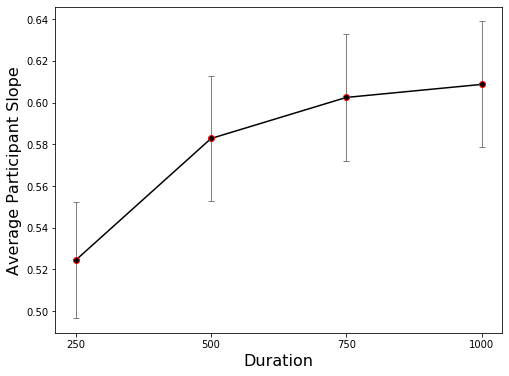

In [383]:
avg_slope_250 = np.mean(np.array(slopes_250['slope']))
ste_avg_slope_250 = stats.sem(np.array(slopes_250['slope']))

avg_slope_500 = np.mean(np.array(slopes_500['slope']))
ste_avg_slope_500 = stats.sem(np.array(slopes_500['slope']))

avg_slope_750 = np.mean(np.array(slopes_750['slope']))
ste_avg_slope_750 = stats.sem(np.array(slopes_750['slope']))

avg_slope_1000 = np.mean(np.array(slopes_1000['slope']))
ste_avg_slope_1000 = stats.sem(np.array(slopes_1000['slope']))

avg_stes = [ste_avg_slope_250, ste_avg_slope_500, ste_avg_slope_750, ste_avg_slope_1000]
avgslopes = [avg_slope_250, avg_slope_500, avg_slope_750, avg_slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 6])
plt.plot(xAxis,avgslopes, color="black")
plt.errorbar(xAxis, avgslopes, yerr=avg_stes, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "red", capsize = 3)

plt.xlabel('Duration', fontsize=16)
plt.ylabel('Average Participant Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

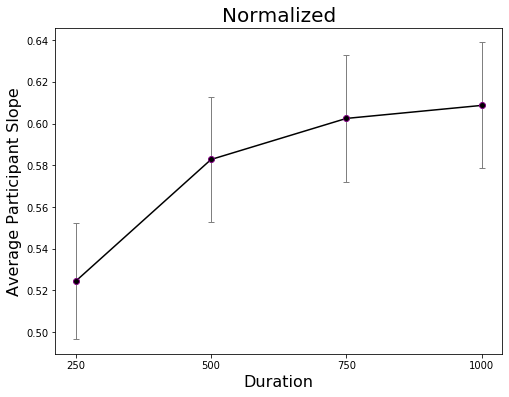

In [384]:
n_avg_slope_250 = np.mean(np.array(n_slopes_250['slope']))
n_ste_avg_slope_250 = stats.sem(np.array(n_slopes_250['slope']))

n_avg_slope_500 = np.mean(np.array(n_slopes_500['slope']))
n_ste_avg_slope_500 = stats.sem(np.array(n_slopes_500['slope']))

n_avg_slope_750 = np.mean(np.array(n_slopes_750['slope']))
n_ste_avg_slope_750 = stats.sem(np.array(n_slopes_750['slope']))

n_avg_slope_1000 = np.mean(np.array(n_slopes_1000['slope']))
n_ste_avg_slope_1000 = stats.sem(np.array(n_slopes_1000['slope']))

n_avg_stes = [n_ste_avg_slope_250, n_ste_avg_slope_500, n_ste_avg_slope_750, n_ste_avg_slope_1000]
n_avgslopes = [n_avg_slope_250, n_avg_slope_500, n_avg_slope_750, n_avg_slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 6])
plt.plot(xAxis,avgslopes, color="black")
plt.errorbar(xAxis, avgslopes, yerr=avg_stes, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "purple", capsize = 3)

plt.xlabel('Duration', fontsize=16)
plt.ylabel('Average Participant Slope', fontsize=16)
plt.title("Normalized", fontsize = 20)

plt.show()

## Age 

In [415]:
def ANCOVA_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}
    subj_avgEstim = {'subjID': [], 'duration': [], 'avgEstim': [], 'age': []}
    
    subj_avg_slopes = {'subjID': [],'age': [], 'avg_slope': []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        
        subj_slopes_list = []
        
        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)
            
            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
            
            subj_avgEstim['subjID'].append(subj)
            subj_avgEstim['duration'].append(duration)
            subj_avgEstim['avgEstim'].append(np.mean(y))
            subj_avgEstim['age'].append(duration_subj_df.age.unique()[0])
            
            subj_slopes_list.append(slope)
        
        subj_avg_slopes['subjID'].append(subj)
        subj_avg_slopes['age'].append(subj_df.age.unique()[0])
        subj_avg_slopes['avg_slope'].append(np.mean(np.array(subj_slopes_list)))
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
    avgEstim_df = pd.DataFrame(data=subj_avgEstim)
    avgSlope_df = pd.DataFrame(data=subj_avg_slopes)
        
    return slope_df, intercept_df, avgEstim_df, avgSlope_df

In [401]:
df_age_slope, df_age_intercept, df_age_avgEstim, df_age_avgSlope = ANCOVA_subjectData(final_data)

In [402]:
df_age_slope_250 = df_age_slope.loc[df_age_slope['duration'] == 250] 
df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

df_age_slope_500 = df_age_slope.loc[df_age_slope['duration'] == 500] 
df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

df_age_slope_750 = df_age_slope.loc[df_age_slope['duration'] == 750] 
df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

df_age_slope_1000 = df_age_slope.loc[df_age_slope['duration'] == 1000] 
df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

In [403]:
df_age_avgSlope

subjID  age  avg_slope
0    710814   44   0.422495
1    665311   25   0.171579
2    401808   36   0.883936
3    811430   26   0.439292
4    614349   55   1.020265
..      ...  ...        ...
187  419765   39   0.695918
188  274866   36   0.631438
189  725568   40   0.947400
190  773761   32   0.618853
191  107287   25   0.011195

[192 rows x 3 columns]

m: [0.00683484]
b: 0.3214939132359256
R-squared:  0.03300817422240376


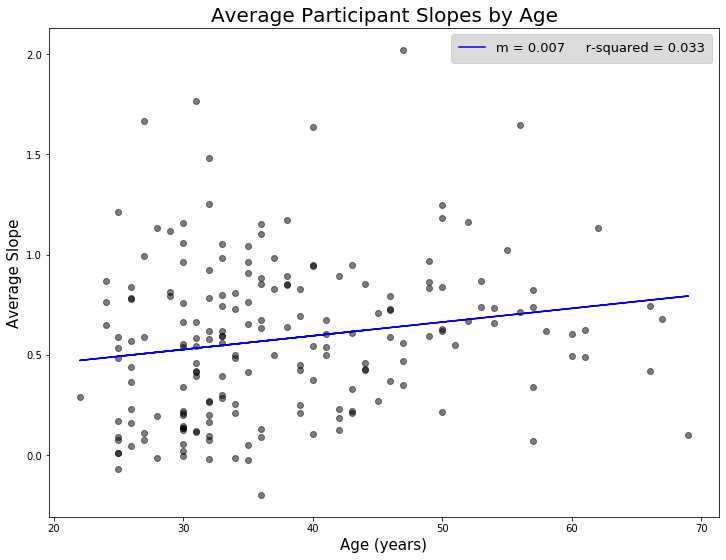

In [404]:
plt.figure(figsize = [12,9])

#run regression
age_vals = np.array(df_age_avgSlope['age']).reshape(-1,1)
age_reg = LinearRegression().fit(age_vals, np.array(df_age_avgSlope['avg_slope']))
                   
#Plot Our Actual and Predicted Values
plt.plot(age_vals, np.array(df_age_avgSlope['avg_slope']), 'o', color='black', alpha = 0.5);
plt.plot(age_vals,age_reg.predict(age_vals),color='b', label = 'm = ' + str(round(age_reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(age_reg.score(age_vals, np.array(df_age_avgSlope['avg_slope']))), 3)))

plt.title("Average Participant Slopes by Age",  fontsize = 20)
plt.xlabel("Age (years)", fontsize = 15)
plt.ylabel("Average Slope", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(age_reg.coef_))
print("b: {0}".format(age_reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", age_reg.score(age_vals, np.array(df_age_avgSlope['avg_slope'])))



plt.show()

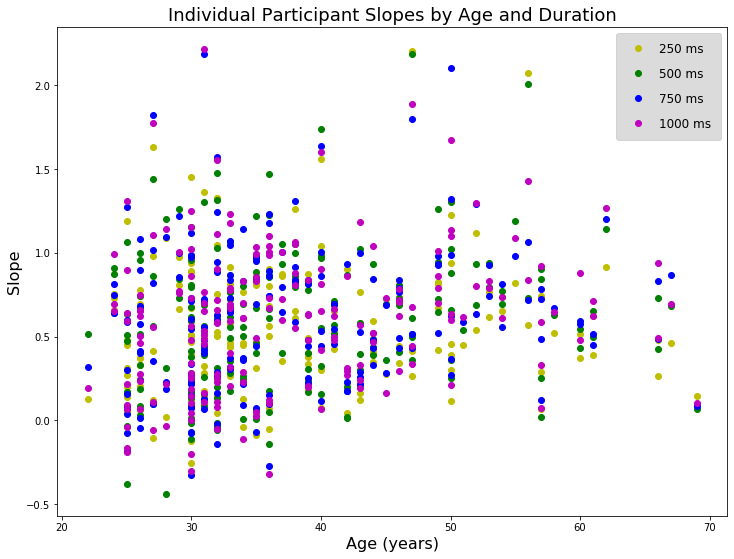

In [405]:
plt.figure(figsize = [12,9])
plt.title('Individual Participant Slopes by Age and Duration', fontsize = 18)
plt.ylabel('Slope', fontsize = 16)
plt.xlabel('Age (years)', fontsize = 16)
plt.plot(np.array(df_age_slope_250['age']), np.array(df_age_slope_250['slope']), 'yo', label='250 ms')
plt.plot(np.array(df_age_slope_500['age']), np.array(df_age_slope_500['slope']), 'go', label='500 ms')
plt.plot(np.array(df_age_slope_750['age']), np.array(df_age_slope_750['slope']), 'bo', label='750 ms')
plt.plot(np.array(df_age_slope_1000['age']), np.array(df_age_slope_1000['slope']), 'mo', label='1000 ms')

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.show()

m: [0.00474792]
b: 0.345140696343765
R-squared:  0.016251143325477946


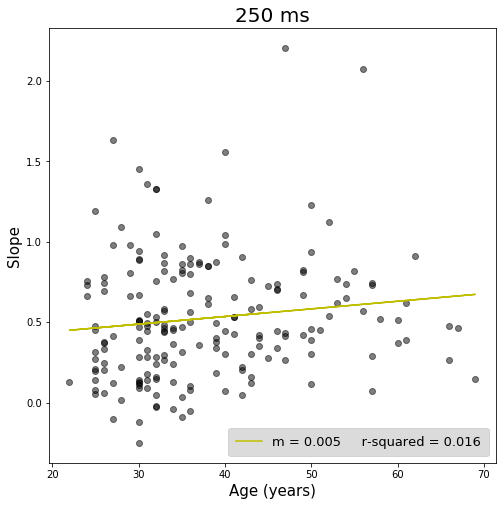

In [406]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
age_250 = np.array(df_age_slope_250['age']).reshape(-1,1)
age_reg_250 = LinearRegression().fit(age_250, np.array(df_age_slope_250['slope']))

#Generated Predictions = age_reg_250.predict(age_250)
                   
#Plot Our Actual and Predicted Values
plt.plot(age_250, np.array(df_age_slope_250['slope']), 'o', color='black', alpha = 0.5);
plt.plot(age_250,age_reg_250.predict(age_250),color='y', label = 'm = ' + str(round(age_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(age_reg_250.score(age_250, np.array(df_age_slope_250['slope']))), 3)))

plt.title("250 ms",  fontsize = 20)
plt.xlabel("Age (years)", fontsize = 15)
plt.ylabel("Slope", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(age_reg_250.coef_))
print("b: {0}".format(age_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", age_reg_250.score(age_250, np.array(df_age_slope_250['slope'])))

m: [0.00790215]
b: 0.28436222371666237
R-squared:  0.03909033035337417


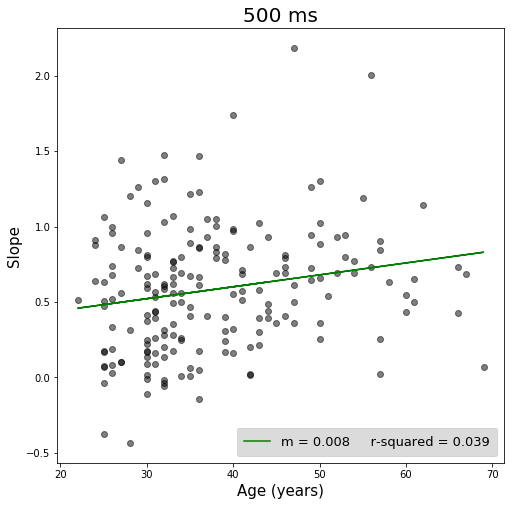

In [407]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
age_500 = np.array(df_age_slope_500['age']).reshape(-1,1)
age_reg_500 = LinearRegression().fit(age_500, np.array(df_age_slope_500['slope']))

#Generated Predictions = age_reg_250.predict(age_250)
                   
#Plot Our Actual and Predicted Values
plt.plot(age_500, np.array(df_age_slope_500['slope']), 'o', color='black', alpha = 0.5);
plt.plot(age_500,age_reg_500.predict(age_500),color='g', label = 'm = ' + str(round(age_reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(age_reg_500.score(age_500, np.array(df_age_slope_500['slope']))), 3)))

plt.title("500 ms",  fontsize = 20)
plt.xlabel("Age (years)", fontsize = 15)
plt.ylabel("Slope", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(age_reg_500.coef_))
print("b: {0}".format(age_reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", age_reg_500.score(age_500, np.array(df_age_slope_500['slope'])))

m: [0.0068513]
b: 0.3437470191625127
R-squared:  0.028088131013556672


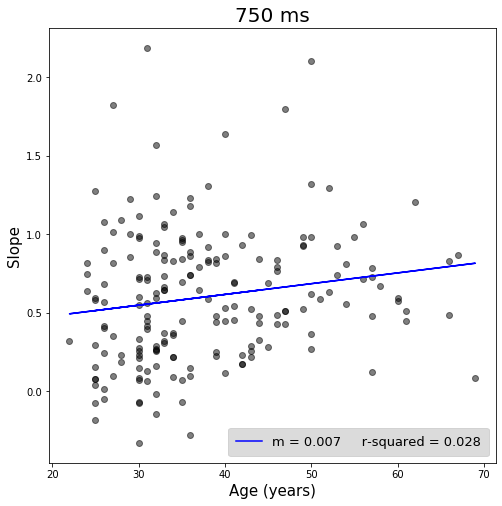

In [408]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
age_750 = np.array(df_age_slope_750['age']).reshape(-1,1)
age_reg_750 = LinearRegression().fit(age_750, np.array(df_age_slope_750['slope']))

#Generated Predictions = age_reg_250.predict(age_250)
                   
#Plot Our Actual and Predicted Values
plt.plot(age_750, np.array(df_age_slope_750['slope']), 'o', color='black', alpha = 0.5);
plt.plot(age_750,age_reg_750.predict(age_750),color='b', label = 'm = ' + str(round(age_reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(age_reg_750.score(age_750, np.array(df_age_slope_750['slope']))), 3)))

plt.title("750 ms",  fontsize = 20)
plt.xlabel("Age (years)", fontsize = 15)
plt.ylabel("Slope", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(age_reg_750.coef_))
print("b: {0}".format(age_reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", age_reg_750.score(age_750, np.array(df_age_slope_750['slope'])))

m: [0.00783797]
b: 0.31272571372076224
R-squared:  0.037378217760005605


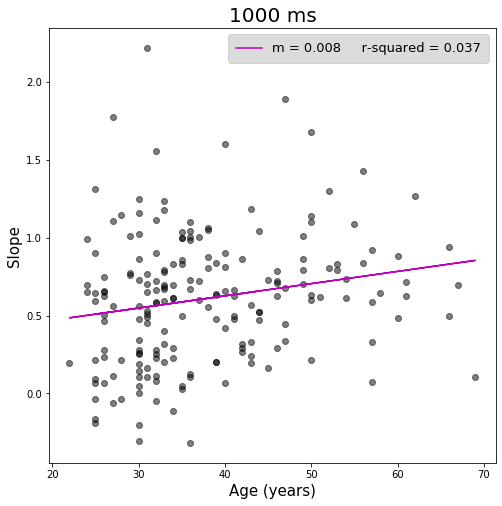

In [409]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
age_1000 = np.array(df_age_slope_1000['age']).reshape(-1,1)
age_reg_1000 = LinearRegression().fit(age_1000, np.array(df_age_slope_1000['slope']))

#Generated Predictions = age_reg_250.predict(age_250)
                   
#Plot Our Actual and Predicted Values
plt.plot(age_1000, np.array(df_age_slope_1000['slope']), 'o', color='black', alpha = 0.5);
plt.plot(age_1000,age_reg_1000.predict(age_1000),color='m', label = 'm = ' + str(round(age_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(age_reg_1000.score(age_1000, np.array(df_age_slope_1000['slope']))), 3)))

plt.title("1000 ms",  fontsize = 20)
plt.xlabel("Age (years)", fontsize = 15)
plt.ylabel("Slope", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(age_reg_1000.coef_))
print("b: {0}".format(age_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", age_reg_1000.score(age_1000, np.array(df_age_slope_1000['slope'])))

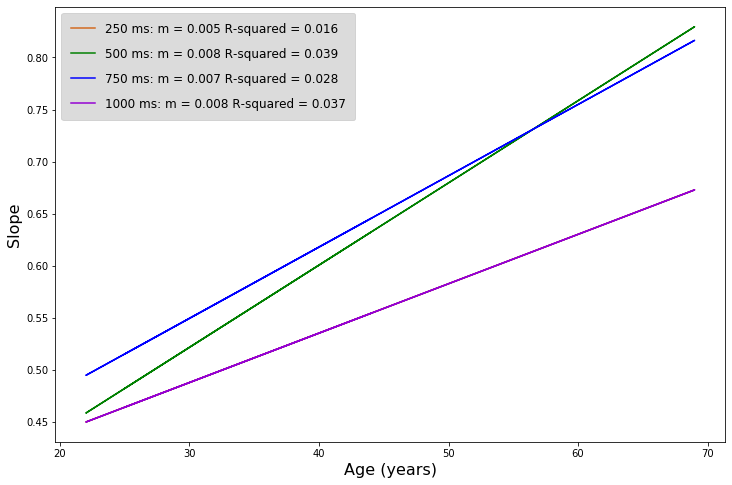

In [410]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(age_250,age_reg_250.predict(age_250),color='chocolate', label = '250 ms: '
        + "m = " + str(round(age_reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(age_reg_250.score(age_250, np.array(df_age_slope_250['slope'])), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(age_500,age_reg_500.predict(age_500),color='green', label = '500 ms: '
        + "m = " + str(round(age_reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(age_reg_500.score(age_500, np.array(df_age_slope_500['slope'])), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(age_750,age_reg_750.predict(age_750),color='blue', label = '750 ms: '
        + "m = " + str(round(age_reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(age_reg_750.score(age_750, np.array(df_age_slope_750['slope'])), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(age_1000,age_reg_250.predict(age_250),color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(age_reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(age_reg_1000.score(age_1000, np.array(df_age_slope_1000['slope'])), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Age (years)", fontsize = 16)
plt.ylabel("Slope", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


plt.show()

0.024538445036327662
0.04535578977096463
0.045738288734359665
0.09617282799310926


/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


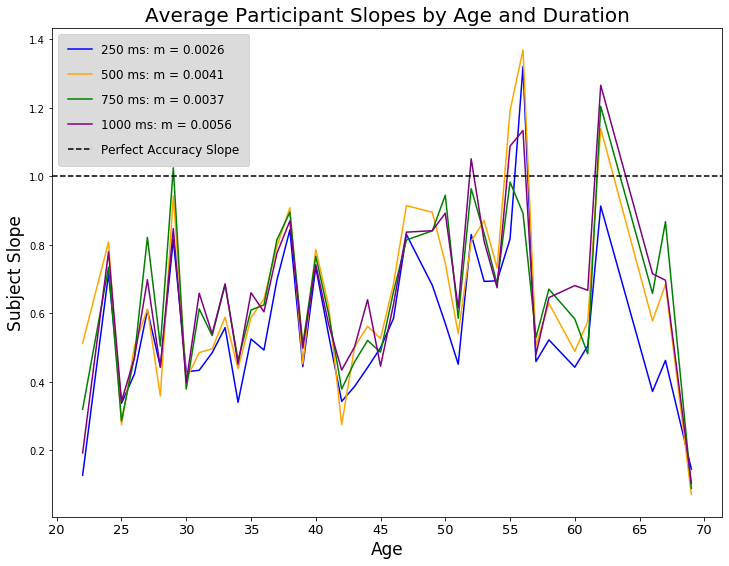

In [411]:
plt.figure(figsize = [12, 9])
plt.xticks(np.arange(20, 80, 5), fontsize = 13)
plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)
plt.title('Average Participant Slopes by Age and Duration', fontsize = 20)

ages = df_age_slope_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

In [412]:
df_age_avgEstim_250 = df_age_avgEstim.loc[df_age_avgEstim['duration'] == 250] 
df_age_avgEstim_250_mean = df_age_avgEstim_250.groupby('age').mean()

df_age_avgEstim_500 = df_age_avgEstim.loc[df_age_avgEstim['duration'] == 500] 
df_age_avgEstim_500_mean = df_age_avgEstim_500.groupby('age').mean()

df_age_avgEstim_750 = df_age_avgEstim.loc[df_age_avgEstim['duration'] == 750] 
df_age_avgEstim_750_mean = df_age_avgEstim_750.groupby('age').mean()

df_age_avgEstim_1000 = df_age_avgEstim.loc[df_age_avgEstim['duration'] == 1000] 
df_age_avgEstim_1000_mean = df_age_avgEstim_1000.groupby('age').mean()

0.000733353383375149
0.000176636960545284
0.0008413470589841849
1.8829147446460626e-06


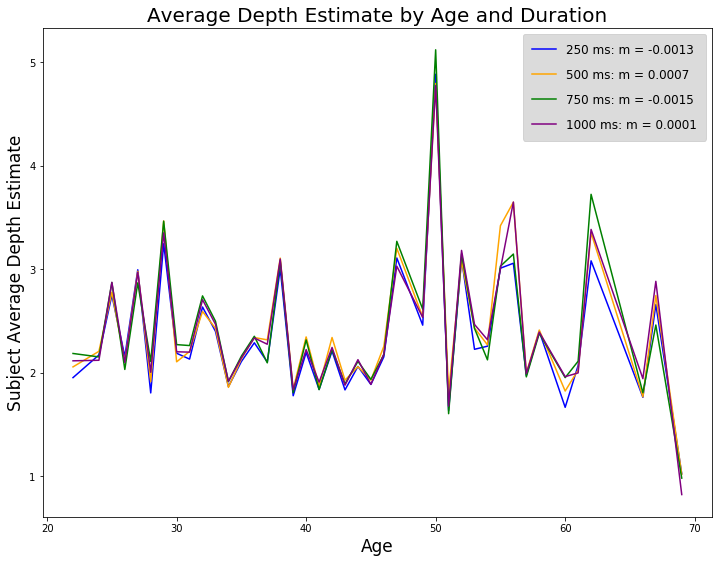

In [413]:
plt.figure(figsize = [12, 9])
# plt.xticks(np.arange(20, 80, 5), fontsize = 13)
# plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Average Depth Estimate", fontsize = 17)
plt.title('Average Depth Estimate by Age and Duration', fontsize = 20)


ages = df_age_avgEstim_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_avgEstim_250_mean['avgEstim'])
plt.plot(ages, df_age_avgEstim_250_mean['avgEstim'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_avgEstim_500_mean['avgEstim'])
plt.plot(ages, df_age_avgEstim_500_mean['avgEstim'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_avgEstim_750_mean['avgEstim'])
plt.plot(ages, df_age_avgEstim_750_mean['avgEstim'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_avgEstim_1000_mean['avgEstim'])
plt.plot(ages, df_age_avgEstim_1000_mean['avgEstim'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

# plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

In [416]:
norm_df_age_slope, norm_df_age_intercept, norm_df_age_avgEstim, norm_df_age_avgSlope = ANCOVA_subjectData(normalized_data)

In [417]:
df_age_slope_250 = norm_df_age_slope.loc[df_age_slope['duration'] == 250] 
df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

df_age_slope_500 = norm_df_age_slope.loc[df_age_slope['duration'] == 500] 
df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

df_age_slope_750 = norm_df_age_slope.loc[df_age_slope['duration'] == 750] 
df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

df_age_slope_1000 = norm_df_age_slope.loc[df_age_slope['duration'] == 1000] 
df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

In [482]:
import sys
!{sys.executable} -m pip install pingouin

  Using cached https://files.pythonhosted.org/packages/7d/b7/fe73ce8909193840ca9754409c3f65053ef6870d59a8c065abc9cc93d286/pingouin-0.4.0.tar.gz
     |████████████████████████████████| 16.9MB 8.7MB/s eta 0:00:01
     |████████████████████████████████| 32.6MB 1.6MB/s eta 0:00:01
     |████████████████████████████████| 11.3MB 7.7MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/9e/5e/4a2ade283411d1f46d6f8dd5fe951b9152062d55a20750cd5d4b556322bf/statsmodels-0.13.0.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/9a/57/7fbcff4c0961ed190ac5fcb0bd8194152ee1ee6487edf64fdbae16e2bc4b/pandas_flavor-0.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fd/f6/95588d496e518355c33b389222c99069b1c6f2c046be64f400072fdc7cda/outdated-0.2.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/80/7c0

https://pingouin-stats.org/generated/pingouin.ancova.html

In [418]:
from pingouin import ancova, read_dataset

print("Raw Data")
print("DV: Slope")

ancova(data=df_age_slope, dv='slope', covar='age', between='duration')

Raw Data
DV: Slope


Source          SS   DF          F     p-unc       np2
0  duration    0.849495    3   1.737748  0.157798  0.006786
1       age    3.800815    1  23.325128  0.000002  0.029663
2  Residual  124.330389  763        NaN       NaN       NaN

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [419]:
print("Raw Data")
print("DV: Intercept")
ancova(data=df_age_intercept, dv='intercept', covar='age', between='duration')

Raw Data
DV: Intercept


Source           SS   DF          F     p-unc       np2
0  duration     4.371264    3   0.857539  0.462778  0.003360
1       age    21.172761    1  12.460793  0.000441  0.016069
2  Residual  1296.451672  763        NaN       NaN       NaN

In [494]:
print("Raw Data")
print("DV: Average Depth Estimate")
ancova(data=df_age_avgEstim, dv='avgEstim', covar='age', between='duration')

Raw Data
DV: Average Depth Estimate


Source           SS   DF         F     p-unc       np2
0  duration     0.388102    3  0.076207  0.972822  0.000295
1       age     2.351310    1  1.385100  0.239596  0.001784
2  Residual  1315.620136  775       NaN       NaN       NaN

In [420]:
print("DV: Normalized Slope")
ancova(data=norm_df_age_slope, dv='slope', covar='age', between='duration')

DV: Normalized Slope


Source         SS   DF          F         p-unc       np2
0  duration   0.148540    3   2.873441  3.546748e-02  0.011172
1       age   0.432939    1  25.125075  6.684141e-07  0.031880
2  Residual  13.147528  763        NaN           NaN       NaN

In [496]:
print("DV: Normalized Intercept")
ancova(data=norm_df_age_intercept, dv='intercept', covar='age', between='duration')

DV: Normalized Intercept


Source          SS   DF          F         p-unc       np2
0  duration    0.726469    3   1.567436  1.958633e-01  0.006031
1       age    4.166749    1  26.970631  2.642359e-07  0.033630
2  Residual  119.731359  775        NaN           NaN       NaN

In [421]:
print("DV: Normalized Average Depth Estimate")
ancova(data=norm_df_age_avgEstim, dv='avgEstim', covar='age', between='duration')

DV: Normalized Average Depth Estimate


Source        SS   DF          F     p-unc       np2
0  duration  0.093553    3  10.292701  0.000001  0.038895
1       age  0.000006    1   0.001928  0.964991  0.000003
2  Residual  2.311709  763        NaN       NaN       NaN

0.03116231202665777
0.05104197937257575
0.08101799831255208
0.14468669227423628


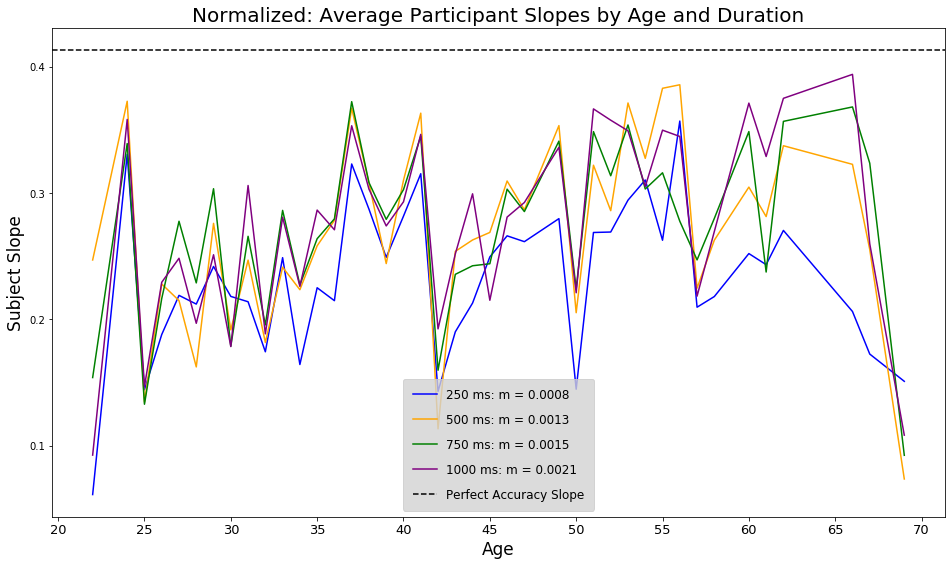

In [498]:
plt.figure(figsize = [16, 9])
plt.xticks(np.arange(20, 80, 5), fontsize = 13)
plt.yticks(np.arange(0, 1.8, 0.1))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)

ages = df_age_slope_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

plt.axhline(y=1/average_depth_estimate, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")

plt.title('Normalized: Average Participant Slopes by Age and Duration', fontsize = 20)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

## Gender

In [422]:
gender_dict = {}
for subj in final_data.subjID.unique():
    subjDF = final_data.loc[final_data['subjID'] == subj]
    gender = subjDF.gender.unique()[0]
    if gender not in gender_dict.keys():
        if gender == '3 15 65':
            gender_dict['Prefer not to say'] = 1
        else:
            gender_dict[gender] = 1
    else:
        if gender == '3 15 65':
            gender_dict['Prefer not to say'] += 1
        else:
            gender_dict[gender] += 1

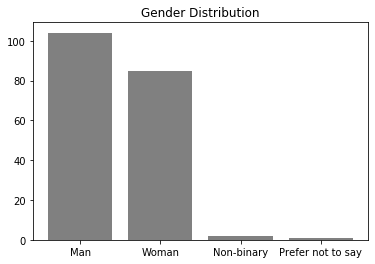

In [423]:
plt.figure();
plt.title('Gender Distribution')
plt.bar(list(gender_dict.keys()), gender_dict.values(), color='gray')
plt.show();

In [424]:
def Gender_ANCOVA_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'gender': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'gender': []}
    subj_avgEstim = {'subjID': [], 'duration': [], 'avgEstim': [], 'gender': []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)
            
            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['gender'].append(duration_subj_df.gender.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['gender'].append(duration_subj_df.gender.unique()[0])
            
            subj_avgEstim['subjID'].append(subj)
            subj_avgEstim['duration'].append(duration)
            subj_avgEstim['avgEstim'].append(np.mean(y))
            subj_avgEstim['gender'].append(duration_subj_df.gender.unique()[0])


                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
    avgEstim_df = pd.DataFrame(data=subj_avgEstim)
        
    return slope_df, intercept_df, avgEstim_df

In [425]:
df_gender_slope, df_gender_intercept, df_gender_avgEstim = Gender_ANCOVA_subjectData(final_data) 

In [426]:
n_df_gender_slope, n_df_gender_intercept, n_df_gender_avgEstim = Gender_ANCOVA_subjectData(normalized_data) 

In [427]:
# df_gender_slope_250.groupby('gender').sem()

In [428]:
df_gender_slope_250 = df_gender_slope.loc[df_gender_slope['duration'] == 250] 
df_gender_slope_250_mean = df_gender_slope_250.groupby('gender').mean()
df_gender_slope_250_ste = df_gender_slope_250.groupby('gender').sem()

df_gender_slope_500 = df_gender_slope.loc[df_gender_slope['duration'] == 500] 
df_gender_slope_500_mean = df_gender_slope_500.groupby('gender').mean()
df_gender_slope_500_ste = df_gender_slope_500.groupby('gender').sem()


df_gender_slope_750 = df_gender_slope.loc[df_gender_slope['duration'] == 750] 
df_gender_slope_750_mean = df_gender_slope_750.groupby('gender').mean()
df_gender_slope_750_ste = df_gender_slope_750.groupby('gender').sem()


df_gender_slope_1000 = df_gender_slope.loc[df_gender_slope['duration'] == 1000] 
df_gender_slope_1000_mean = df_gender_slope_1000.groupby('gender').mean()
df_gender_slope_1000_ste = df_gender_slope_1000.groupby('gender').sem()

In [429]:
n_df_gender_slope_250 = n_df_gender_slope.loc[n_df_gender_slope['duration'] == 250] 
n_df_gender_slope_250_mean = n_df_gender_slope_250.groupby('gender').mean()
n_df_gender_slope_250_ste = n_df_gender_slope_250.groupby('gender').sem()

n_df_gender_slope_500 = n_df_gender_slope.loc[n_df_gender_slope['duration'] == 500] 
n_df_gender_slope_500_mean = n_df_gender_slope_500.groupby('gender').mean()
n_df_gender_slope_500_ste = n_df_gender_slope_500.groupby('gender').sem()


n_df_gender_slope_750 = n_df_gender_slope.loc[n_df_gender_slope['duration'] == 750] 
n_df_gender_slope_750_mean = n_df_gender_slope_750.groupby('gender').mean()
n_df_gender_slope_750_ste = n_df_gender_slope_750.groupby('gender').sem()


n_df_gender_slope_1000 = n_df_gender_slope.loc[n_df_gender_slope['duration'] == 1000] 
n_df_gender_slope_1000_mean = n_df_gender_slope_1000.groupby('gender').mean()
n_df_gender_slope_1000_ste = n_df_gender_slope_1000.groupby('gender').sem()

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


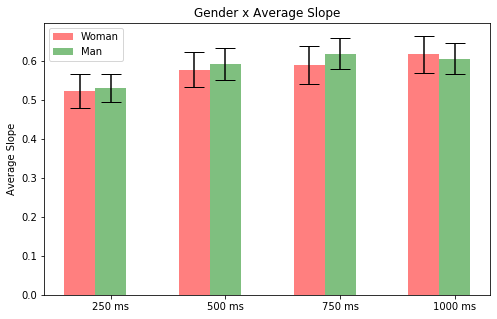

In [430]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.27      # the width of the bars

fig = plt.figure(figsize=[8, 5])
plt.title('Gender x Average Slope')
ax = fig.add_subplot(111)

yvals = [df_gender_slope_250_mean['slope']['Woman'], df_gender_slope_500_mean['slope']['Woman'], 
         df_gender_slope_750_mean['slope']['Woman'], df_gender_slope_1000_mean['slope']['Woman']]
woman_sems = [df_gender_slope_250_ste['slope']['Woman'], df_gender_slope_500_ste['slope']['Woman'], 
             df_gender_slope_750_ste['slope']['Woman'], df_gender_slope_1000_ste['slope']['Woman']]

rects1 = ax.bar(ind, yvals, yerr=woman_sems, color='r', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


zvals = [df_gender_slope_250_mean['slope']['Man'], df_gender_slope_500_mean['slope']['Man'], 
         df_gender_slope_750_mean['slope']['Man'], df_gender_slope_1000_mean['slope']['Man']]
man_sems = [df_gender_slope_250_ste['slope']['Man'], df_gender_slope_500_ste['slope']['Man'], 
             df_gender_slope_750_ste['slope']['Man'], df_gender_slope_1000_ste['slope']['Man']]

rects2 = ax.bar(ind+width, zvals, yerr=man_sems, color='g', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


# kvals = yvals = [df_gender_slope_250_mean['slope']['Non-binary'], df_gender_slope_500_mean['slope']['Non-binary'], 
#          df_gender_slope_750_mean['slope']['Non-binary'], df_gender_slope_1000_mean['slope']['Non-binary']]
# nonbinary_sems = [df_gender_slope_250_ste['slope']['Non-binary'], df_gender_slope_500_ste['slope']['Non-binary'], 
#              df_gender_slope_750_ste['slope']['Non-binary'], df_gender_slope_1000_ste['slope']['Non-binary']]

# rects3 = ax.bar(ind+width*2, kvals, yerr=nonbinary_sems, color='b', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


ax.set_ylabel('Average Slope')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('250 ms', '500 ms', '750 ms', '1000 ms') )
ax.legend( (rects1[0], rects2[0]), ('Woman', 'Man', 'Non-binary') )

plt.show();

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


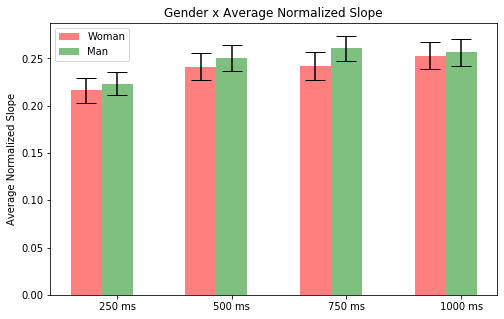

In [431]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.27      # the width of the bars

fig = plt.figure(figsize=[8, 5])
plt.title('Gender x Average Normalized Slope')
ax = fig.add_subplot(111)

n_yvals = [n_df_gender_slope_250_mean['slope']['Woman'], n_df_gender_slope_500_mean['slope']['Woman'], 
         n_df_gender_slope_750_mean['slope']['Woman'], n_df_gender_slope_1000_mean['slope']['Woman']]
n_woman_sems = [n_df_gender_slope_250_ste['slope']['Woman'], n_df_gender_slope_500_ste['slope']['Woman'], 
             n_df_gender_slope_750_ste['slope']['Woman'], n_df_gender_slope_1000_ste['slope']['Woman']]

n_rects1 = ax.bar(ind, n_yvals, yerr=n_woman_sems, color='r', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


n_zvals = [n_df_gender_slope_250_mean['slope']['Man'], n_df_gender_slope_500_mean['slope']['Man'], 
         n_df_gender_slope_750_mean['slope']['Man'], n_df_gender_slope_1000_mean['slope']['Man']]
n_man_sems = [n_df_gender_slope_250_ste['slope']['Man'], n_df_gender_slope_500_ste['slope']['Man'], 
             n_df_gender_slope_750_ste['slope']['Man'], n_df_gender_slope_1000_ste['slope']['Man']]

n_rects2 = ax.bar(ind+width, n_zvals, yerr=n_man_sems, color='g', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


# kvals = yvals = [df_gender_slope_250_mean['slope']['Non-binary'], df_gender_slope_500_mean['slope']['Non-binary'], 
#          df_gender_slope_750_mean['slope']['Non-binary'], df_gender_slope_1000_mean['slope']['Non-binary']]
# nonbinary_sems = [df_gender_slope_250_ste['slope']['Non-binary'], df_gender_slope_500_ste['slope']['Non-binary'], 
#              df_gender_slope_750_ste['slope']['Non-binary'], df_gender_slope_1000_ste['slope']['Non-binary']]

# rects3 = ax.bar(ind+width*2, kvals, yerr=nonbinary_sems, color='b', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


ax.set_ylabel('Average Normalized Slope')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('250 ms', '500 ms', '750 ms', '1000 ms') )
ax.legend( (n_rects1[0], n_rects2[0]), ('Woman', 'Man') )

plt.show();

In [432]:
df_gender_avgEstim_250 = df_gender_avgEstim.loc[df_gender_avgEstim['duration'] == 250] 
df_gender_avgEstim_250_mean = df_gender_avgEstim_250.groupby('gender').mean()
df_gender_avgEstim_250_ste = df_gender_avgEstim_250.groupby('gender').sem()

df_gender_avgEstim_500 = df_gender_avgEstim.loc[df_gender_avgEstim['duration'] == 500] 
df_gender_avgEstim_500_mean = df_gender_avgEstim_500.groupby('gender').mean()
df_gender_avgEstim_500_ste = df_gender_avgEstim_500.groupby('gender').sem()

df_gender_avgEstim_750 = df_gender_avgEstim.loc[df_gender_avgEstim['duration'] == 750] 
df_gender_avgEstim_750_mean = df_gender_avgEstim_750.groupby('gender').mean()
df_gender_avgEstim_750_ste = df_gender_avgEstim_750.groupby('gender').sem()

df_gender_avgEstim_1000 = df_gender_avgEstim.loc[df_gender_avgEstim['duration'] == 1000] 
df_gender_avgEstim_1000_mean = df_gender_avgEstim_1000.groupby('gender').mean()
df_gender_avgEstim_1000_ste = df_gender_avgEstim_1000.groupby('gender').sem()

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


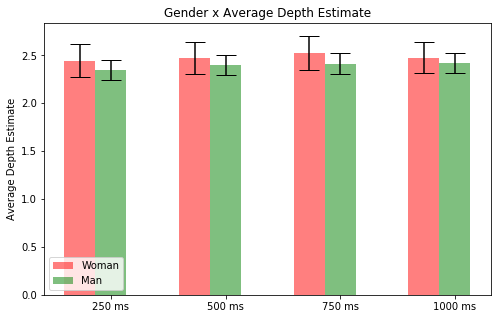

In [433]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=[8,5])
plt.title('Gender x Average Depth Estimate')
ax = fig.add_subplot(111)

yvals = [df_gender_avgEstim_250_mean['avgEstim']['Woman'], df_gender_avgEstim_500_mean['avgEstim']['Woman'], 
         df_gender_avgEstim_750_mean['avgEstim']['Woman'], df_gender_avgEstim_1000_mean['avgEstim']['Woman']]
woman_sems = [df_gender_avgEstim_250_ste['avgEstim']['Woman'], df_gender_avgEstim_500_ste['avgEstim']['Woman'], 
             df_gender_avgEstim_750_ste['avgEstim']['Woman'], df_gender_avgEstim_1000_ste['avgEstim']['Woman']]


rects1 = ax.bar(ind, yvals, yerr=woman_sems, color='r', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)

zvals = yvals = [df_gender_avgEstim_250_mean['avgEstim']['Man'], df_gender_avgEstim_500_mean['avgEstim']['Man'], 
         df_gender_avgEstim_750_mean['avgEstim']['Man'], df_gender_avgEstim_1000_mean['avgEstim']['Man']]
man_sems = [df_gender_avgEstim_250_ste['avgEstim']['Man'], df_gender_avgEstim_500_ste['avgEstim']['Man'], 
             df_gender_avgEstim_750_ste['avgEstim']['Man'], df_gender_avgEstim_1000_ste['avgEstim']['Man']]


rects2 = ax.bar(ind+width, zvals, yerr=man_sems, color='g', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)


# kvals = yvals = [df_gender_avgEstim_250_mean['avgEstim']['Non-binary'], df_gender_avgEstim_500_mean['avgEstim']['Non-binary'], 
#          df_gender_avgEstim_750_mean['avgEstim']['Non-binary'], df_gender_avgEstim_1000_mean['avgEstim']['Non-binary']]
# nonbinary_sems = [df_gender_avgEstim_250_ste['avgEstim']['Non-binary'], df_gender_avgEstim_500_ste['avgEstim']['Non-binary'], 
#              df_gender_avgEstim_750_ste['avgEstim']['Non-binary'], df_gender_avgEstim_1000_ste['avgEstim']['Non-binary']]


# rects3 = ax.bar(ind+width*2, kvals, yerr=nonbinary_sems, color='b', align='center', alpha=0.5, ecolor='black', capsize=10, width=width)

ax.set_ylabel('Average Depth Estimate')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('250 ms', '500 ms', '750 ms', '1000 ms') )
ax.legend( (rects1[0], rects2[0]), ('Woman', 'Man', 'Non-binary') )

# def autolabel(rects):
#     for rect in rects:
#         h = rect.get_height()
#         ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
#                 ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

plt.show();

Need to convert gender into a numerical variable

In [434]:
from pingouin import ancova, read_dataset

print("DV: Slope")
ancova(data=df_gender_slope, dv='slope', covar='gender', between='duration')

DV: Slope


AssertionError: covariate gender is not numeric

In [315]:
print("DV: Intercept")
ancova(data=df_gender_intercept, dv='intercept', covar='gender', between='duration')

DV: Intercept


NameError: name 'ancova' is not defined

In [316]:
print("DV: Average Depth Estimate")
ancova(data=df_gender_avgEstim, dv='avgEstim', covar='gender', between='duration')

DV: Average Depth Estimate


NameError: name 'ancova' is not defined

## Plot Duration Slopes

### Raw Data

In [523]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def linreg_duration(x, y, ste, duration):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value, std_err

In [524]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = raw_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.52604649]
b: 0.7901041576586703
R-squared:  0.6465039569515756


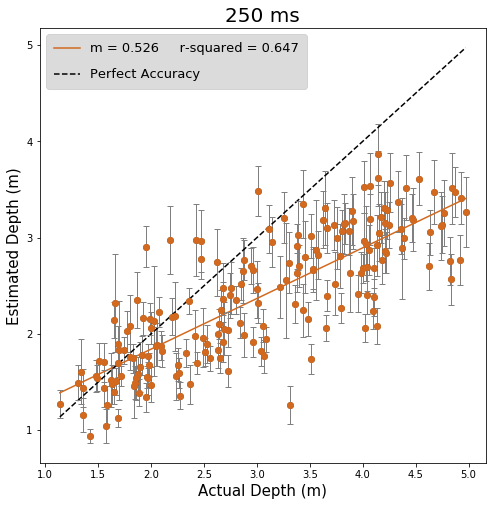

In [525]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(final_x_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.title("250 ms",  fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

Text(0, 0.5, 'Residual')

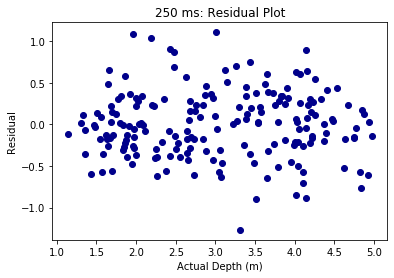

In [526]:
residuals_250 = y_250-y_predicted_250
plt.plot(X_250,residuals_250, 'o', color='darkblue')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [527]:
# http://www.hackdeploy.com/python-linear-regression-analysis/

In [528]:
slope_250 = linreg_duration(final_x_250, final_y_250, ste_250, 250)[0]
slope_250

0.526046490783905

m: [0.54540731]
b: 0.7974259347861932
R-squared:  0.5121805442049003


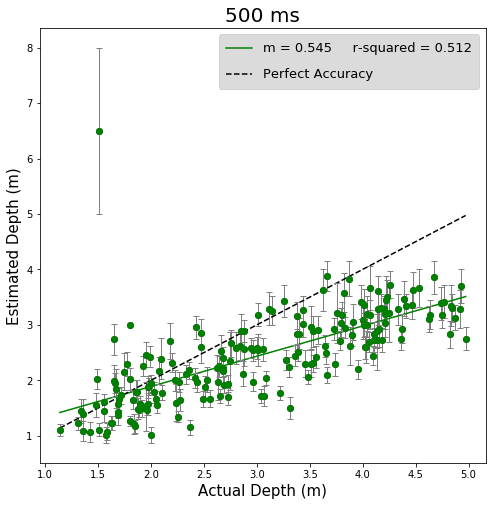

In [529]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_500 = np.array(final_x_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black', alpha = 0.7);
plt.plot(X_500,y_predicted_500,color='green', label = 'm = ' + str(round(reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_500.score(X_500, y_500)), 3)))
plt.title("500 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_500, y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

In [531]:
y_500.index(6.5)

8

In [532]:
X_500[8]

array([1.50433333])

Text(0, 0.5, 'Residual')

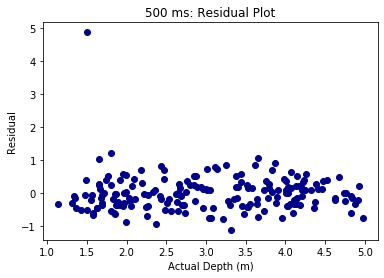

In [534]:
residuals_500 = y_500-y_predicted_500
plt.plot(X_500,residuals_500, 'o', color='darkblue')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [535]:
slope_500 = linreg_duration(final_x_500, final_y_500, ste_500, 500)[0]
slope_500

0.5454073060098156

m: [0.59060732]
b: 0.6617413121815583
R-squared:  0.6322020298407598


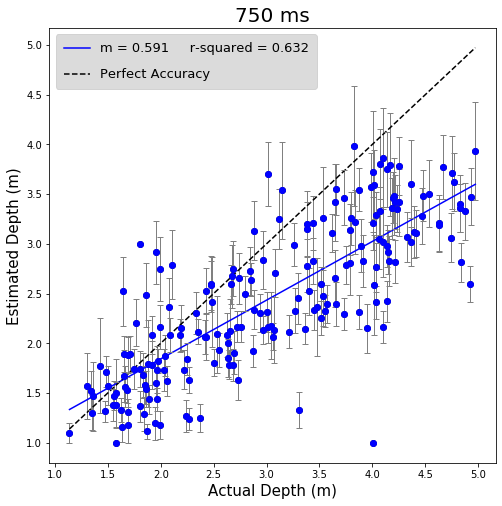

In [536]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_750 = np.array(final_x_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black', alpha = 0.7);
plt.plot(X_750,y_predicted_750,color='blue', label = 'm = ' + str(round(reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_750.score(X_750, y_750)), 3)))
plt.title("750 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_750, y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

Text(0, 0.5, 'Residual')

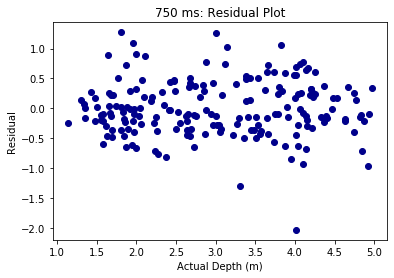

In [537]:
residuals_750 = y_750-y_predicted_750
plt.plot(X_750,residuals_750, 'o', color='darkblue')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [538]:
slope_750 = linreg_duration(final_x_750, final_y_750, ste_750, 750)[0]
slope_750

0.59060732159143

m: [0.60480624]
b: 0.5917479015146052
R-squared:  0.6669426421639434


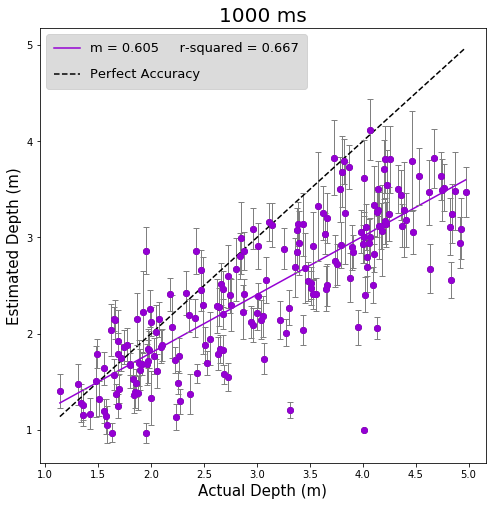

In [539]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(final_x_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))
plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

Text(0, 0.5, 'Residual')

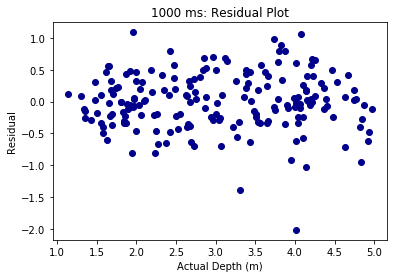

In [540]:
residuals_1000 = y_1000-y_predicted_1000
plt.plot(X_1000,residuals_1000, 'o', color='darkblue')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [541]:
slope_1000 = linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000)[0]
slope_1000

0.6048062375767904

#### Summary Plots for Non-Normalized Data

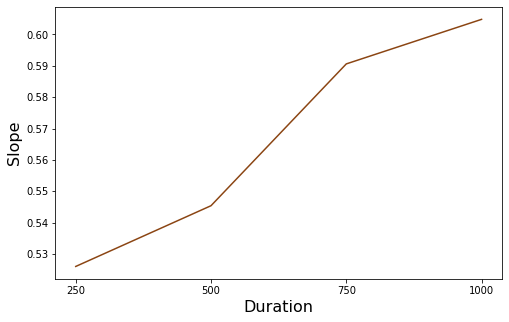

In [542]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 5])
plt.plot(xAxis,slopes, color="saddlebrown")
plt.xlabel('Duration', fontsize=16)
plt.ylabel('Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

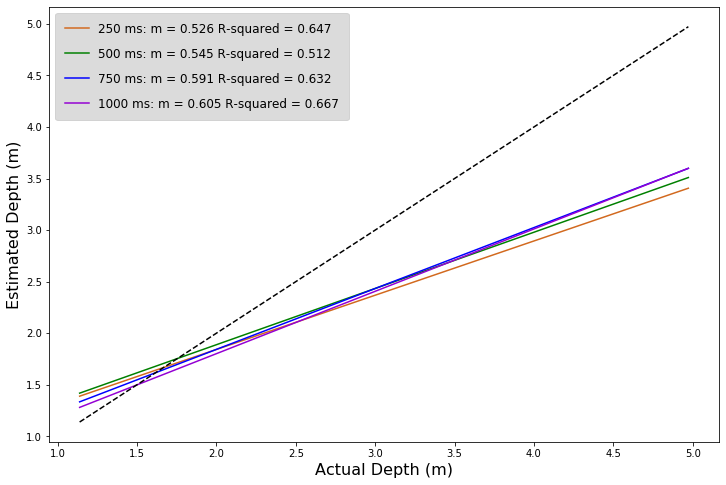

In [543]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

### Normalized Data

In [544]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_linreg_duration(x, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    
    return slope, intercept, r_value, p_value, std_err

In [545]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = normalized_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.2214248]
b: 0.3147426550770027
R-squared:  0.678724437438794


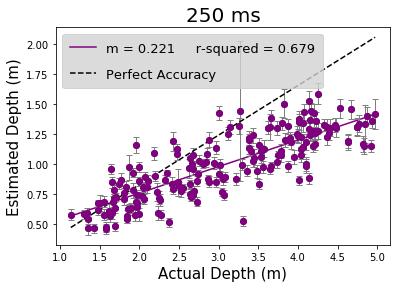

In [546]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_250 = np.array(final_x_250).reshape(-1,1)
n_y_250 = final_y_250
n_reg_250 = LinearRegression().fit(n_X_250, n_y_250)

#Generated Predictions
n_y_predicted_250 = n_reg_250.predict(n_X_250)
#Plot Our Actual and Predicted Values
plt.plot(n_X_250, n_y_250, 'o', color='black', alpha = 0.7);
plt.plot(n_X_250,n_y_predicted_250,color='purple', label = 'm = ' + str(round(n_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_250.score(n_X_250, n_y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_250, n_X_250/average_depth_estimate, 
         label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_250, final_y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(n_reg_250.coef_))
print("b: {0}".format(n_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_250.score(n_X_250, n_y_250))

Text(0, 0.5, 'Residual')

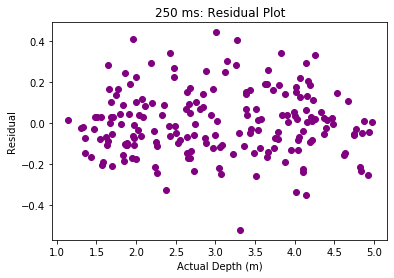

In [547]:
n_residuals_250 = n_y_250-n_y_predicted_250
plt.plot(n_X_250,n_residuals_250, 'o', color='purple')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [548]:
slope_250 = normalized_linreg_duration(final_x_250, final_y_250, ste_250, 250,
                                       average_depth_estimate)[0]

m: [0.22444141]
b: 0.3388032293317109
R-squared:  0.4511918851022948


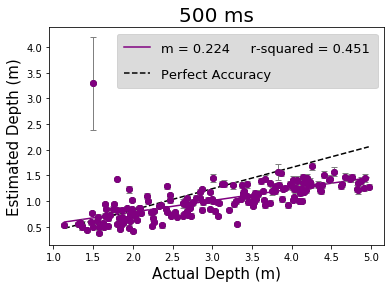

In [549]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_500 = np.array(final_x_500).reshape(-1,1)
n_y_500 = final_y_500
n_reg_500 = LinearRegression().fit(n_X_500, n_y_500)

#Generated Predictions
n_y_predicted_500 = n_reg_500.predict(n_X_500)
#Plot Our Actual and Predicted Values
plt.plot(n_X_500, n_y_500, 'o', color='black', alpha = 0.7);
plt.plot(n_X_500,n_y_predicted_500,color='purple',label = 'm = ' + str(round(n_reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_500.score(n_X_500, n_y_500)), 3)))
plt.title("500 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_500, n_X_500/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_500, final_y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_500.coef_))
print("b: {0}".format(n_reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_500.score(n_X_500, n_y_500))

Text(0, 0.5, 'Residual')

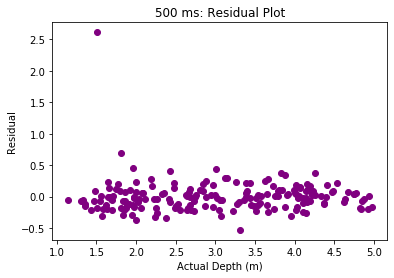

In [550]:
n_residuals_500 = n_y_500-n_y_predicted_500
plt.plot(n_X_500,n_residuals_500, 'o', color='purple')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [551]:
slope_500 = normalized_linreg_duration(final_x_500, final_y_500, ste_500, 500,
                                       average_depth_estimate)[0]

m: [0.24641947]
b: 0.2674160190252334
R-squared:  0.6679009163957149


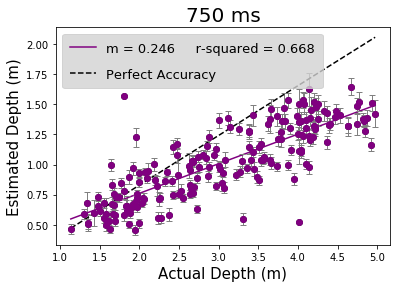

In [552]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_750 = np.array(final_x_750).reshape(-1,1)
n_y_750 = final_y_750
n_reg_750 = LinearRegression().fit(n_X_750, n_y_750)

#Generated Predictions
n_y_predicted_750 = n_reg_750.predict(n_X_750)
#Plot Our Actual and Predicted Values
plt.plot(n_X_750, n_y_750, 'o', color='black', alpha = 0.7);
plt.plot(n_X_750,n_y_predicted_750,color='purple', label = 'm = ' + str(round(n_reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_750.score(n_X_750, n_y_750)), 3)))
plt.title("750 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_750, n_X_750/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_750, final_y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_750.coef_))
print("b: {0}".format(n_reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_750.score(n_X_750, n_y_750))

Text(0, 0.5, 'Residual')

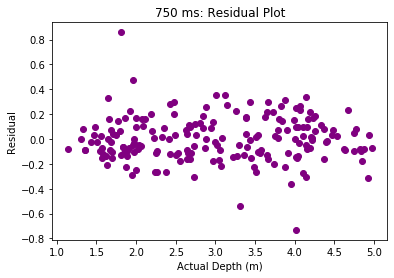

In [553]:
n_residuals_750 = n_y_750-n_y_predicted_750
plt.plot(n_X_750,n_residuals_750, 'o', color='purple')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [554]:
slope_750 = normalized_linreg_duration(final_x_750, final_y_750, ste_750, 750,
                                       average_depth_estimate)[0]

m: [0.25338917]
b: 0.24102768304189015
R-squared:  0.6862139311733424


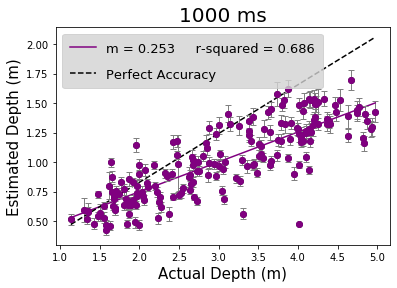

In [555]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_1000 = np.array(final_x_1000).reshape(-1,1)
n_y_1000 = final_y_1000
n_reg_1000 = LinearRegression().fit(n_X_1000, n_y_1000)

#Generated Predictions
n_y_predicted_1000 = n_reg_1000.predict(n_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(n_X_1000, n_y_1000, 'o', color='black', alpha = 0.7);
plt.plot(n_X_1000,n_y_predicted_1000,color='purple', label = 'm = ' + str(round(n_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_1000.score(n_X_1000, n_y_1000)), 3)))
plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_1000, final_y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(n_reg_1000.coef_))
print("b: {0}".format(n_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_1000.score(n_X_1000, n_y_1000))

Text(0, 0.5, 'Residual')

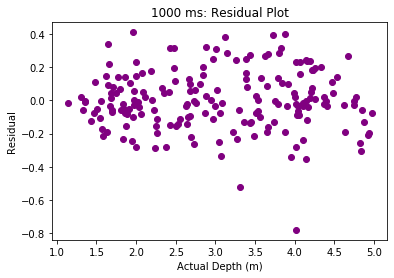

In [556]:
n_residuals_1000 = n_y_1000-n_y_predicted_1000
plt.plot(n_X_1000,n_residuals_1000, 'o', color='purple')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [557]:
slope_1000 = normalized_linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000,
                                       average_depth_estimate)[0]

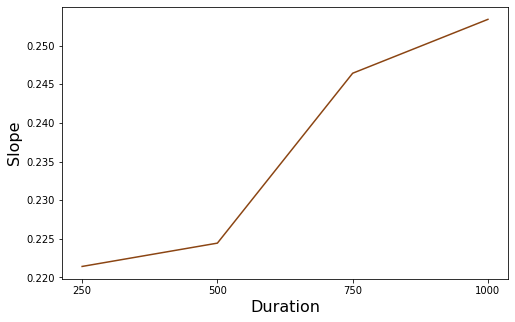

In [558]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 5])
plt.plot(xAxis,slopes, color="saddlebrown")
plt.xlabel('Duration', fontsize=16)
plt.ylabel('Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

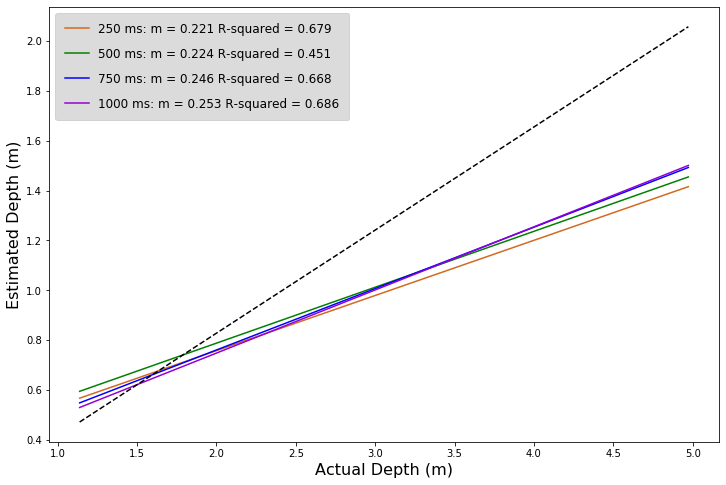

In [559]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(n_reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_250.score(n_X_250, n_y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(n_X_500,n_y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(n_reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_500.score(n_X_500, n_y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(n_X_750,n_y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(n_reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_750.score(n_X_750, n_y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(n_reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(n_reg_1000.score(n_X_1000, n_y_1000), 3)))

# plt.title("Normalized Data", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

## Individual Target Results

In [38]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables



In [39]:
raw_trial_pivot = trial_pivotTable(duration_data)
normalized_trial_pivot = trial_pivotTable(normalized_duration_data)


In [40]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)

    return xs, ys, stes, actualdepths, stds



In [41]:
trial_raw_final = trial_getxy(raw_trial_pivot)
trial_normalized_final = trial_getxy(normalized_trial_pivot)

#### Raw Data

In [42]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]
std_250 = trial_plot_data[4][0]

final_x_500 = trial_plot_data[0][1]
final_y_500 = trial_plot_data[1][1]
ste_500 = trial_plot_data[2][1]
stim_500 = trial_plot_data[3][1]
std_500 = trial_plot_data[4][1]


final_x_750 = trial_plot_data[0][2]
final_y_750 = trial_plot_data[1][2]
ste_750 = trial_plot_data[2][2]
stim_750 = trial_plot_data[3][2]
std_750 = trial_plot_data[4][2]


final_x_1000 = trial_plot_data[0][3]
final_y_1000 = trial_plot_data[1][3]
ste_1000 = trial_plot_data[2][3]
stim_1000 = trial_plot_data[3][3]
std_1000 = trial_plot_data[4][3]


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value, std_err
    

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_ste(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(ste)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.13, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.15, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 5, step = 0.1))
    plt.title(label = "Individual Target Standard Error: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Error")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "chocolate")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "chocolate")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_std(actual_depth, y, std, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(std) # STD not Y 
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 2, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 2.5, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 8, step = 1))
    plt.title(label = "Individual Target Standard Deviation: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Deviation")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "olive")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "olive")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.53004172]
b: 0.789019604448113
R-squared:  0.6295405881801919


Text(0, 0.5, 'Residual')

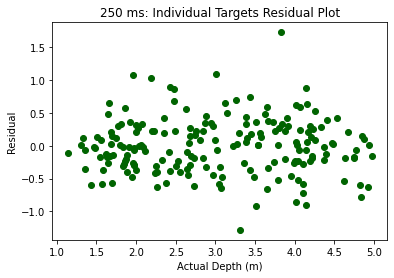

In [46]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_250 = y-y_predicted
plt.plot(X,residuals_250, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

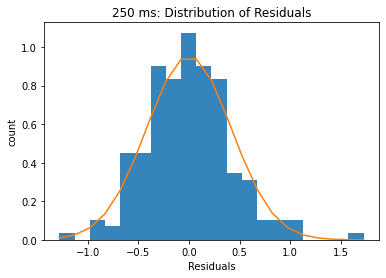

In [47]:
import scipy 
plt.title('250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals_250, 20, density=1, alpha=0.9)
mu_250, sigma = scipy.stats.norm.fit(residuals_250)
best_fit_line_250 = scipy.stats.norm.pdf(bins, mu_250, sigma)
plt.plot(bins, best_fit_line_250)

plt.show()

m: [0.53004172]
b: 0.789019604448113
R-squared:  0.6295405881801919


0.63

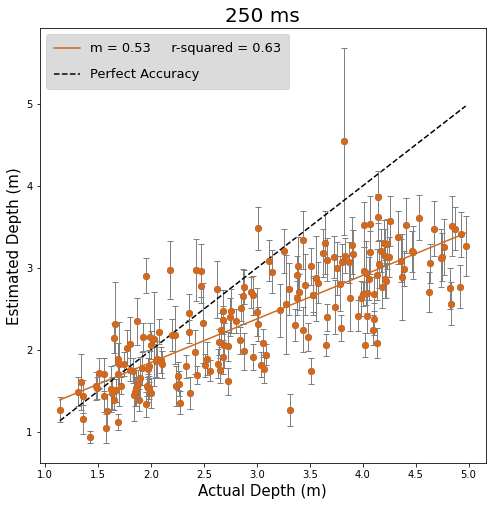

In [48]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

In [49]:
X_250[136]

array([3.827])

In [50]:
duration_data[0].loc[duration_data[0]['actual_depth']==3.827]

# TYPOS: participants responed 50 and 20 -- probs typo -- edit csv files and remake all TAC files 


subjID experimentName                             versionName  \
1179   890242    DepthScenes  duration_manipulation_targetAtFixation   
1458   710814    DepthScenes  duration_manipulation_targetAtFixation   
2146   846332    DepthScenes  duration_manipulation_targetAtFixation   
2355   423119    DepthScenes  duration_manipulation_targetAtFixation   
2710   204046    DepthScenes  duration_manipulation_targetAtFixation   
3784   717534    DepthScenes  duration_manipulation_targetAtFixation   
3873   628651    DepthScenes  duration_manipulation_targetAtFixation   
8606   843276    DepthScenes  duration_manipulation_targetAtFixation   
10237  979666    DepthScenes  duration_manipulation_targetAtFixation   
11424  874030    DepthScenes  duration_manipulation_targetAtFixation   
12174  816412    DepthScenes  duration_manipulation_targetAtFixation   
13029  812921    DepthScenes  duration_manipulation_targetAtFixation   
13691  386232    DepthScenes  duration_manipulation_targetAtFixation   
13998  144157    DepthScenes  duration_manipulation_targetAtFixation   
14500  799743    DepthScenes  duration_manipulation_targetAtFixation   
15690  704211    DepthScenes  duration_manipulation_targetAtFixation   
20258  892253    DepthScenes  duration_manipulation_targetAtFixation   
20809  606882    DepthScenes  duration_manipulation_targetAtFixation   
21007  802877    DepthScenes  duration_manipulation_targetAtFixation   
21444  480434    DepthScenes  duration_manipulation_targetAtFixation   
23867  559863    DepthScenes  duration_manipulation_targetAtFixation   
24557  447229    DepthScenes  duration_manipulation_targetAtFixation   
25019  171583    DepthScenes  duration_manipulation_targetAtFixation   
25243  827831    DepthScenes  duration_manipulation_targetAtFixation   
26819  619135    DepthScenes  duration_manipulation_targetAtFixation   
27678  254432    DepthScenes  duration_manipulation_targetAtFixation   
28375  425455    DepthScenes  duration_manipulation_targetAtFixation   
31231  870157    DepthScenes  duration_manipulation_targetAtFixation   
33562  639058    DepthScenes  duration_manipulation_targetAtFixation   
35855  981461    DepthScenes  duration_manipulation_targetAtFixation   
38014  327011    DepthScenes  duration_manipulation_targetAtFixation   
38062  483064    DepthScenes  duration_manipulation_targetAtFixation   
38483  252064    DepthScenes  duration_manipulation_targetAtFixation   
41522  677248    DepthScenes  duration_manipulation_targetAtFixation   
41925  736376    DepthScenes  duration_manipulation_targetAtFixation   
42328  951685    DepthScenes  duration_manipulation_targetAtFixation   
42773  134671    DepthScenes  duration_manipulation_targetAtFixation   
43753  144079    DepthScenes  duration_manipulation_targetAtFixation   
44535  929555    DepthScenes  duration_manipulation_targetAtFixation   
44783  891200    DepthScenes  duration_manipulation_targetAtFixation   
45408  665311    DepthScenes  duration_manipulation_targetAtFixation   
46551  793251    DepthScenes  duration_manipulation_targetAtFixation   
49536  714857    DepthScenes  duration_manipulation_targetAtFixation   
50207  239302    DepthScenes  duration_manipulation_targetAtFixation   
55732  123232    DepthScenes  duration_manipulation_targetAtFixation   

          sequenceName                                                url  \
1179    jsons/n_2.json  http://100.27.21.195/DepthDuration/v2_depth_du...   
1458   jsons/ad_3.json  http://100.27.21.195/DepthDuration/v2_depth_du...   
2146    jsons/y_1.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
2355    jsons/q_1.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
2710    jsons/l_3.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
3784    jsons/g_3.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
3873    jsons/k_2.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
8606     jsons/ag.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
1

slope: 0.034012    intercept: 0.141371
R-squared: 0.098983
Standard-error: 0.007445


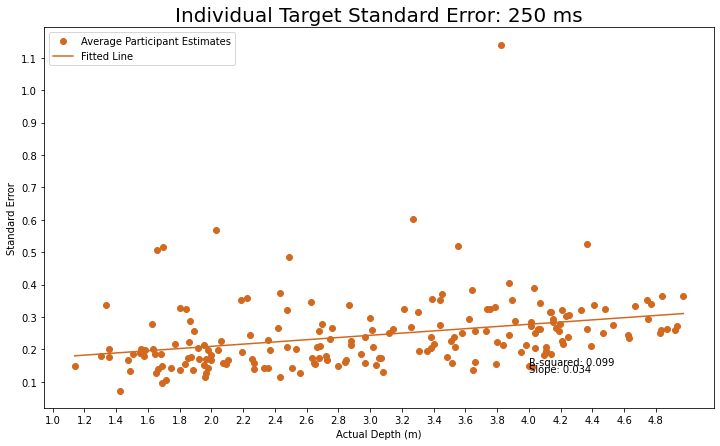

Average Standard Error 250 ms


0.24412696227831623

In [51]:
plot_img_ste(stim_250, final_y_250, ste_250, 250)

avg_250 =np.mean(ste_250)
print("Average Standard Error 250 ms")
avg_250

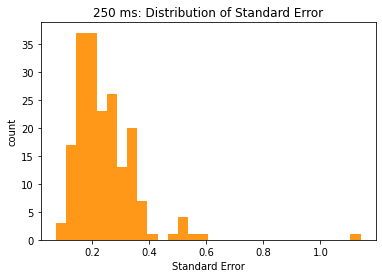

In [52]:
plt.hist(ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.230804    intercept: 0.971530
R-squared: 0.098918
Standard-error: 0.050537


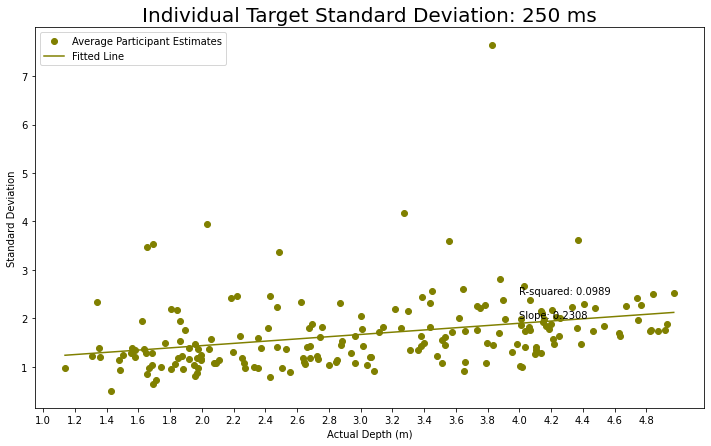

(0.23080371116206572,
 0.9715300580579568,
 0.3145126733629264,
 8.878506237121601e-06,
 0.05053705623331735)

In [53]:
plot_img_std(stim_250, final_y_250, std_250, 250)

In [54]:
mean_std_250 = np.mean(np.array(std_250))
mean_std_250

1.6688318961381203

Look at images with standard errors on the tail of the distribution

m: [0.58669154]
b: 0.642881066174968
R-squared:  0.6844490286060629


Text(0, 0.5, 'Residual')

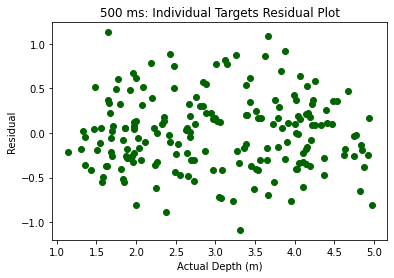

In [55]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_500).reshape(-1,1)
y = final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_500 = y-y_predicted
plt.plot(X,residuals_500, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

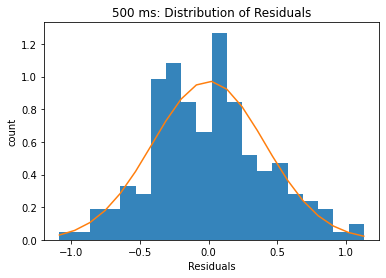

In [56]:
plt.title('500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals_500, 20, density=1, alpha=0.9)
mu_500, sigma = scipy.stats.norm.fit(residuals_500)
best_fit_line_500 = scipy.stats.norm.pdf(bins, mu_500, sigma)
plt.plot(bins, best_fit_line_500)

plt.show()

m: [0.58669154]
b: 0.642881066174968
R-squared:  0.6844490286060629


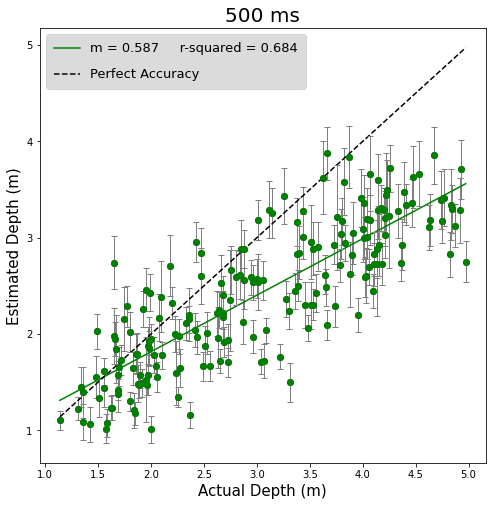

In [57]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_500 = np.array(stim_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black', alpha = 0.7);
plt.plot(X_500,y_predicted_500,color='green', label = 'm = ' + str(round(reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_500.score(X_500, y_500)), 3)))
plt.title("500 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_500, y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

In [58]:
x = duration_data[1].loc[duration_data[1]['actual_depth']< 1.6]
y = x.loc[x['actual_depth'] > 1.5]

y.loc[y['depth_estimate'] > 5]

subjID experimentName                             versionName  \
2836   204046    DepthScenes  duration_manipulation_targetAtFixation   
16659  196682    DepthScenes  duration_manipulation_targetAtFixation   
35825  981461    DepthScenes  duration_manipulation_targetAtFixation   
44503  929555    DepthScenes  duration_manipulation_targetAtFixation   

         sequenceName                                                url  \
2836   jsons/l_3.json  http://34.238.49.31/DepthDuration/v2_depth_dur...   
16659   jsons/ak.json  http://35.173.220.167/DepthDuration/v2_depth_d...   
35825    jsons/v.json  http://35.173.220.167/DepthDuration/v2_depth_d...   
44503  jsons/j_2.json  http://35.173.220.167/DepthDuration/v2_depth_d...   

       selected_row  windowWidth  windowHeight  screenWidth  screenHeight  \
2836             13         1366           657         1366           768   
16659            44         1366           568         1366           768   
35825            80         1024           625         1024           768   
44503            30         1366           625         1366           768   

       ... duration actual_depth  depth_estimate trial_RT  log_sceneDuration  \
2836   ...      500     1.551000             6.0     2498                497   
16659  ...      500     1.579500             6.0     9384                429   
35825  ...      500     1.504333             8.0     5466                509   
44503  ...      500     1.551000             7.0     4916                505   

       unitSelection  experimentTime  totalTime  age gender  
2836          meters         1088790    1162547   30    Man  
16659         meters         1521140    1984732   30    Man  
35825         meters         1513862    1781977   28    Man  
44503         meters          750840    1066706   36  Woman  

[4 rows x 24 columns]

slope: 0.034057    intercept: 0.128738
R-squared: 0.183726
Standard-error: 0.005208


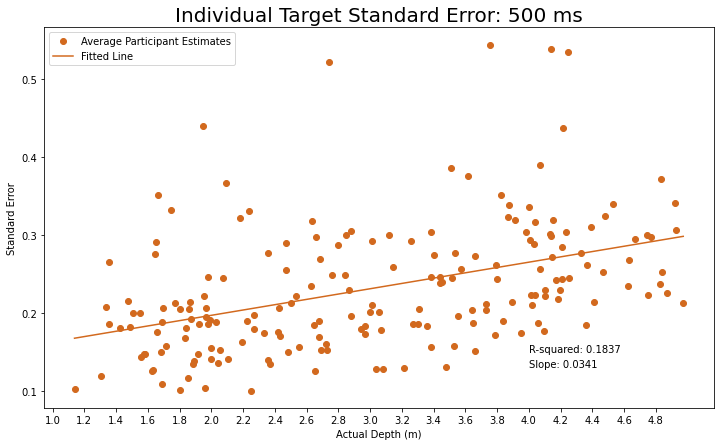

Average Standard Error 500 ms


0.23163013629889906

In [59]:
plot_img_ste(stim_500, final_y_500, ste_500, 500)

avg_500 =np.mean(ste_500)
print("Average Standard Error 500 ms")
avg_500

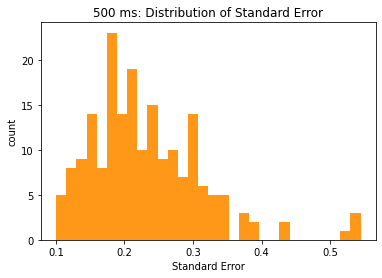

In [60]:
plt.hist(ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.229458    intercept: 0.891412
R-squared: 0.180868
Standard-error: 0.035426


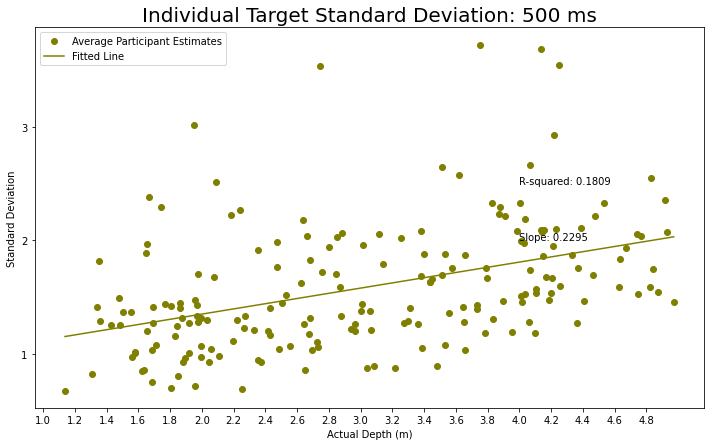

(0.22945803010049703,
 0.8914117660751799,
 0.42528589587979015,
 7.802248366458686e-10,
 0.035426023120006145)

In [61]:
plot_img_std(stim_500, final_y_500, std_500, 500)

In [62]:
mean_std_500 = np.mean(np.array(std_500))
mean_std_500

1.5846480461407992

m: [0.60294966]
b: 0.6326789358921194
R-squared:  0.6739227649433026


Text(0, 0.5, 'Residual')

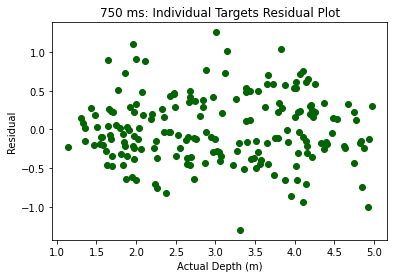

In [63]:
from sklearn.linear_model import LinearRegression

#run regression
X = np.array(stim_750).reshape(-1,1)
y = final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_750 = y-y_predicted
plt.plot(X,residuals_750, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

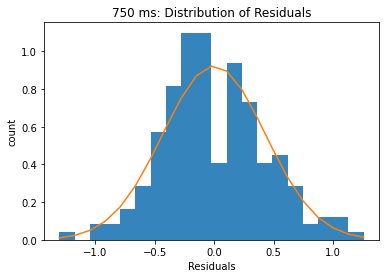

In [64]:
plt.title('750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals_750, 20, density=1, alpha=0.9)
mu_750, sigma = scipy.stats.norm.fit(residuals_750)
best_fit_line_750 = scipy.stats.norm.pdf(bins, mu_750, sigma)
plt.plot(bins, best_fit_line_750)

plt.show()

m: [0.60294966]
b: 0.6326789358921194
R-squared:  0.6739227649433026


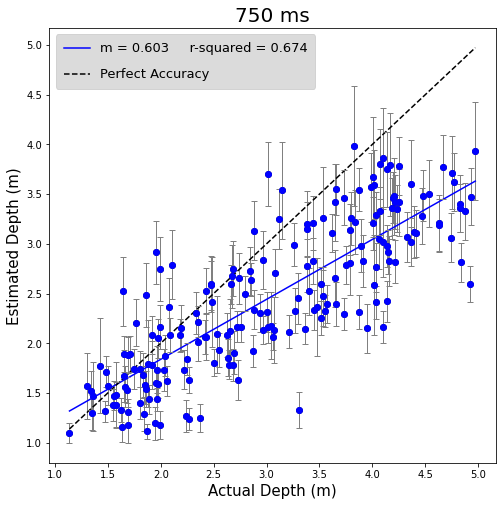

In [65]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_750 = np.array(stim_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black', alpha = 0.7);
plt.plot(X_750,y_predicted_750,color='blue', label = 'm = ' + str(round(reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_750.score(X_750, y_750)), 3)))
plt.title("750 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_750, y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

In [66]:
# X_750[-22], y_750[-22], final_x_750[-22]
# X_750[108], y_750[108], final_x_750[108]
X_750[39], y_750[39], final_x_750[39]

(array([1.956]),
 2.9129391304347836,
 'depth_duration_stimuli/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1-target.png')

slope: 0.034496    intercept: 0.142542
R-squared: 0.136605
Standard-error: 0.006292


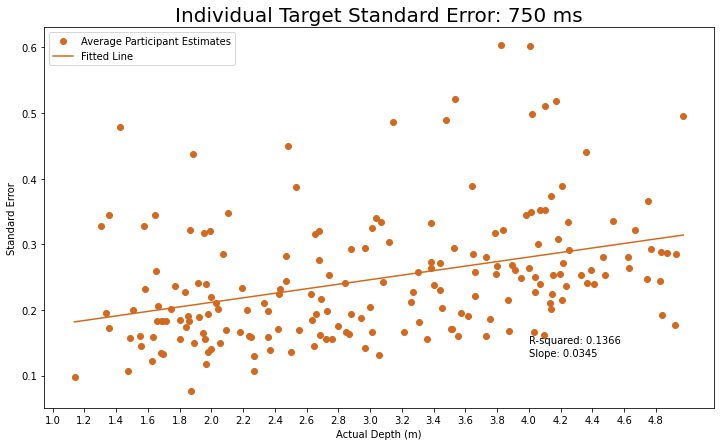

Average Standard Error 750 ms


0.24676081070128966

In [67]:
plot_img_ste(stim_750, final_y_750, ste_750, 750)

avg_750 =np.mean(ste_750)
print("Average Standard Error 750 ms")
avg_750

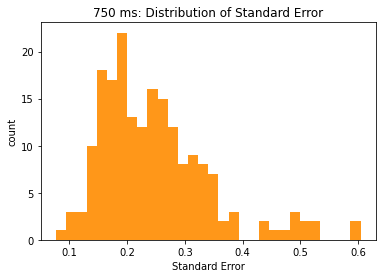

In [68]:
plt.hist(ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.231397    intercept: 0.988993
R-squared: 0.131339
Standard-error: 0.043173


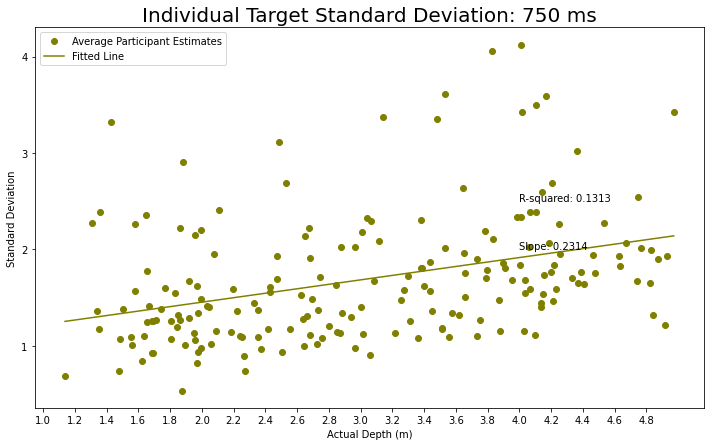

(0.2313971813162753,
 0.9889931030807895,
 0.36240758341121304,
 2.397192718984703e-07,
 0.04317268755407164)

In [69]:
plot_img_std(stim_750, final_y_750, std_750, 750)

In [70]:
mean_std_750 = np.mean(np.array(std_750))
mean_std_750

1.688087927189178

m: [0.61357964]
b: 0.5766914193678094
R-squared:  0.6964999816895349


Text(0, 0.5, 'Residual')

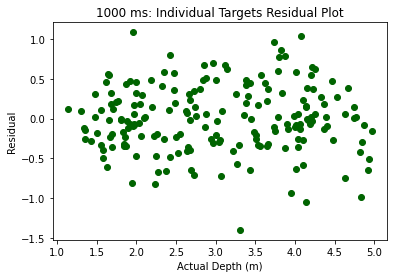

In [71]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_1000 = y-y_predicted
plt.plot(X,residuals_1000, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

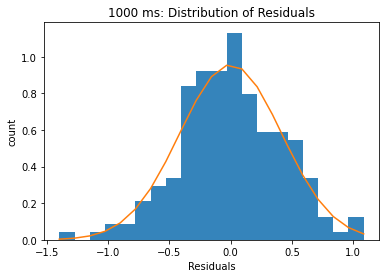

In [72]:
plt.title('1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals_1000, 20, density=1, alpha=0.9)
mu_1000, sigma = scipy.stats.norm.fit(residuals_1000)
best_fit_line_1000 = scipy.stats.norm.pdf(bins, mu_1000, sigma)
plt.plot(bins, best_fit_line_1000)

plt.show()

m: [0.61357964]
b: 0.5766914193678094
R-squared:  0.6964999816895349


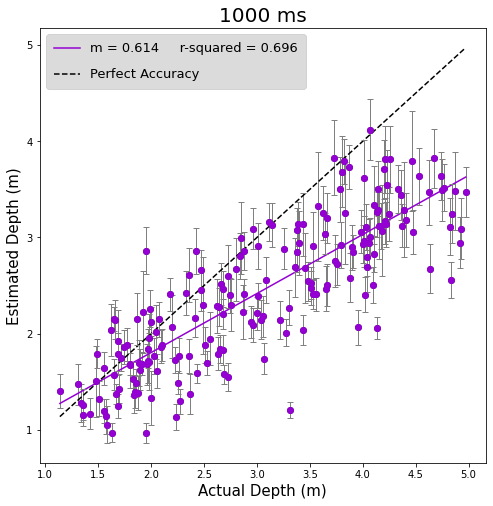

In [73]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [75]:
stats.pearsonr(stim_1000, y_1000)

(0.8345657443781976, 4.4119404341036646e-51)

slope: 0.036132    intercept: 0.122762
R-squared: 0.183636
Standard-error: 0.005527


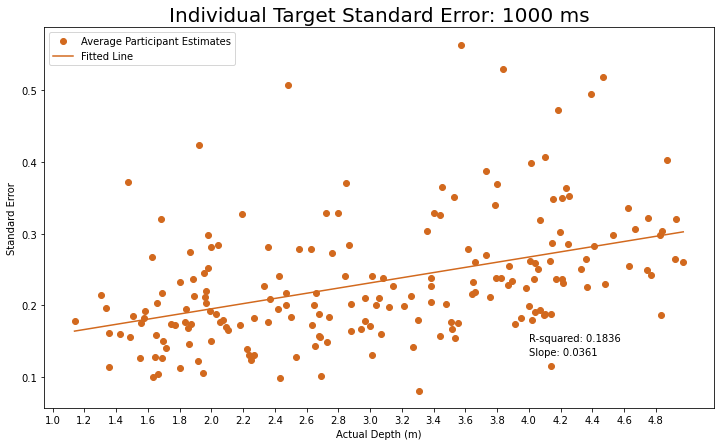

Average Standard Error 1000 ms


0.23192424859485014

In [73]:
plot_img_ste(stim_1000, final_y_1000, ste_1000, 1000)

avg_1000 =np.mean(ste_1000)
print("Average Standard Error 1000 ms")
avg_1000

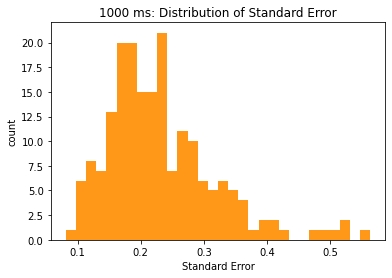

In [74]:
plt.hist(ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

In [75]:
ste_1000[52]
final_x_1000[52]

'depth_duration_stimuli/000878_2014-06-08_22-52-45_260595134347_rgbf000045-resize_2/000878_2014-06-08_22-52-45_260595134347_rgbf000045-resize_2-target.png'

slope: 0.242782    intercept: 0.853717
R-squared: 0.178640
Standard-error: 0.037767


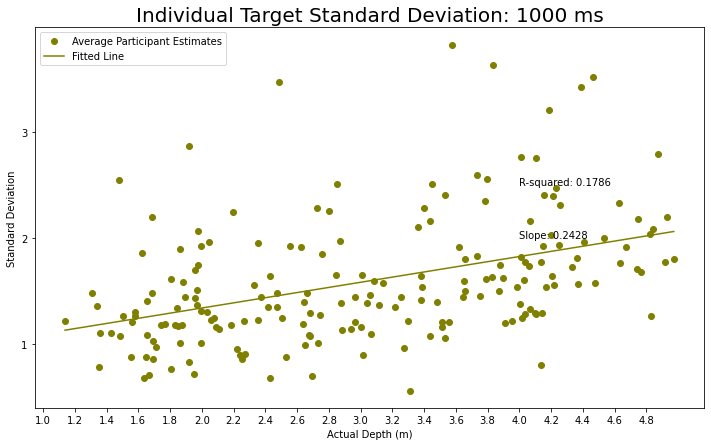

(0.24278196462209028,
 0.853717457776426,
 0.422658707574424,
 1.015835821555595e-09,
 0.037767346566160126)

In [76]:
plot_img_std(stim_1000, final_y_1000, std_1000, 1000)

In [77]:
mean_std_1000 = np.mean(np.array(std_1000))
mean_std_1000

1.5872078740757687

#### Summary Plots

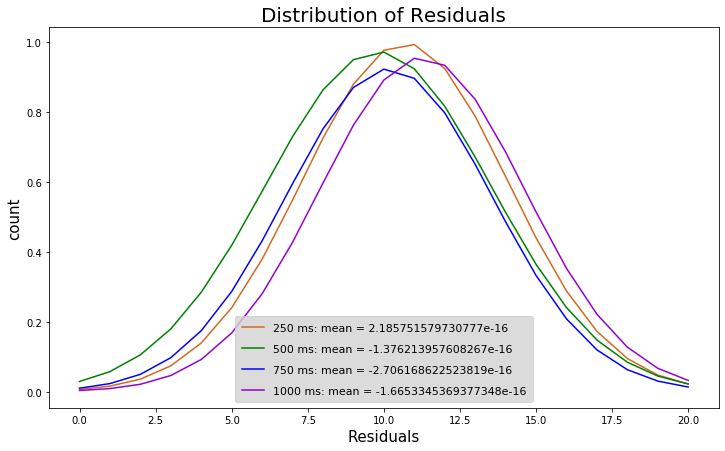

In [606]:
plt.figure(figsize = [12, 7])
plt.title('Distribution of Residuals', fontsize = 20)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('count', fontsize = 15)

plt.plot(best_fit_line_250, color = 'chocolate', label = '250 ms: '
        + 'mean = ' + str(mu_250))
plt.plot(best_fit_line_500, color = 'green', label = '500 ms: '
        + 'mean = ' + str(mu_500))
plt.plot(best_fit_line_750, color = 'blue', label = '750 ms: '
        + 'mean = ' + str(mu_750))
plt.plot(best_fit_line_1000, color = 'darkviolet', label = '1000 ms: '
        + 'mean = ' + str(mu_1000))

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


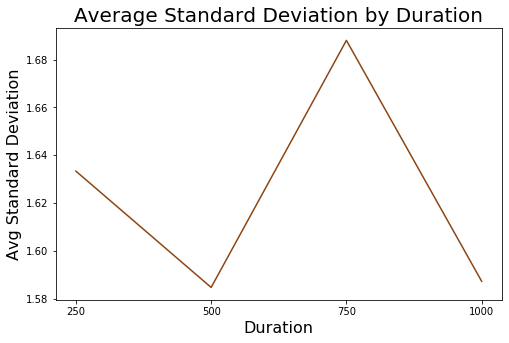

In [607]:
mean_stds = [mean_std_250, mean_std_500, mean_std_750, mean_std_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 5])
plt.plot(xAxis,mean_stds, color="saddlebrown")
plt.xlabel('Duration', fontsize=16)
plt.ylabel('Avg Standard Deviation', fontsize=16)
plt.title("Average Standard Deviation by Duration", fontsize = 20)

plt.show()

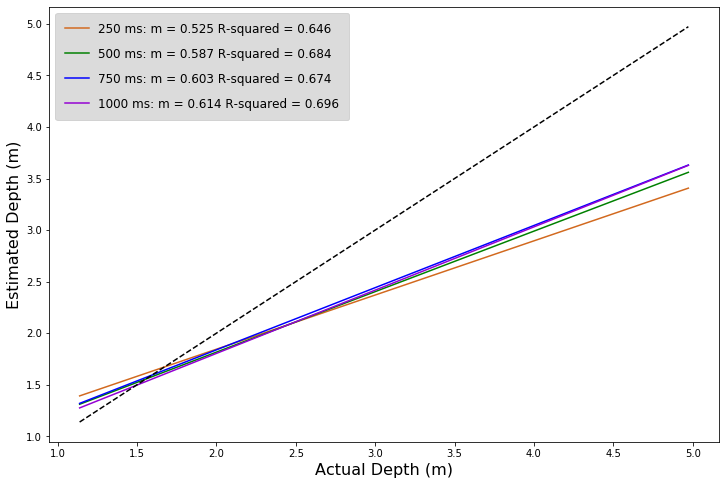

In [608]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

In [609]:
# final_x_1000

#### Save Raw Individual Trial Data to npy file

In [81]:
# Save data arrays to a binary file in NumPy .npy format. 

# destpath = '/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/TAC_raw_individual_trial_data/'

destpath = '/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_data/'

with open(destpath + 'X_250.npy', 'wb') as f:
    np.save(f, X_250)
with open(destpath + 'final_y_250.npy', 'wb') as f:
    np.save(f, final_y_250)
    
with open(destpath + 'X_500.npy', 'wb') as f:
    np.save(f, X_500)
with open(destpath + 'final_y_500.npy', 'wb') as f:
    np.save(f, final_y_500)
    
with open(destpath + 'X_750.npy', 'wb') as f:
    np.save(f, X_750)
with open(destpath + 'final_y_750.npy', 'wb') as f:
    np.save(f, final_y_750)
    
with open(destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, X_1000)
with open(destpath + 'final_y_1000.npy', 'wb') as f:
    np.save(f, final_y_1000)

with open(destpath + 'final_stim_250.npy', 'wb') as f:
    np.save(f, final_x_250)
with open(destpath + 'final_stim_500.npy', 'wb') as f:
    np.save(f, final_x_500)
with open(destpath + 'final_stim_750.npy', 'wb') as f:
    np.save(f, final_x_750)
with open(destpath + 'final_stim_1000.npy', 'wb') as f:
    np.save(f, final_x_1000)

In [79]:
# final_x_1000

In [49]:
# destpath = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_data/'

destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_data/'

with open(destpath + 'std_250.npy', 'wb') as f:
    np.save(f, std_250)
    
with open(destpath + 'std_500.npy', 'wb') as f:
    np.save(f, std_500)
    
with open(destpath + 'std_750.npy', 'wb') as f:
    np.save(f, std_750)
    
with open(destpath + 'std_1000.npy', 'wb') as f:
    np.save(f, std_1000)

with open(destpath + 'ste_250.npy', 'wb') as f:
    np.save(f, ste_250)
    
with open(destpath + 'ste_500.npy', 'wb') as f:
    np.save(f, ste_500)
    
with open(destpath + 'ste_750.npy', 'wb') as f:
    np.save(f, ste_750)
    
with open(destpath + 'ste_1000.npy', 'wb') as f:
    np.save(f, ste_1000)

In [650]:
# destpath_resid = '/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/TAC_raw_individual_trial_residuals/'

destpath_resid = '/Users/pmahableshwarkar/Documents/Depth_Project/TAC_npy_files/TAC_raw_individual_trial_residuals/'

with open(destpath_resid + 'residuals_250.npy', 'wb') as f:
    np.save(f, residuals_250)
    
with open(destpath_resid + 'residuals_500.npy', 'wb') as f:
    np.save(f, residuals_500)
    
with open(destpath_resid + 'residuals_750.npy', 'wb') as f:
    np.save(f, residuals_750)
    
with open(destpath_resid + 'residuals_1000.npy', 'wb') as f:
    np.save(f, residuals_1000)


## Normalized

In [82]:
norm_trial_plot_data = trial_normalized_final

## Execute this cell to prep for plotting
n_final_x_250 = norm_trial_plot_data[0][0]
n_final_y_250 = norm_trial_plot_data[1][0]
n_ste_250 = norm_trial_plot_data[2][0]
n_stim_250 = norm_trial_plot_data[3][0]
n_std_250 = norm_trial_plot_data[4][0]

n_final_x_500 = norm_trial_plot_data[0][1]
n_final_y_500 = norm_trial_plot_data[1][1]
n_ste_500 = norm_trial_plot_data[2][1]
n_stim_500 = norm_trial_plot_data[3][1]
n_std_500 = norm_trial_plot_data[4][1]


n_final_x_750 = norm_trial_plot_data[0][2]
n_final_y_750 = norm_trial_plot_data[1][2]
n_ste_750 = norm_trial_plot_data[2][2]
n_stim_750 = norm_trial_plot_data[3][2]
n_std_750 = norm_trial_plot_data[4][2]


n_final_x_1000 = norm_trial_plot_data[0][3]
n_final_y_1000 = norm_trial_plot_data[1][3]
n_ste_1000 = norm_trial_plot_data[2][3]
n_stim_1000 = norm_trial_plot_data[3][3]
n_std_1000 = norm_trial_plot_data[4][3]

m: [0.22178692]
b: 0.31298022060742525
R-squared:  0.6812641778841231


0.681

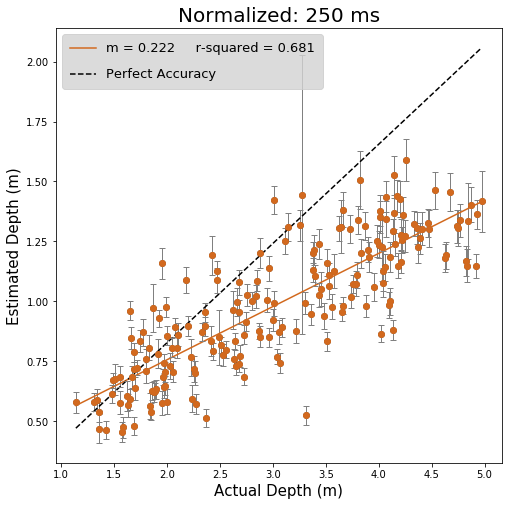

In [615]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_250 = np.array(stim_250).reshape(-1,1)
n_y_250 = n_final_y_250
n_reg_250 = LinearRegression().fit(n_X_250, n_y_250)

#Generated Predictions
n_y_predicted_250 = n_reg_250.predict(n_X_250)
#Plot Our Actual and Predicted Values
plt.plot(n_X_250, n_y_250, 'o', color='black', alpha = 0.5);
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = 'm = ' + str(round(n_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_250.score(n_X_250, n_y_250)), 3)))
plt.title("Normalized: 250 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_250, n_X_250/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_250, n_y_250, yerr=n_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(n_reg_250.coef_))
print("b: {0}".format(n_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_250.score(n_X_250, n_y_250))

round(float(n_reg_250.score(n_X_250, n_y_250)), 3)

m: [0.24684101]
b: 0.25493304630159885
R-squared:  0.7070506510213868


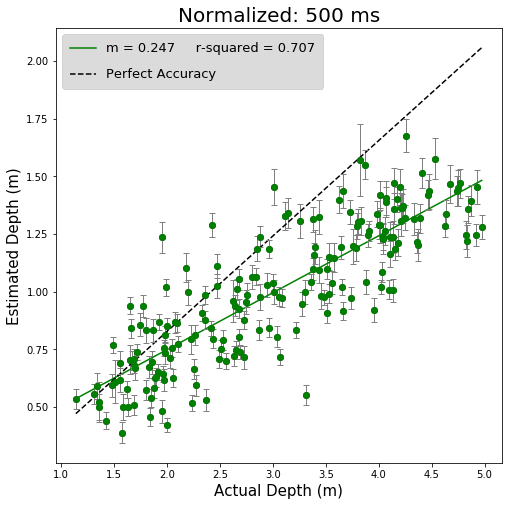

In [616]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_500 = np.array(n_stim_500).reshape(-1,1)
n_y_500 = n_final_y_500
n_reg_500 = LinearRegression().fit(n_X_500, n_y_500)

#Generated Predictions
n_y_predicted_500 = n_reg_500.predict(n_X_500)
#Plot Our Actual and Predicted Values
plt.plot(n_X_500, n_y_500, 'o', color='black', alpha = 0.7);
plt.plot(n_X_500,n_y_predicted_500,color='green', label = 'm = ' + str(round(n_reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_500.score(n_X_500, n_y_500)), 3)))
plt.title("Normalized: 500 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_500, n_X_500/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_500, n_y_500, yerr=n_ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "green", mec = "green", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(n_reg_500.coef_))
print("b: {0}".format(n_reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_500.score(n_X_500, n_y_500))

m: [0.25356558]
b: 0.24628176830087878
R-squared:  0.725344964621911


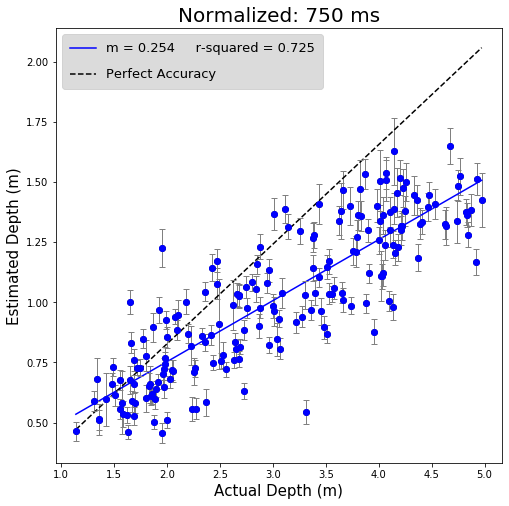

In [617]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_750 = np.array(n_stim_750).reshape(-1,1)
n_y_750 = n_final_y_750
n_reg_750 = LinearRegression().fit(n_X_750, n_y_750)

#Generated Predictions
n_y_predicted_750 = n_reg_750.predict(n_X_750)
#Plot Our Actual and Predicted Values
plt.plot(n_X_750, n_y_750, 'o', color='black', alpha = 0.7);
plt.plot(n_X_750,n_y_predicted_750,color='blue', label = 'm = ' + str(round(n_reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_750.score(n_X_750, n_y_750)), 3)))
plt.title("Normalized: 750 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_750, n_X_750/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_750, n_y_750, yerr=n_ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(n_reg_750.coef_))
print("b: {0}".format(n_reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_750.score(n_X_750, n_y_750))

m: [0.2569643]
b: 0.23441406894141348
R-squared:  0.714738827952146


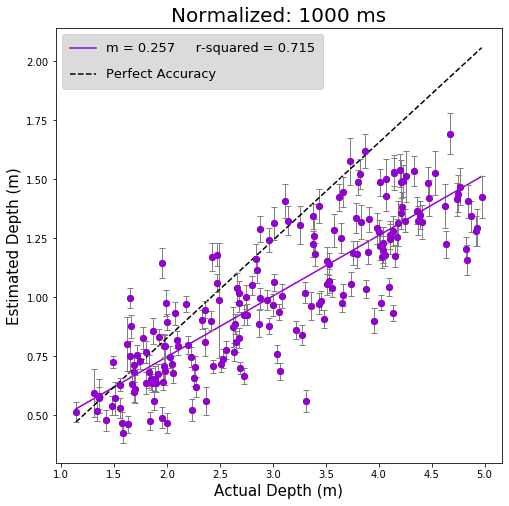

In [618]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
n_X_1000 = np.array(n_stim_1000).reshape(-1,1)
n_y_1000 = n_final_y_1000
n_reg_1000 = LinearRegression().fit(n_X_1000, n_y_1000)

#Generated Predictions
n_y_predicted_1000 = n_reg_1000.predict(n_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(n_X_1000, n_y_1000, 'o', color='black', alpha = 0.7);
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(n_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(n_reg_1000.score(n_X_1000, n_y_1000)), 3)))

plt.title("Normalized: 1000 ms", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth (m)", fontsize = 15)
plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(n_X_1000, n_y_1000, yerr=n_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_1000.coef_))
print("b: {0}".format(n_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_1000.score(n_X_1000, n_y_1000))

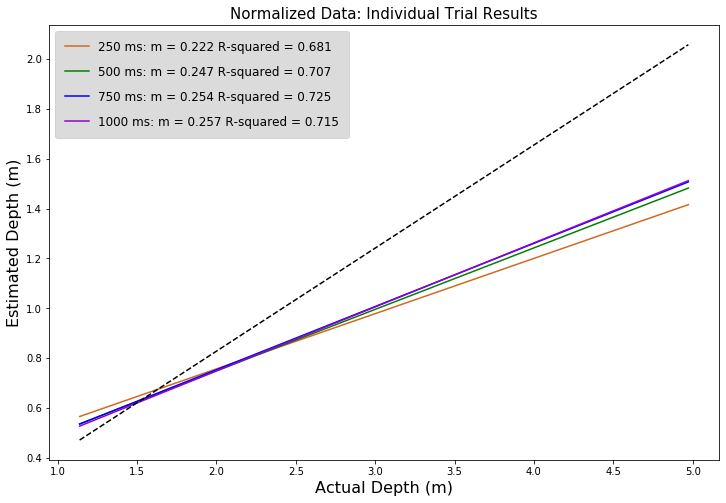

In [651]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

plt.title('Normalized Data: Individual Trial Results', fontsize = 15)

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(n_reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_250.score(n_X_250, n_y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(n_X_500,n_y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(n_reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_500.score(n_X_500, n_y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(n_X_750,n_y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(n_reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_750.score(n_X_750, n_y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(n_reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(n_reg_1000.score(n_X_1000, n_y_1000), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

#### Save Normalized Individual Trial Data to npy file

In [652]:
# Save data arrays to a binary file in NumPy .npy format. 
# n_destpath = '/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/TAC_normalized_individual_trial_data/'

n_destpath = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

with open(n_destpath + 'n_X_250.npy', 'wb') as f:
    np.save(f, n_X_250)
with open(n_destpath + 'n_final_y_250.npy', 'wb') as f:
    np.save(f, n_final_y_250)
    
with open(n_destpath + 'n_X_500.npy', 'wb') as f:
    np.save(f, n_X_500)
with open(n_destpath + 'n_final_y_500.npy', 'wb') as f:
    np.save(f, n_final_y_500)
    
with open(n_destpath + 'n_X_750.npy', 'wb') as f:
    np.save(f, n_X_750)
with open(n_destpath + 'n_final_y_750.npy', 'wb') as f:
    np.save(f, n_final_y_750)
    
with open(n_destpath + 'n_X_1000.npy', 'wb') as f:
    np.save(f, n_X_1000)
with open(n_destpath + 'n_final_y_1000.npy', 'wb') as f:
    np.save(f, n_final_y_1000)

In [52]:
# n_destpath = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

n_destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

with open(n_destpath + 'n_std_250.npy', 'wb') as f:
    np.save(f, n_std_250)
    
with open(n_destpath + 'n_std_500.npy', 'wb') as f:
    np.save(f, n_std_500)
    
with open(n_destpath + 'n_std_750.npy', 'wb') as f:
    np.save(f, n_std_750)
    
with open(n_destpath + 'n_std_1000.npy', 'wb') as f:
    np.save(f, n_std_1000)
    
with open(n_destpath + 'n_ste_250.npy', 'wb') as f:
    np.save(f, n_ste_250)
    
with open(n_destpath + 'n_ste_500.npy', 'wb') as f:
    np.save(f, n_ste_500)
    
with open(n_destpath + 'n_ste_750.npy', 'wb') as f:
    np.save(f, n_ste_750)
    
with open(n_destpath + 'n_ste_1000.npy', 'wb') as f:
    np.save(f, n_ste_1000)


In [84]:
n_destpath = '/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_normalized_individual_trial_data/'

with open(n_destpath + 'n_final_stim_250.npy', 'wb') as f:
    np.save(f, n_final_x_250)
with open(n_destpath + 'n_final_stim_500.npy', 'wb') as f:
    np.save(f, n_final_x_500)
with open(n_destpath + 'n_final_stim_750.npy', 'wb') as f:
    np.save(f, n_final_x_750)
with open(n_destpath + 'n_final_stim_1000.npy', 'wb') as f:
    np.save(f, n_final_x_1000)

(4.0, 0.0)

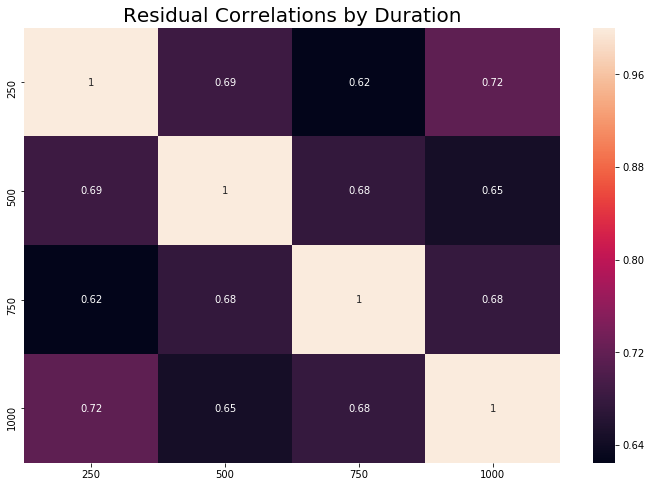

In [621]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'250': residuals_250,
        '500': residuals_500,
        '750': residuals_750,
        '1000': residuals_1000
        }


df = pd.DataFrame(data,columns=['250','500','750', '1000'])

plt.figure(figsize = [12, 8])
plt.title("Residual Correlations by Duration", fontsize = 20)
df_corr = df.corr()
ax = sns.heatmap(df_corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)



#### Average change in target over time

In [622]:
error_250 = np.array(stim_250) - np.array(y_250)
error_500 = np.array(stim_500) - np.array(y_500)
error_750 = np.array(stim_750) - np.array(y_750)
error_1000 = np.array(stim_1000) - np.array(y_1000)

avg_change_over_time = ((np.array(y_1000) - np.array(y_750)) + (np.array(y_750) - np.array(y_500)) + (np.array(y_500) - np.array(y_250)))/3

avg_change_in_accuracy = ((error_250 + error_500 + error_750 + error_1000)/4) 

avg_ste = (np.array(ste_250) + np.array(ste_500) + np.array(ste_750) + np.array(ste_1000))/4

std_1000_250_difference = np.array(std_1000) - np.array(std_250)


m: [0.03076788]
b: -0.13909936856221758
R-squared:  0.0016728977084768948


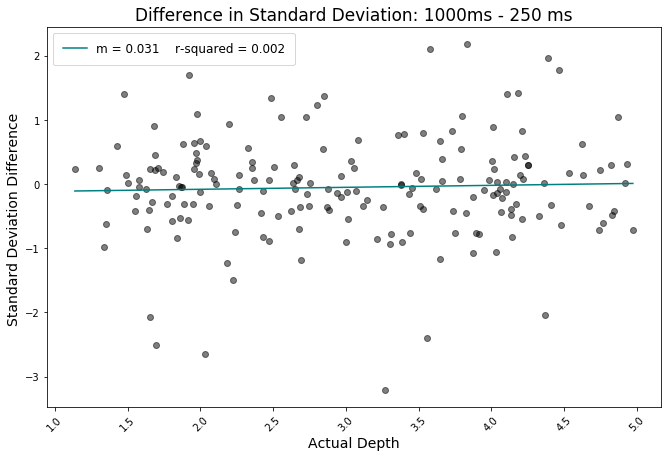

In [623]:
from sklearn.linear_model import LinearRegression
#run regression

reg_std_diff = LinearRegression().fit(X_250, std_1000_250_difference)

#Generated Predictions
y_predicted_std_diff = reg_std_diff.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_std_diff.coef_))
print("b: {0}".format(reg_std_diff.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_std_diff.score(X_250, std_1000_250_difference))

plt.figure(figsize=[11, 7])
plt.title("Difference in Standard Deviation: 1000ms - 250 ms", fontsize = 17)
plt.plot(X_250, std_1000_250_difference, 'o', color='black', alpha = 0.5)
plt.plot(X_250,y_predicted_std_diff,color='teal', 
         label = "m = "+ str(round(float(reg_std_diff.coef_), 3)) +
         "    r-squared = "+ str(round(float(reg_std_diff.score(X_250, std_1000_250_difference)), 3)))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Standard Deviation Difference ", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')

m: [0.02936236]
b: -0.07227575543549798
R-squared:  0.0796665736858968


Text(0, 0.5, 'Average Change over Time')

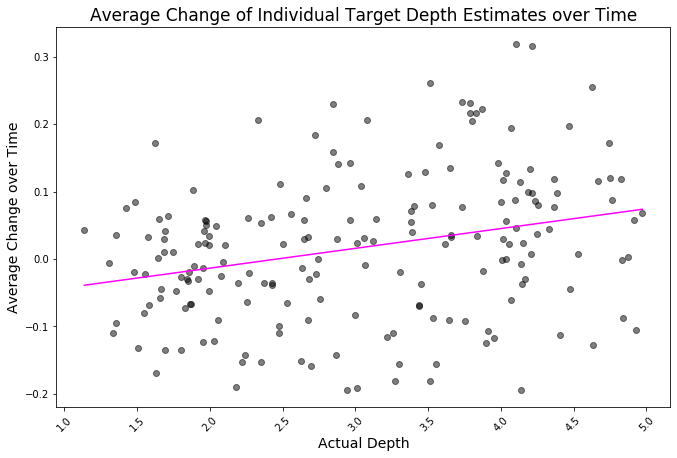

In [624]:
from sklearn.linear_model import LinearRegression
#run regression

reg_time = LinearRegression().fit(X_250, avg_change_over_time)

#Generated Predictions
y_predicted_time = reg_time.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_time.coef_))
print("b: {0}".format(reg_time.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_time.score(X_250, avg_change_over_time))

plt.figure(figsize=[11, 7])
plt.title("Average Change of Individual Target Depth Estimates over Time", fontsize = 17)
plt.plot(X_250, avg_change_over_time, 'o', color='black', alpha = 0.5)
plt.plot(X_250,y_predicted_time,color='fuchsia')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Change over Time", fontsize = 14)


m: [0.41782165]
b: -0.6614425267774097
R-squared:  0.5881527659709713


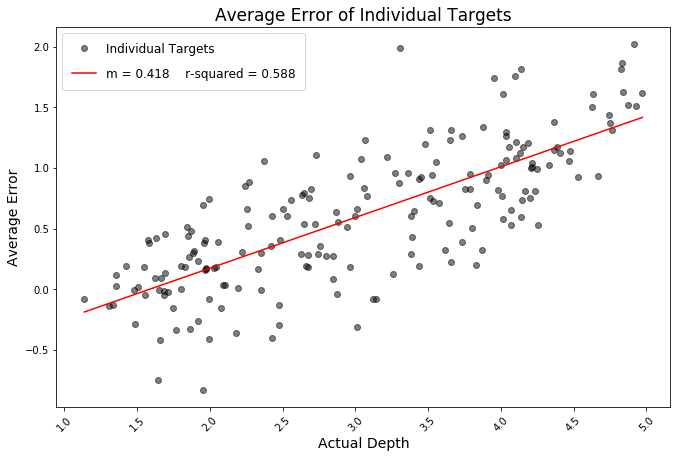

In [625]:
from sklearn.linear_model import LinearRegression
#run regression

reg_acc = LinearRegression().fit(X_250, avg_change_in_accuracy)

#Generated Predictions
y_predicted_acc = reg_acc.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_acc.coef_))
print("b: {0}".format(reg_acc.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_acc.score(X_250, avg_change_in_accuracy))

plt.figure(figsize=[11, 7])
plt.title("Average Error of Individual Targets", fontsize = 17)
plt.plot(X_250, avg_change_in_accuracy, 'o', color='black', alpha = 0.5, label = "Individual Targets")
plt.plot(X_250,y_predicted_acc,color='red', label = "m = "+ str(round(float(reg_acc.coef_), 3)) + "    r-squared = "+ str(round(float(reg_acc.score(X_250, avg_change_in_accuracy)), 3)))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Error", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')

m: [0.03397012]
b: 0.13466572247114167
R-squared:  0.4700051992157791


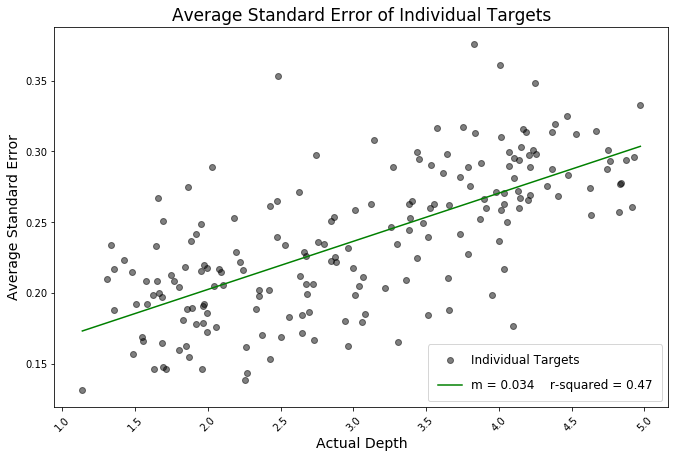

In [626]:
from sklearn.linear_model import LinearRegression
#run regression

reg_ste = LinearRegression().fit(X_250, avg_ste)

#Generated Predictions
y_predicted_ste = reg_ste.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_ste.coef_))
print("b: {0}".format(reg_ste.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_ste.score(X_250, avg_ste))

plt.figure(figsize=[11, 7])
plt.title("Average Standard Error of Individual Targets", fontsize = 17)
plt.plot(X_250, avg_ste, 'o', color='black', alpha = 0.5, label = "Individual Targets")
plt.plot(X_250,y_predicted_ste,color='green', label = "m = "+ str(round(float(reg_ste.coef_), 3)) + "    r-squared = "+ str(round(float(reg_ste.score(X_250, avg_ste)), 3)))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Standard Error", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')

In [627]:
high_change_in_accuracy = [final_x_250[idx] for idx in range(len(avg_change_in_accuracy)) if avg_change_in_accuracy[idx] <= -1]
low_change_in_accuracy = [final_x_250[idx] for idx in range(len(avg_change_in_accuracy)) if -0.1 <= avg_change_in_accuracy[idx] <= 0.1]


high_change_in_accuracy

[]

In [628]:
from scipy.spatial.transform import Rotation as R

#converts the rotation matrix in extrinsics.txt from string to a numpy array 
def rotationmatrix(matrix_path):
    matrixtext = open(matrix_path).read()
    
    x00 = float(matrixtext.split('\t')[0].split(' ')[0])
    x01 = float(matrixtext.split('\n')[0].split(' ')[1])
    x02 = float(matrixtext.split('\n')[0].split(' ')[2])
    
    x10 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[1].split(' ')[1])
    x12 = float(matrixtext.split('\n')[1].split(' ')[2])
    
    x20 = float(matrixtext.split('\n')[2].split(' ')[0])
    x21 = float(matrixtext.split('\n')[2].split(' ')[1])
    x22 = float(matrixtext.split('\n')[2].split(' ')[2])
    
    #list of the matrix values excluding the 3rd column of just zeroes 
    matrixlist = [[x00, x01, x02], [x10, x11, x12], [x20, x21, x22]]
    
    #creates 3x3 array of the rotation matrix
    matrixarray = np.full((3,3), matrixlist)
    
    return matrixarray

def rotationMatrixToEulerAngles(path):
    R = rotationmatrix(path)
    #assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# Output - final roll, pitch, yaw values in radians and degrees 
def imageExtrinsics(path):
    in_array = rotationMatrixToEulerAngles(path)
    #print ("Radian values : \n", in_array) 

    degree_Values = np.degrees(in_array) 
    #print ("\nDegree values : \n", degree_Values) 
    
#     print ("\nRoll in Degrees : \n", degree_Values[0]) 
#     print ("\nPitch in Degrees : \n", degree_Values[1]) 
#     print ("\nYaw in Degrees : \n", degree_Values[2]) 
    
    return degree_Values[0], degree_Values[1], degree_Values[2]


def extrinsics_distribution(path, kinectv2):
    targetfolder = path.split('/')[1]
    if len(targetfolder) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = path.split('/')[1][:-3]

    extpath = kinectv2 + '/' + imagefolder + '/extrinsics' 
    fname = os.listdir(extpath)[0]
    if fname != '.ipynb_checkpoints':
        extrinsics = imageExtrinsics(extpath + '/' + fname)
    # roll, pitch, yaw
    return extrinsics[0], extrinsics[1], extrinsics[2]


In [629]:
kinectv2_path = '/Users/pmahableshwarkar/Documents/Depth_Project/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

rolls = [extrinsics_distribution(path, kinectv2_path)[0] for path in final_x_250]
pitches = [extrinsics_distribution(path, kinectv2_path)[1] for path in final_x_250]
yaws = [extrinsics_distribution(path, kinectv2_path)[2] for path in final_x_250]

residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

#### To get the p-value remove the [0] after the pearsonr function

In [630]:
roll_corrs = [scipy.stats.pearsonr(rolls, resid_dur)[0] for resid_dur in residuals]

pitch_corrs = [scipy.stats.pearsonr(pitches, resid_dur)[0] for resid_dur in residuals]

yaw_corrs = [scipy.stats.pearsonr(yaws, resid_dur)[0] for resid_dur in residuals]


In [631]:
# plt.figure(figsize = [7, 5])
# _ = plt.hist(yaws, 100, density=1, alpha=0.9)


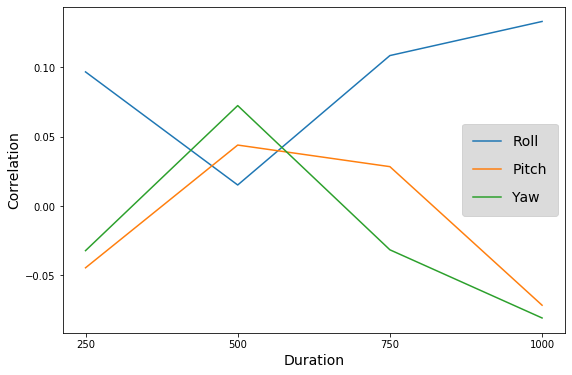

In [632]:
plt.figure(figsize = [9, 6])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, roll_corrs, label = 'Roll')
plt.plot(durations, pitch_corrs, label = 'Pitch')
plt.plot(durations, yaw_corrs, label = 'Yaw')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#### Depth Image Statistics

In [633]:
from PIL import Image, ImageStat

def getImageStats(imagepath):
    # Load image
    im = Image.open(imagepath)

    # Calculate statistics
    stats = ImageStat.Stat(im)                                                                 
    extrema = im.getextrema()
    for band,name in enumerate(im.getbands()): 
        contrast_ratio = (extrema[0] + 0.05)/(extrema[1] + 0.05)
        band_name = name 
        std = stats.stddev[band]
        
    return {'cr': contrast_ratio, 'std': std}


def ImageStats_distribution(path, kinectv2):
    targetfolder = path.split('/')[1]
    if len(targetfolder) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = path.split('/')[1][:-3]

    depth_bfx_path = kinectv2 + '/' + imagefolder + '/depth_bfx' 
    fname = os.listdir(depth_bfx_path)[0]
    if fname != '.ipynb_checkpoints':
        imagestats = getImageStats(depth_bfx_path + '/' + fname)
    # contrast ratio, std 
    return imagestats['cr'], imagestats['std']

In [634]:
# kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

contrast_ratios = [ImageStats_distribution(path, kinectv2_path)[0] for path in final_x_250]
depthbfx_std = [ImageStats_distribution(path, kinectv2_path)[1] for path in final_x_250]

residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

In [164]:
k = final_x_250[0]

k.split('/')[-2] + '/' + k.split('/')[-1] 

'002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2/002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2-target.png'

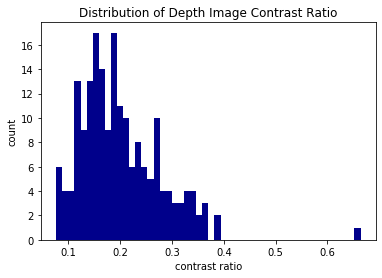

In [635]:
plt.title('Distribution of Depth Image Contrast Ratio')
plt.xlabel('contrast ratio')
plt.ylabel('count')
plt.hist(contrast_ratios, bins=50, color='darkblue')
plt.show()

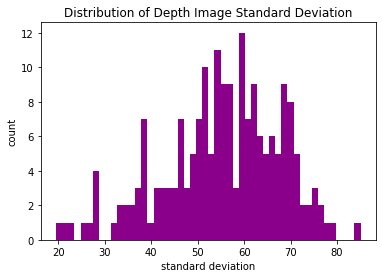

In [636]:
plt.title('Distribution of Depth Image Standard Deviation')
plt.xlabel('standard deviation')
plt.ylabel('count')
plt.hist(depthbfx_std, bins=50, color='darkmagenta')
plt.show()

In [637]:
cr_corrs = [scipy.stats.pearsonr(contrast_ratios, resid_dur)[0] for resid_dur in residuals]

depth_std_corrs = [scipy.stats.pearsonr(depthbfx_std, resid_dur)[0] for resid_dur in residuals]


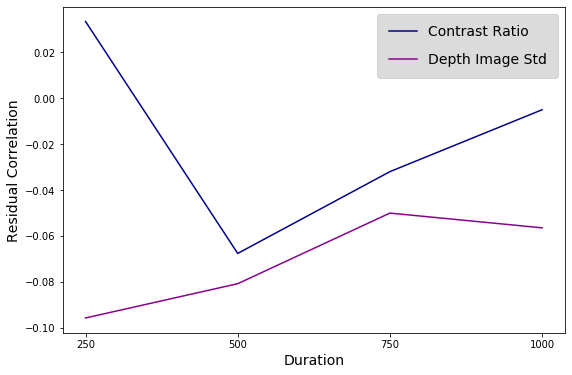

In [638]:
plt.figure(figsize = [9, 6])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Residual Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, cr_corrs, label = 'Contrast Ratio', color='darkblue')
plt.plot(durations, depth_std_corrs, label = 'Depth Image Std', color='darkmagenta')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

In [639]:
def getNeighboringPixels(coordinate, shape, radius):
    """
    Return coordinates for neigboring pixels  
    ** note that diagonal neighbors are included
    
    Calculate pixel coordinates 
    Filter out coordinates that are out of size of image 
    - for pixels that are on the edge of the image, there are fewer neighbors 
    - instead of defining a seperate edge calculation for these pixels, 
      calculate as if there are 8 neighbors
    - remove the calculated neighbors that have x > width and y > height 
    """
    x = coordinate[0]
    y = coordinate[1]
    
    neighbors = [[x-radius, y-radius], [x-radius, y], [x-radius, y+radius]
                            ,[x, y-radius],             [x, y+radius]
                            ,[x+radius, y-radius], [x+radius, y], [x+radius, y+radius]]
    
    neighbors = [val for val in neighbors if val[0] >= 0 and val[1] >= 0 
                 and val[0] < shape[0] and val[1] < shape[1]] 
    return neighbors 

def neighborMatrix(shape, radius):
    """
    Matrix with list of neighbors for each coordinate 
    """
    neighborMatrix = np.zeros((shape[0], shape[1]), dtype='object')
    for i in range(neighborMatrix.shape[0]):
        for j in range(neighborMatrix.shape[1]):
            neighborMatrix[i][j] = getNeighboringPixels([i,j], shape, radius)
    
    return neighborMatrix 


In [170]:
neighborMatrix_530_730_r20 = neighborMatrix([530, 730], 20)

In [171]:
import json 

def getTargetLocation(imagepath, rootdir):
    """
    imagepath = target folder 
    rootdir = main folder of all target folders (NOT SUNRGBD folder)
    """
    stimfolder = imagepath.split('/')[-2]
    jsonpath = rootdir + '/' + stimfolder + '/data.json'
    
    # Opening JSON file
    f = open(jsonpath,)

    # returns JSON object as 
    # a dictionary
    data = json.load(f)
    crossing_point = data['objects'][0]['crossing_point']
    # x, y is a misnomer for array indeces 
    # x value = 364 (verticel midline of image aka column index)
    x = crossing_point[0]['x']
    # y value - row index 
    y = crossing_point[0]['y']
    row_index = y
    col_index = x
    return (row_index,col_index)

def local_depth_stats(path, rootdir, kinect2data_path):
    _targetimg = rootdir + path.split('/')[-2] + '/' + path.split('/')[-1] 
    target_coord = getTargetLocation(path, rootdir)
    
    if len(path.split('/')[1]) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = stim.split('/')[1][:-1]

    d_path = kinect2data_path + '/' + imagefolder + '/depth_bfx' 
    fname = os.listdir(d_path)[0]
    if fname != '.ipynb_checkpoints':
        _depthbfx = d_path+'/'+fname
            
    _im = Image.open(_targetimg)
    _im.load()
    image_data = np.asarray(_im)
    
    _dm = Image.open(_depthbfx)
    _dm.load()
    depth_data = np.asarray(_dm)/8000 
    
    euclidean_distances_to_target = np.zeros([depth_data.shape[0],depth_data.shape[1]])
    for di in range(depth_data.shape[0]):
        for dj in range(depth_data.shape[1]):      
            point = np.array([di,dj])
            target = np.array([math.floor(target_coord[0]),math.floor(target_coord[1])])
            distance = np.linalg.norm(point - target)
            euclidean_distances_to_target[di][dj] = distance
    
    
    _local_contrastratio = np.zeros([depth_data.shape[0],depth_data.shape[1]])
    _local_std = np.zeros([depth_data.shape[0],depth_data.shape[1]])
    
    
    for di in range(depth_data.shape[0]):
        for dj in range(depth_data.shape[1]):
            d_neighbors_loc = neighborMatrix_530_730_r10[di][dj]
            neighbors = [depth_data[val[0]][val[1]] for val in d_neighbors_loc]
            local_cr = (min(neighbors)+0.05)/(max(neighbors)+0.05)
            _local_contrastratio[di][dj] = local_cr
            _local_std[di][dj] = np.array(neighbors).std()

    std = _local_std[target_coord[0]][math.floor(target_coord[1])]
    cr = _local_contrastratio[target_coord[0]][math.floor(target_coord[1])]
    
    return [_local_contrastratio, _local_std, std, cr]
    
    
    

### Euclidean Method: 

Ensure that all pixels in the 20 pixel radius around the target are included in the calculation of std and contrast ratio

In [172]:
def euclidean_array(coords, depth_data_shape):
    euclidean_distances_to_target = np.zeros([depth_data_shape[0],depth_data_shape[1]])
    for di in range(depth_data_shape[0]):
        for dj in range(depth_data_shape[1]):      
            point = np.array([di,dj])
            target = np.array([math.floor(coords[0]),math.floor(coords[1])])
            distance = np.linalg.norm(point - target)
            euclidean_distances_to_target[di][dj] = distance  
    
    return euclidean_distances_to_target

def main_euclidean_arrays(depth_data_shape):
    """
    depth_data_shape_0 = number of rows in the depth_bfx img
    Create all euclidean arrays for pixels that have a column value of 364  
    """
    row_values = np.arange(0,depth_data_shape[0])
    col_value = 364
    
    all_euclidean_arrays = []
    for val in row_values:
        euclid_arr = euclidean_array([val, col_value], depth_data_shape)
        all_euclidean_arrays.append(euclid_arr)
        
    return all_euclidean_arrays



In [173]:
shape = [530, 730]
reference_euclid_arrays = main_euclidean_arrays(shape)


KeyboardInterrupt: 

In [297]:
len(reference_euclid_arrays)

530

In [450]:
def Euclid_Target_DepthStats(path, rootdir, kinect2data_path, reference_euclid, critical_value = 28.3):
    """
    i = the row value to index 
    critical_value = max euclid distance for a 10 pixel radius 
    """
    _targetimg = rootdir + path.split('/')[-2] + '/' + path.split('/')[-1] 
    target_coord = getTargetLocation(path, rootdir)
    
    if len(path.split('/')[1]) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = stim.split('/')[1][:-1]

    d_path = kinect2data_path + '/' + imagefolder + '/depth_bfx' 
    fname = os.listdir(d_path)[0]
    if fname != '.ipynb_checkpoints':
        _depthbfx = d_path+'/'+fname
            
    _im = Image.open(_targetimg)
    _im.load()
    image_data = np.asarray(_im)
    
    _dm = Image.open(_depthbfx)
    _dm.load()
    depth_data = np.asarray(_dm)/8000 
    
    euclid = reference_euclid[math.floor(target_coord[0])]
    neighbor_coords = zip(np.nonzero(euclid<=critical_value)[0], 
                          np.nonzero(euclid<=critical_value)[1])
    neighbor_depths = [depth_data[val[0]][val[1]] for val in neighbor_coords]
    target_local_cr = (min(neighbor_depths)+0.05)/(max(neighbor_depths)+0.05)
    target_local_std = np.array(neighbor_depths).std()
    
    transf_cr = (1-target_local_cr) * 100 
    
    return target_local_std, target_local_cr, transf_cr

In [451]:
final_stimuli = '/Users/prachi/Documents/depth_duration/mar3_depthDuration_stimuli/final_stimuli/'
kinect2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

euclid_target_local_std = [Euclid_Target_DepthStats(path, final_stimuli, kinect2_path, reference_euclid_arrays)[0] for path in final_x_250]
euclid_target_local_cr = [Euclid_Target_DepthStats(path, final_stimuli, kinect2_path, reference_euclid_arrays)[2] for path in final_x_250]


In [452]:
len(euclid_target_local_std), len(euclid_target_local_cr)

(192, 192)

In [486]:
diff_score = np.array(euclid_target_local_cr) - np.array(euclid_target_local_std)
max_index= np.argmax(diff_score)
min_index= np.argmin(diff_score)

final_x_250[max_index], final_x_250[min_index]

('depth_duration_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png',
 'depth_duration_stimuli/000414_2014-06-04_19-49-13_260595134347_rgbf000044-resize_0/000414_2014-06-04_19-49-13_260595134347_rgbf000044-resize_0-target.png')

m: [0.06399981]
b: 0.062381663243006175
R-squared:  0.047792501554871136
m: [-0.27521395]
b: 27.138790455859308
R-squared:  -7459.220086012358


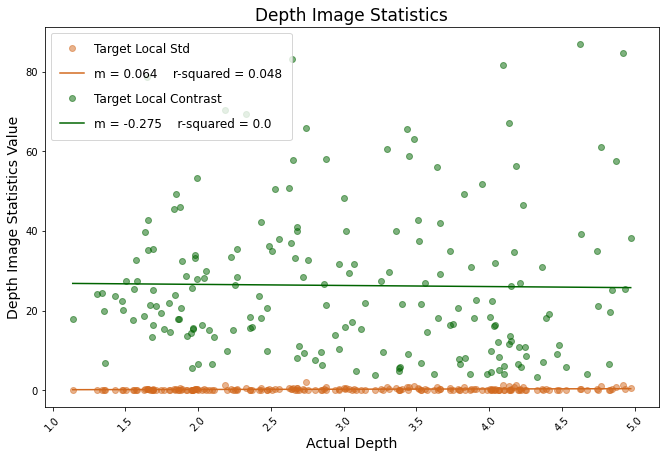

In [453]:
# plot the depth image stats for each image as a scatter to see the realtinoship between cr and std 
#use the TRANSFORMED version of local cr 
from sklearn.linear_model import LinearRegression
#run regression

reg_local_std = LinearRegression().fit(X_250, euclid_target_local_std)
reg_local_cr = LinearRegression().fit(X_250, euclid_target_local_cr)


#Generated Predictions
y_predicted_local_std = reg_local_std.predict(X_250)
y_predicted_local_cr = reg_local_cr.predict(X_250)


#get coefficients and y intercept
print("m: {0}".format(reg_local_std.coef_))
print("b: {0}".format(reg_local_std.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_local_std.score(X_250, euclid_target_local_std))


#get coefficients and y intercept
print("m: {0}".format(reg_local_cr.coef_))
print("b: {0}".format(reg_local_cr.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_local_cr.score(X_250, euclid_target_local_std))

plt.figure(figsize=[11, 7])
plt.title("Depth Image Statistics", fontsize = 17)

plt.plot(X_250, euclid_target_local_std, 'o', color='chocolate', alpha = 0.5, label = "Target Local Std")
plt.plot(X_250,y_predicted_local_std,color='chocolate', label = "m = "+ str(round(float(reg_local_std.coef_), 3)) + "    r-squared = "+ str(round(float(reg_local_std.score(X_250, euclid_target_local_std)), 3)))

plt.plot(X_250, euclid_target_local_cr, 'o', color='darkgreen', alpha = 0.5, label = "Target Local Contrast")
plt.plot(X_250,y_predicted_local_cr,color='darkgreen', label = "m = "+ str(round(float(reg_local_cr.coef_), 3)) + "    r-squared = "+ str(round(float(reg_local_cr.score(X_250, euclid_target_local_cr)), 3)))


plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Depth Image Statistics Value", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')


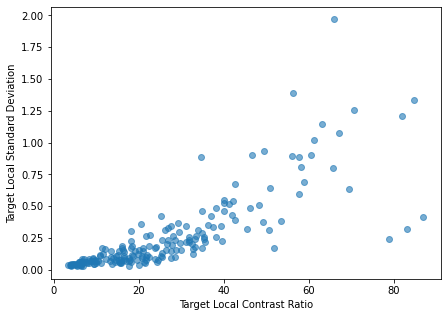

In [495]:
plt.figure(figsize = [7,5])
plt.plot(euclid_target_local_cr, euclid_target_local_std, 'o', alpha = 0.6)
plt.xlabel('Target Local Contrast Ratio')
plt.ylabel('Target Local Standard Deviation')
plt.show()

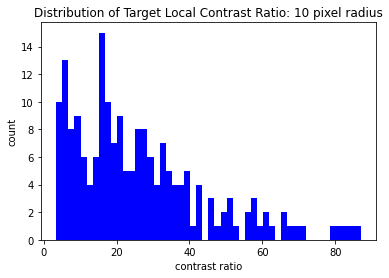

In [454]:
plt.title('Distribution of Target Local Contrast Ratio: 10 pixel radius')
plt.xlabel('contrast ratio')
plt.ylabel('count')
plt.hist(euclid_target_local_cr, bins=50, color='blue')
plt.show()

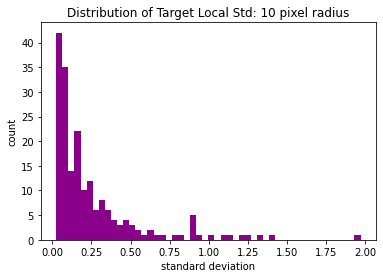

In [455]:
plt.title('Distribution of Target Local Std: 10 pixel radius')
plt.xlabel('standard deviation')
plt.ylabel('count')
plt.hist(euclid_target_local_std, bins=50, color='darkmagenta')
plt.show()

In [456]:
error_250 = np.absolute(np.array(stim_250) - np.array(y_250))
error_500 = np.absolute(np.array(stim_500) - np.array(y_500))
error_750 = np.absolute(np.array(stim_750) - np.array(y_750))
error_1000 = np.absolute(np.array(stim_1000) - np.array(y_1000))

abs_error = [error_250, error_500, error_750, error_1000]


In [457]:
abserror_targetlocalstd_corrs = [scipy.stats.pearsonr(euclid_target_local_std, error)[0] for error in abs_error]

abserror_targetlocalcr_corrs = [scipy.stats.pearsonr(euclid_target_local_cr, error)[0] for error in abs_error]

In [423]:
abserror_targetlocalstd_corrs

[0.07860151023801323,
 0.16889188395636112,
 0.10003783003206598,
 0.16917153251625322]

In [424]:
abserror_targetlocalcr_corrs

[-0.0107231100107748,
 0.11647493501543962,
 0.05587719576677584,
 0.1558236940504388]

Text(0.5, 1.0, 'Correlation between Response Absolute Error and Depth Image Statistics: 10 Pixel Radius')

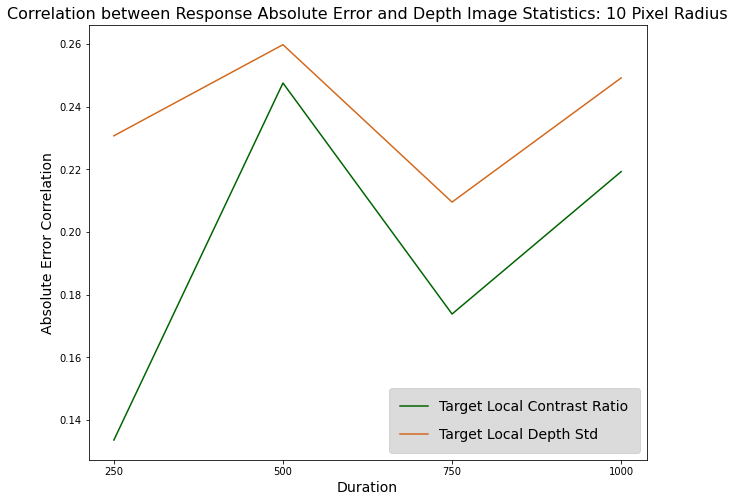

In [458]:
plt.figure(figsize = [10, 8])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Absolute Error Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, abserror_targetlocalcr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, abserror_targetlocalstd_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("Correlation between Response Absolute Error and Depth Image Statistics: 10 Pixel Radius", fontsize = 16)

In [459]:
estim_stds = [std_250, std_500, std_750, std_1000]


In [478]:
estimstds_targetlocalstd_corrs = [scipy.stats.pearsonr(euclid_target_local_std, _std)[0] for _std in estim_stds]

estimstds_targetlocalcr_corrs = [scipy.stats.pearsonr(euclid_target_local_cr, _std)[0] for _std in estim_stds]

In [428]:
estimstds_targetlocalstd_corrs

[0.13729995017976723,
 -0.07895738875127144,
 0.034829173839429045,
 -0.09338794835576081]

In [429]:
estimstds_targetlocalcr_corrs

[0.09183443995168411,
 -0.14258908748378252,
 -0.017210811324733268,
 -0.15392332729857772]

Text(0.5, 1.0, 'Correlation between Response Standard Deviation and Depth Image Statistics: 20 Pixel Radius')

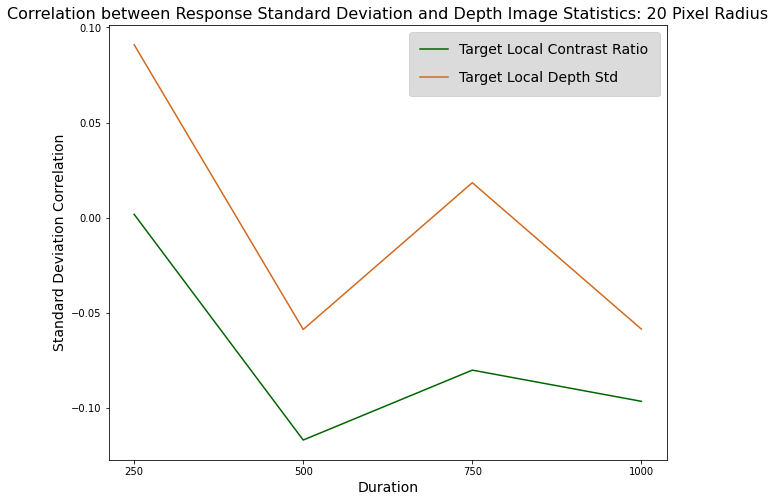

In [479]:
plt.figure(figsize = [10, 8])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Standard Deviation Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, estimstds_targetlocalcr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, estimstds_targetlocalstd_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("Correlation between Response Standard Deviation and Depth Image Statistics: 20 Pixel Radius", fontsize = 16)

#### Neighbor Method: Residual Correlations

In [432]:
# final_stimuli = '/Users/prachi/Documents/depth_duration/mar3_depthDuration_stimuli/final_stimuli/'
# kinect2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# # line comprehension for x(stim path) in final_x 

# local_contrast_ratio_array = [local_depth_stats(path, final_stimuli, kinect2_path)[0] for path in final_x_250]
# local_std_array = [local_depth_stats(path, final_stimuli, kinect2_path)[1] for path in final_x_250]
# target_local_std = [local_depth_stats(path, final_stimuli, kinect2_path)[2] for path in final_x_250]
# target_local_cr = [local_depth_stats(path, final_stimuli, kinect2_path)[3] for path in final_x_250]

# residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

In [280]:
target_local_std_corrs = [scipy.stats.pearsonr(target_local_std, resid_dur)[0] for resid_dur in residuals]

target_local_cr_corrs = [scipy.stats.pearsonr(target_local_cr, resid_dur)[0] for resid_dur in residuals]

In [281]:
target_local_std_corrs

[0.010956757687190823,
 -0.08708509574121852,
 -0.05293803615937917,
 -0.04608177706842288]

Text(0.5, 1.0, '10 Pixel Radius')

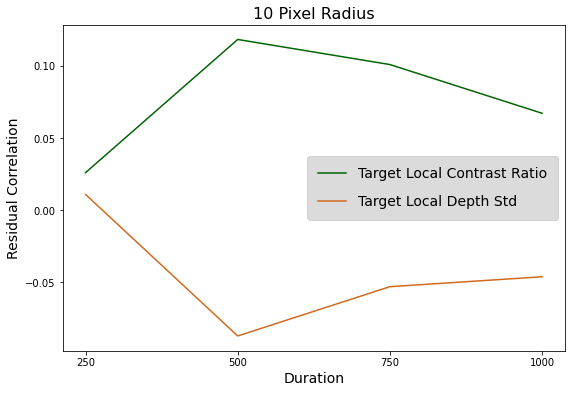

In [285]:
plt.figure(figsize = [9, 6])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Residual Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, target_local_cr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, target_local_std_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("10 Pixel Radius", fontsize = 16)

#### Normalized data

In [392]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
normalized_trial_plot_data = trial_normalized_final
##############################

n_final_x_250 = normalized_trial_plot_data[0][0]
n_final_y_250 = normalized_trial_plot_data[1][0]
n_ste_250 = normalized_trial_plot_data[2][0]
n_stim_250 = normalized_trial_plot_data[3][0]
n_std_250 = normalized_trial_plot_data[4][0]

n_final_x_500 = normalized_trial_plot_data[0][1]
n_final_y_500 = normalized_trial_plot_data[1][1]
n_ste_500 = normalized_trial_plot_data[2][1]
n_stim_500 = normalized_trial_plot_data[3][1]
n_std_500 = normalized_trial_plot_data[4][1]

n_final_x_750 = normalized_trial_plot_data[0][2]
n_final_y_750 = normalized_trial_plot_data[1][2]
n_ste_750 = normalized_trial_plot_data[2][2]
n_stim_750 = normalized_trial_plot_data[3][2]
n_std_750 = normalized_trial_plot_data[4][2]

n_final_x_1000 = normalized_trial_plot_data[0][3]
n_final_y_1000 = normalized_trial_plot_data[1][3]
n_ste_1000 = normalized_trial_plot_data[2][3]
n_stim_1000 = normalized_trial_plot_data[3][3]
n_std_1000 = normalized_trial_plot_data[4][3]

In [286]:
final_x_250[0]

'depth_duration_stimuli/002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2/002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize_2-target.png'

In [462]:
n_error_250 = np.absolute(np.array(n_stim_250) - np.array(n_final_y_250))
n_error_500 = np.absolute(np.array(n_stim_500) - np.array(n_final_y_500))
n_error_750 = np.absolute(np.array(n_stim_750) - np.array(n_final_y_750))
n_error_1000 = np.absolute(np.array(n_stim_1000) - np.array(n_final_y_1000))

n_abs_error = [n_error_250, n_error_500, n_error_750, n_error_1000]


In [480]:
n_abserror_targetlocalstd_corrs = [scipy.stats.pearsonr(euclid_target_local_std, error)[0] for error in n_abs_error]

n_abserror_targetlocalcr_corrs = [scipy.stats.pearsonr(euclid_target_local_cr, error)[0] for error in n_abs_error]

In [466]:
n_abserror_targetlocalstd_corrs

[(0.23910405287906464, 0.0008375745063801413),
 (0.24765853672623644, 0.0005334722666654949),
 (0.24201131747208662, 0.0007197995237574106),
 (0.23682480497360742, 0.0009420388208411704)]

In [467]:
n_abserror_targetlocalcr_corrs

[(0.03268307274782056, 0.6526866743943772),
 (0.042503731039988654, 0.5583004637797219),
 (0.04014310173420878, 0.580379959695415),
 (0.04047457020495958, 0.5772552977862395)]

Text(0.5, 1.0, 'Normalized: Correlation between Response Absolute Error and Depth Image Statistics: 20 Pixel Radius')

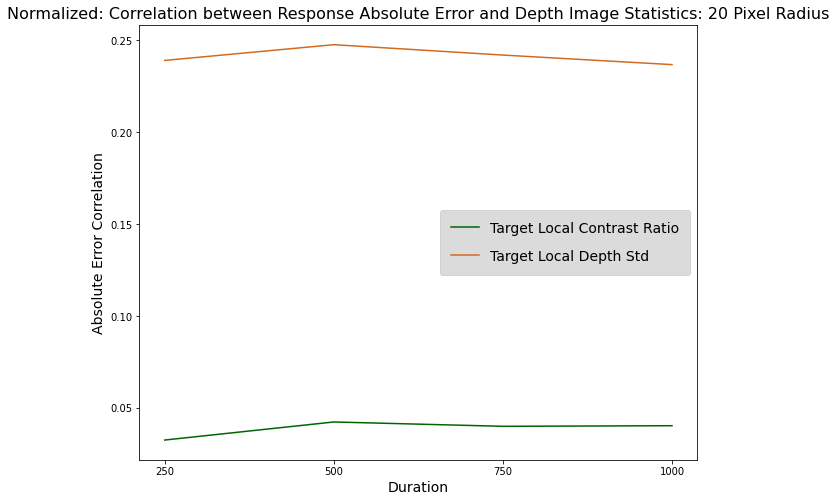

In [481]:
plt.figure(figsize = [10, 8])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Absolute Error Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, n_abserror_targetlocalcr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, n_abserror_targetlocalstd_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("Normalized: Correlation between Response Absolute Error and Depth Image Statistics: 20 Pixel Radius", fontsize = 16)

In [468]:
n_estim_stds = [n_std_250, n_std_500, n_std_750, n_std_1000]


In [474]:
n_estimstds_targetlocalstd_corrs = [scipy.stats.pearsonr(euclid_target_local_std, _std)[0] for _std in n_estim_stds]

n_estimstds_targetlocalcr_corrs = [scipy.stats.pearsonr(euclid_target_local_cr, _std)[0] for _std in n_estim_stds]

In [472]:
n_estimstds_targetlocalstd_corrs

[(0.03366652499199432, 0.6429470517343031),
 (0.06143828354547101, 0.39724329965763305),
 (-0.008687261769183233, 0.9048075920323081),
 (-0.02898114479423993, 0.6898666208116324)]

In [473]:
n_estimstds_targetlocalcr_corrs

[(-0.16542385539858212, 0.02184607837018368),
 (-0.09714746786619205, 0.18008363378541098),
 (-0.13607066567702192, 0.059849494019138375),
 (-0.15989050436919888, 0.026738628001837322)]

Text(0.5, 1.0, 'Normalized: Correlation between Response Standard Deviation and Depth Image Statistics: 20 Pixel Radius')

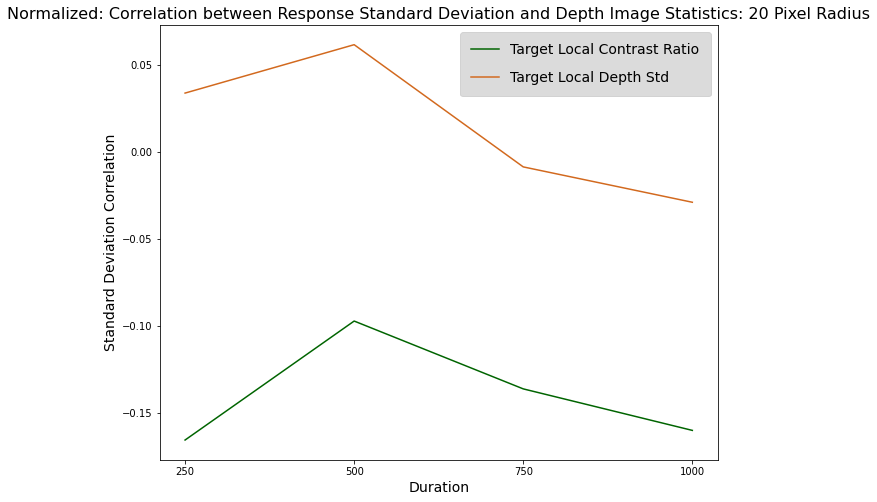

In [475]:
plt.figure(figsize = [10, 8])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Standard Deviation Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, n_estimstds_targetlocalcr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, n_estimstds_targetlocalstd_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("Normalized: Correlation between Response Standard Deviation and Depth Image Statistics: 20 Pixel Radius", fontsize = 16)

#### Neighbor Method: Residual Correlations

In [272]:
final_stimuli = '/Users/prachi/Documents/depth_duration/mar3_depthDuration_stimuli/final_stimuli/'
kinect2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

local_contrast_ratio_array = [local_depth_stats(path, final_stimuli, kinect2_path)[0] for path in final_x_250]
local_std_array = [local_depth_stats(path, final_stimuli, kinect2_path)[1] for path in final_x_250]
target_local_std = [local_depth_stats(path, final_stimuli, kinect2_path)[2] for path in final_x_250]
target_local_cr = [local_depth_stats(path, final_stimuli, kinect2_path)[3] for path in final_x_250]

residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

In [280]:
target_local_std_corrs = [scipy.stats.pearsonr(target_local_std, resid_dur)[0] for resid_dur in residuals]

target_local_cr_corrs = [scipy.stats.pearsonr(target_local_cr, resid_dur)[0] for resid_dur in residuals]

In [281]:
target_local_std_corrs

[0.010956757687190823,
 -0.08708509574121852,
 -0.05293803615937917,
 -0.04608177706842288]

Text(0.5, 1.0, '10 Pixel Radius')

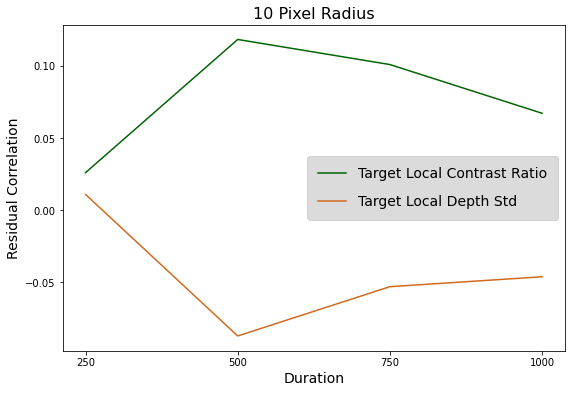

In [285]:
plt.figure(figsize = [9, 6])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Residual Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, target_local_cr_corrs, label = 'Target Local Contrast Ratio', color='darkgreen')
plt.plot(durations, target_local_std_corrs, label = 'Target Local Depth Std', color='chocolate')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')
plt.title("10 Pixel Radius", fontsize = 16)

## Split data randomly into half: Correlate Residuals

In [640]:
import random
from sklearn.linear_model import LinearRegression
import scipy
from scipy import stats 

def get_stimuli(data):
    """
    Args:
        data = [df_250, df_500, df_750, df_1000]
    Returns:
        all_stimuli = [imgs_250, imgs_500, imgs_750, imgs_1000]
    """
    
    all_stimuli = []
    for df in data:
        stimuli = set()
        for idx, row in df.iterrows():
            stimulus = row["stimulus"]
            stimuli.add(stimulus)
        all_stimuli.append(list(stimuli))
        
    return all_stimuli

def split_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 

    """
    
    stimuli = get_stimuli(data)
    splits = [None, None, None, None]
    duration_split_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        splits[i] = [split1[0], split2[0]]
        
        duration_split_corrs[i] = scipy.stats.pearsonr(split1[0], split2[0])[0] 

    
    return duration_split_corrs # raw splits 

def split_std_error(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard errors for each duration 

    """
    
    stimuli = get_stimuli(data)
    stderrors = [None, None, None, None]
    duration_avg_stderr = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_stderr = stats.sem(split1[0])
        split2_stderr = stats.sem(split2[0])

        stderrors[i] = [split1_stderr, split2_stderr]
        
        duration_avg_stderr[i] = np.mean(stderrors[i])
        

    return duration_avg_stderr


def split_std(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard deviations for each duration 

    """
    
    stimuli = get_stimuli(data)
    stds = [None, None, None, None]
    duration_avg_std = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_std = np.std(split1[0])
        split2_std = np.std(split2[0])

        stds[i] = [split1_std, split2_std]
        
        duration_avg_std[i] = np.mean(stds[i])
        

    return duration_avg_std

def split_residuals(data, proportion, duration, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list   
        
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        
        if i == duration: 
            return stim_actual, split1_residuals, split2_residuals
        


def split_residual_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        

    return duration_residual_corrs

def generate_n_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON REGRESSION CORRELATIONS
    """

    corrs = np.array([split_residual_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_raw_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON RAW SPLITS 
    """

    corrs = np.array([split_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_split_std_error(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD ERROR AVGS
    """

    avgs = np.array([split_std_error(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean


def generate_n_split_std(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD AVGS
    """

    avgs = np.array([split_std(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean
              

In [641]:
from sklearn.metrics import r2_score

def split_residual_rsquare(data, proportion, normalize = False, avg_participant_estimate = None):
    
    stimuli = get_stimuli(data)
    
    duration_residual_r2 = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_r2[i] = r2_score(split1_residuals[0], split2_residuals[0])
        

    return duration_residual_r2

def generate_n_split_r2(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON SPLIT RESIDUAL R^2
    """

    residual_r2s = np.array([split_residual_rsquare(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(residual_r2s, axis = 0) 
    return residual_r2s, mean

#### Split Residual R-Squared 

In [642]:
r2_100_05 = generate_n_split_r2(10, duration_data, 0.5)
r2_100_04 = generate_n_split_r2(10, duration_data, 0.4)
r2_100_03 = generate_n_split_r2(10, duration_data, 0.3)
r2_100_02 = generate_n_split_r2(10, duration_data, 0.2)

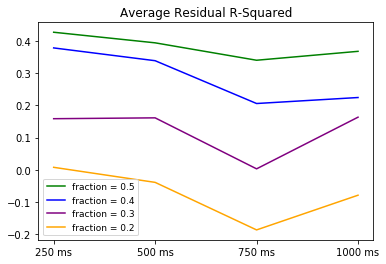

In [643]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

Text(0.5, 1, 'Raw Split Residual R-Squared')

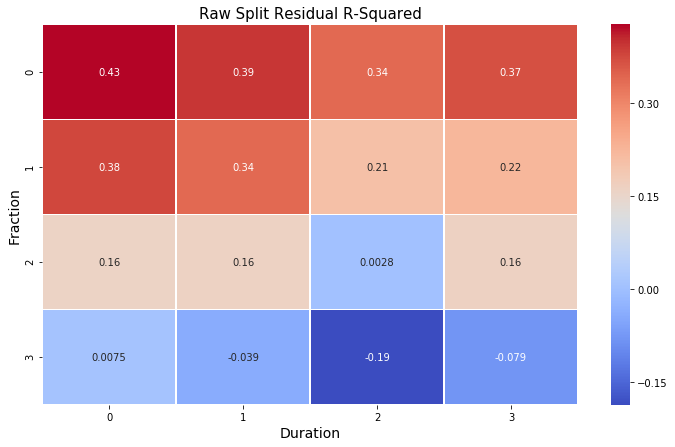

In [644]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize = [12, 7])
a = [r2_100_05[1], r2_100_04[1], r2_100_03[1], r2_100_02[1]]
ax = sns.heatmap(a, linewidth=0.5, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Duration', fontsize = 14)

plt.ylabel('Fraction', fontsize = 14)



plt.title('Raw Split Residual R-Squared', fontsize = 15)

In [1361]:
len(r2_100_05[0])

10

In [1277]:
norm_r2_100_05 = generate_n_split_std_error(10, normalized_duration_data, 0.5, True, average_depth_estimate)
norm_r2_100_04 = generate_n_split_std_error(10, normalized_duration_data, 0.4, True, average_depth_estimate)
norm_r2_100_03 = generate_n_split_std_error(10, normalized_duration_data, 0.3, True, average_depth_estimate)
norm_r2_100_02 = generate_n_split_std_error(10, normalized_duration_data, 0.2, True, average_depth_estimate)

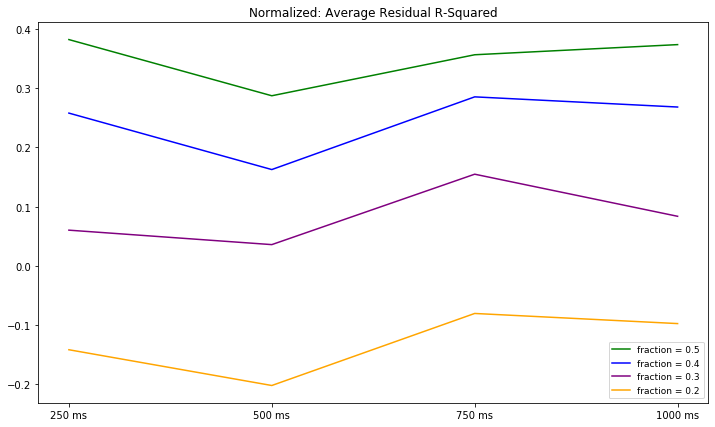

In [1372]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

Text(0.5, 1, 'Normalized Split Residual R-Squared')

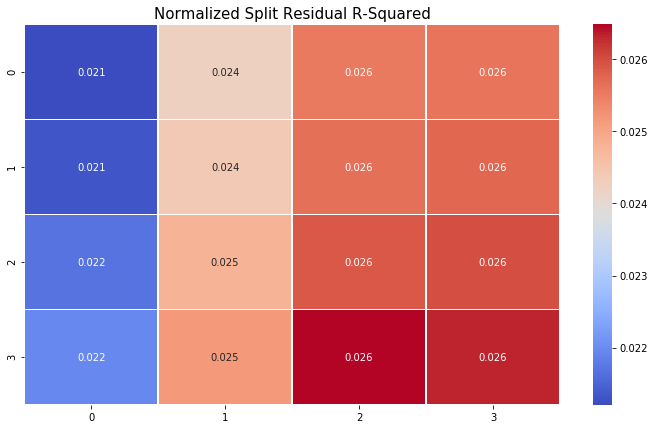

In [1373]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = [12, 7])
b = [norm_r2_100_05[1], norm_r2_100_04[1], norm_r2_100_03[1], norm_r2_100_02[1]]
ax = sns.heatmap(b, linewidth=0.5, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)



plt.title('Normalized Split Residual R-Squared', fontsize = 15)

#### Correlation between the splits: non-normalized data 

In [145]:
splits_05 = generate_n_raw_split_correlations(100, duration_data, 0.5)
splits_04 = generate_n_raw_split_correlations(100, duration_data, 0.4)
splits_03 = generate_n_raw_split_correlations(100, duration_data, 0.3)
splits_02 = generate_n_raw_split_correlations(100, duration_data, 0.2)


In [149]:
norm_splits_05 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.5)
norm_splits_04 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.4)
norm_splits_03 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.3)
norm_splits_02 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.2)


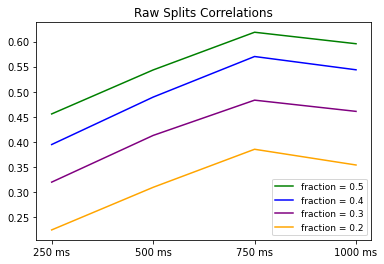

In [147]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Raw Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

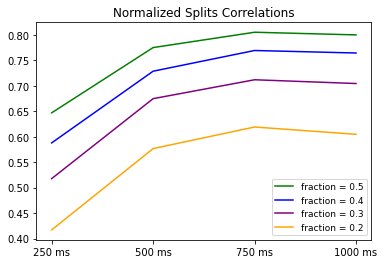

In [150]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

### Avg standard error of splits 

In [986]:
ste_100_05 = generate_n_split_std_error(10, duration_data, 0.5)
ste_100_04 = generate_n_split_std_error(10, duration_data, 0.4)
ste_100_03 = generate_n_split_std_error(10, duration_data, 0.3)
ste_100_02 = generate_n_split_std_error(10, duration_data, 0.2)

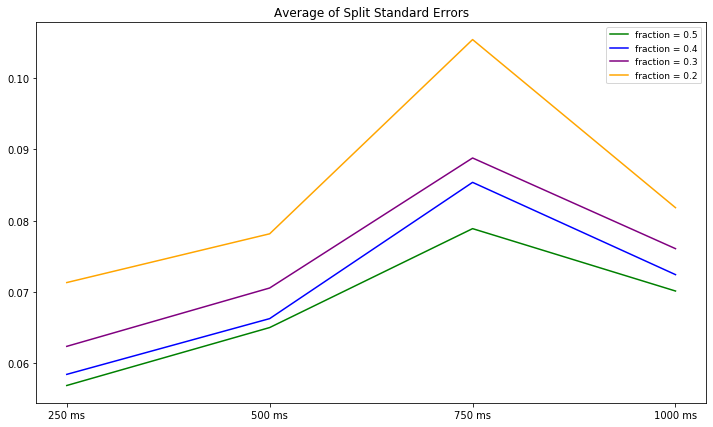

In [987]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

In [156]:
norm_ste_100_05 = generate_n_split_std_error(10, normalized_duration_data, 0.5)
norm_ste_100_04 = generate_n_split_std_error(10, normalized_duration_data, 0.4)
norm_ste_100_03 = generate_n_split_std_error(10, normalized_duration_data, 0.3)
norm_ste_100_02 = generate_n_split_std_error(10, normalized_duration_data, 0.2)

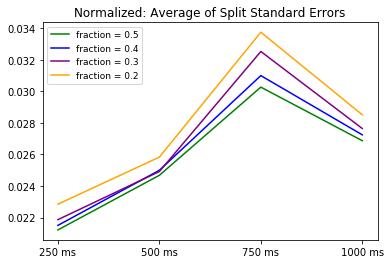

In [158]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

### Avg standard deviation of splits 

In [307]:
std_100_05 = generate_n_split_std(10, duration_data, 0.5)
std_100_04 = generate_n_split_std(10, duration_data, 0.4)
std_100_03 = generate_n_split_std(10, duration_data, 0.3)
std_100_02 = generate_n_split_std(10, duration_data, 0.2)

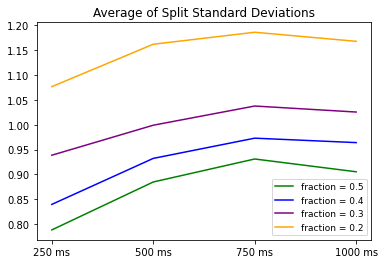

In [308]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

In [ ]:
norm_std_100_05 = generate_n_split_std(100, normalized_duration_data, 0.5)
norm_std_100_04 = generate_n_split_std(100, normalized_duration_data, 0.4)
norm_std_100_03 = generate_n_split_std(100, normalized_duration_data, 0.3)
norm_std_100_02 = generate_n_split_std(100, normalized_duration_data, 0.2)

In [ ]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

### Correlation between the residuals of splits

In [ ]:
raw_100_05 = generate_n_split_correlations(100, cleaned_data, 0.5)
raw_100_04 = generate_n_split_correlations(100, cleaned_data, 0.4)
raw_100_03 = generate_n_split_correlations(100, cleaned_data, 0.3)
raw_100_02 = generate_n_split_correlations(100, cleaned_data, 0.2)

In [ ]:
# raw_10000_05 = generate_n_split_correlations(10000, cleaned_data, 0.5)
# raw_10000_04 = generate_n_split_correlations(10000, cleaned_data, 0.4)
# raw_10000_03 = generate_n_split_correlations(10000, cleaned_data, 0.3)
# raw_10000_02 = generate_n_split_correlations(10000, cleaned_data, 0.2)

In [107]:
avg_average_particip_estim = 2.4779054712373956

In [113]:
normalized_100_05 = generate_n_split_correlations(100, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
normalized_100_04 = generate_n_split_correlations(100, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
normalized_100_03 = generate_n_split_correlations(100, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
normalized_100_02 = generate_n_split_correlations(100, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

In [ ]:
# normalized_10000_05 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
# normalized_10000_04 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
# normalized_10000_03 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
# normalized_10000_02 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

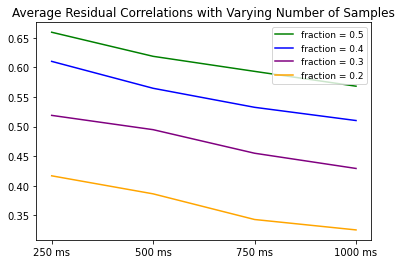

In [122]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, raw_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, raw_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, raw_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, raw_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

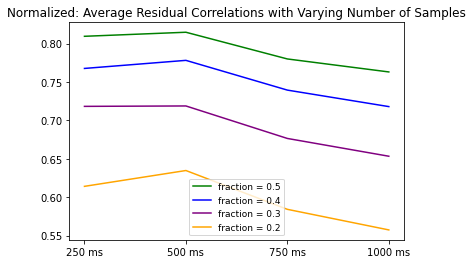

In [114]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, normalized_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, normalized_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, normalized_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, normalized_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

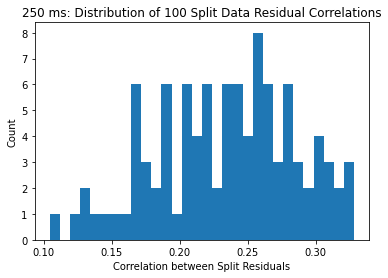

0.23373248798972746


In [286]:
lst_100_split_250_corrs = [elem[0] for elem in raw_100_05[0]]

plt.hist(lst_100_split_250_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'250 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_250_corrs)))

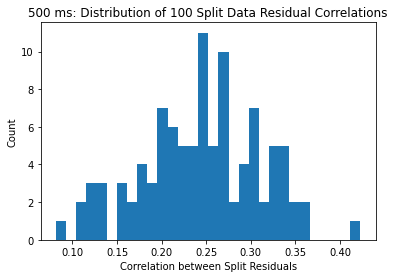

0.24456522832811065


In [285]:
lst_100_split_500_corrs = [elem[1] for elem in raw_100_05[0]]

plt.hist(lst_100_split_500_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'500 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_500_corrs)))

In [92]:
# lst_100_split_750_corrs = [elem[2] for elem in raw_100_05[0]]

# plt.hist(split1_750ms_05_n1, density = False, bins=30)
# plt.xlabel('Correlation between Split Residuals')
# plt.ylabel('Count')
# plt.title(r'750 ms: Distribution of 100 Split Data Residual Correlations')
# plt.show()

# print(np.mean(np.array(lst_100_split_750_corrs)))

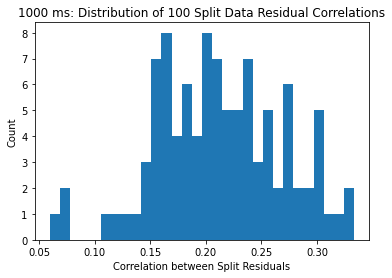

0.21255502738709686


In [283]:
lst_100_split_1000_corrs = [elem[3] for elem in raw_100_05[0]]

plt.hist(lst_100_split_1000_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'1000 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_1000_corrs)))

#### Plot Split Residuals 

In [1379]:
# split residuals for 750ms with fraction = 0.5, for n=1 where n is the number of iterations
#data, proportion, duration, normalize = False, avg_participant_estimate = None

actual_750ms_05_n1, split1_750ms_05_n1, split2_750ms_05_n1 = split_residuals(duration_data, 0.5, 2)

In [1380]:
actual_250ms_05_n1, split1_250ms_05_n1, split2_250ms_05_n1 = split_residuals(duration_data, 0.5, 0)

Text(0, 0.5, 'Split 2 Residuals')

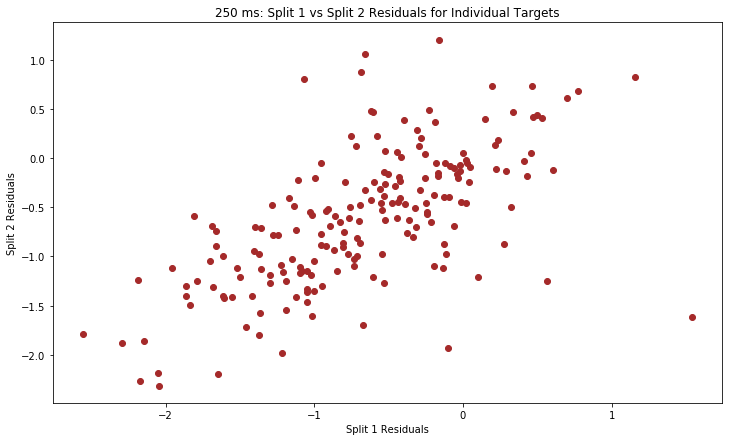

In [1381]:
plt.plot(split1_250ms_05_n1,split2_250ms_05_n1, 'o', color='brown')
plt.title("250 ms: Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

In [1383]:
norm_actual_250ms_05_n1, norm_split1_250ms_05_n1, norm_split2_250ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 0, True, average_depth_estimate)

norm_actual_500ms_05_n1, norm_split1_500ms_05_n1, norm_split2_500ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 1, True, average_depth_estimate)

norm_actual_750ms_05_n1, norm_split1_750ms_05_n1, norm_split2_750ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 2, True, average_depth_estimate)

norm_actual_1000ms_05_n1, norm_split1_1000ms_05_n1, norm_split2_1000ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 3, True, average_depth_estimate)


Text(0, 0.5, 'Split 2 Residuals')

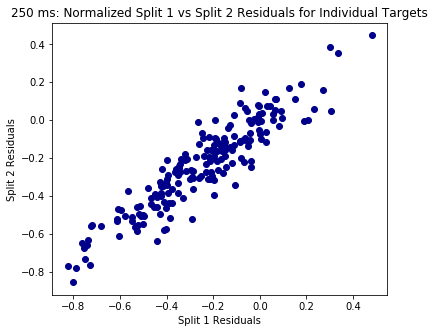

In [1390]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_250ms_05_n1,norm_split2_250ms_05_n1, 'o', color='darkblue')
plt.title("250 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

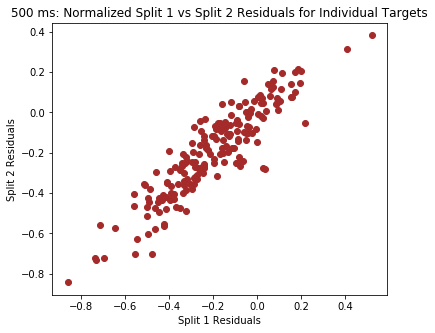

In [1391]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_500ms_05_n1,norm_split2_500ms_05_n1, 'o', color='brown')
plt.title("500 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

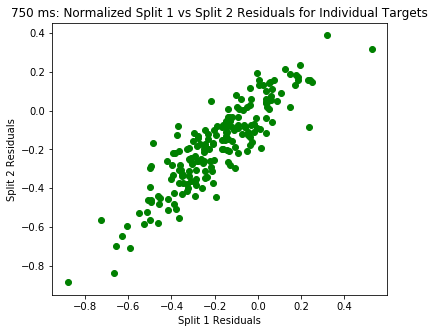

In [1389]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_750ms_05_n1,norm_split2_750ms_05_n1, 'o', color='green')
plt.title("750 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

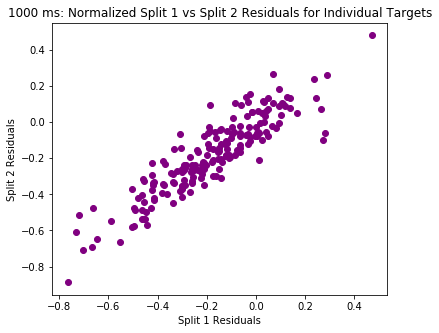

In [1388]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_1000ms_05_n1,norm_split2_1000ms_05_n1, 'o', color='purple')
plt.title("1000 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0.5, 1.0, 'SUN-RGBD Scene Category Distribution')

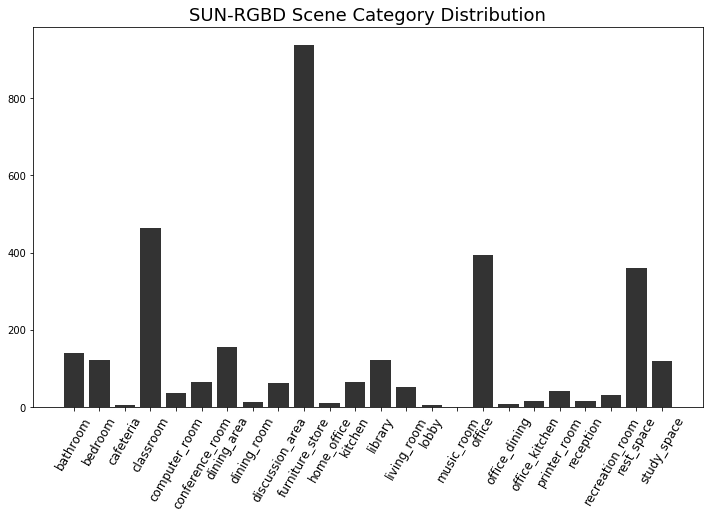

In [1446]:
scene_categories = {'bathroom': 139,
 'bedroom': 121,
 'cafeteria': 5,
 'classroom': 463,
 'computer_room': 37,
 'conference_room': 64,
 'dining_area': 156,
 'dining_room': 12,
 'discussion_area': 62,
 'furniture_store': 938,
 'home_office': 10,
 'kitchen': 66,
 'library': 123,
 'living_room': 51,
 'lobby': 5,
 'music_room': 1,
 'office': 394,
 'office_dining': 9,
 'office_kitchen': 16,
 'printer_room': 43,
 'reception': 16,
 'recreation_room': 31,
 'rest_space': 361,
 'study_space': 119}


fig = plt.figure()
keys = scene_categories.keys()
values = scene_categories.values()
plt.xticks(rotation = 60, fontsize = 12)
plt.bar(keys, values, color = 'black', alpha = 0.8)
plt.title("SUN-RGBD Scene Category Distribution", fontsize = 18)